# Прогнозирование большого количества рядов

Процесс подбора модели ARIMA в Питоне достаточно трудоёмок, поэтому вы не сможете вручную подобрать модель для каждого из рядов в выбранных ячейках. Чтобы облегчить ручной перебор, вам предстоит кластеризовать временные ряды и подобрать гиперпараметры модели ARIMA только один раз для всех рядов каждого кластера.

Результатом этой недели будут построенные с помощью ARIMA почасовые прогнозы количества поездок для всех географических зон Нью-Йорка. Модель, которую мы строим, должна делать почасовые прогнозы для всех выбранных непустых ячеек на 6 часов вперёд. Качество модели мы будем оценивать с помощью среднего абсолютного отклонения от истинного количества поездок

1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!
2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.
3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.
4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).
5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D, Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!
6. Для каждой из RR географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
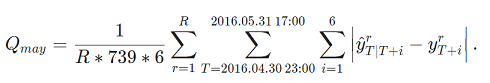
7. Для каждой из RR географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.
8. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.
9. Загрузите ноутбук в форму.

In [22]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler as scaler
from itertools import product
import datetime

In [23]:
import warnings
warnings.simplefilter(action='ignore')

**Замечание:** Метод `sklearn.cluster KMeans` не всегда корректно работает при версии `numpy` старше 1.21.4. Если вы столкнетесь с таким, имеет смысл откатить версию numpy до 1.21.4. 

In [24]:
np.__version__

'1.18.5'

In [25]:
!pip install --upgrade numpy==1.21.4

ERROR: Could not find a version that satisfies the requirement numpy==1.21.4
ERROR: No matching distribution found for numpy==1.21.4


###  👹Задание 1
1. В ноутбуке недели 2 вы определили 102 региона, из которых фиксируется в среднем не менее 5 вызовов в час. Спиcок этих регионов можно сохранить из ноутбука недели 2 в виде текстового файла, и воспользоваться им в данном задании. Либо загрузите данные из приложенного файла `nonzero_regions.csv`
2. Загрузите аггрерированные по регионам данные о числе поездок за январь-апрель 2016 и объедините в один датасет данные за январь-апрель только по интересующим регионам.
3. Если в качестве переменных вы используете индикаторы аномальности погоды,праздничных дней и пр, создайте соответсвующие списки.

In [26]:
nonzero_reg=pd.read_csv("nonzero_regions.csv").iloc[:,1]
nonzero_reg

0      1075
1      1076
2      1077
3      1125
4      1126
       ... 
97     2068
98     2069
99     2118
100    2119
101    2168
Name: 0, Length: 102, dtype: int64

In [27]:
df_3=pd.read_csv("taxi_2016_03.csv")
df_4=pd.read_csv("taxi_2016_04.csv")
df_2=pd.read_csv("taxi_2016_02.csv")
df_1=pd.read_csv("taxi_2016_01.csv")
data=pd.concat([ df_1,df_2,df_3,df_4], axis=0)

In [28]:
data.rename(columns={'Unnamed: 0':'time'}, inplace=True)
data.index=data.time
df=data.iloc[:,nonzero_reg]
df.head()

1075   1076  1077   1125   1126   1127   1128   1129  \
time                                                                        
2016-01-01 00:00:00  80.0  144.0  50.0   77.0  319.0  402.0  531.0  617.0   
2016-01-01 01:00:00  91.0  211.0  49.0  134.0  404.0  420.0  370.0  453.0   
2016-01-01 02:00:00  90.0  146.0  23.0  110.0  393.0  425.0  313.0  366.0   
2016-01-01 03:00:00  32.0   87.0  16.0   62.0  252.0  399.0  324.0  309.0   
2016-01-01 04:00:00  24.0   43.0  10.0   53.0  145.0  254.0  264.0  333.0   

                      1130   1131  ...  1630  1684  1733  1734  1783  2068  \
time                               ...                                       
2016-01-01 00:00:00  846.0  267.0  ...  12.0   0.0   2.0  44.0   5.0  41.0   
2016-01-01 01:00:00  594.0  224.0  ...  29.0   0.0   5.0   2.0   2.0   4.0   
2016-01-01 02:00:00  377.0  138.0  ...  47.0   0.0   3.0   0.0   4.0   0.0   
2016-01-01 03:00:00  327.0  166.0  ...  46.0   0.0   2.0   4.0   5.0   1.0   
2016-01-01 04:00:00  318.0  145.0  ...  43.0   0.0   0.0   1.0   1.0   0.0   

                     2069  2118  2119  2168  
time                                         
2016-01-01 00:00:00   4.0  70.0   7.0  66.0  
2016-01-01 01:00:00   0.0  47.0   1.0  29.0  
2016-01-01 02:00:00   0.0  69.0   1.0  14.0  
2016-01-01 03:00:00   0.0  21.0   0.0   9.0  
2016-01-01 04:00:00   0.0  26.0   1.0   6.0  

[5 rows x 102 columns]

In [29]:
reg_index=[int(x) for x in nonzero_reg]

In [30]:
# ваш код


###  👹Задание 2
Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это можно сделать с помощью `sklearn.preprocessing.StandardScaler`

In [31]:
sc=scaler()
df_s=pd.DataFrame(sc.fit_transform(X=np.array(df)), columns=df.columns)
df_s

1075      1076      1077      1125      1126      1127      1128  \
0     0.534333  0.178299 -0.565388  0.271055  1.423610  0.941333  1.327688   
1     0.823393  1.005639 -0.582598  1.673853  2.292927  1.069294  0.407607   
2     0.797115  0.202995 -1.030077  1.083201  2.180427  1.104839  0.081865   
3    -0.727022 -0.525558 -1.150552 -0.098103  0.738384  0.920006  0.144727   
4    -0.937247 -1.068886 -1.253817 -0.319598 -0.355932 -0.110791 -0.198160   
...        ...       ...       ...       ...       ...       ...       ...   
2899  1.611740  0.980942  1.069631  0.861707  1.689519  1.247018  1.259110   
2900  1.243845  0.968594  0.277938  1.009370  1.127020  1.005314  1.396265   
2901  0.823393  0.314131  0.432834  1.206254  1.413383  1.374979  1.722008   
2902  1.059897 -0.402074  0.036988  0.837096  0.380430  1.076403  2.276342   
2903  0.849671 -0.142759 -0.341648  0.492549  1.065656  1.844169  2.482074   

          1129      1130      1131  ...      1630      1684      1733  \
0     1.324958  1.906912  1.834977  ...  1.551231 -0.883705 -0.571914   
1     0.529828  0.846918  1.255230  ...  5.252950 -0.883705 -0.069239   
2     0.108021 -0.065856  0.095738  ...  9.172418 -0.883705 -0.404356   
3    -0.168335 -0.276172  0.473247  ...  8.954670 -0.883705 -0.571914   
4    -0.051975 -0.314029  0.190115  ...  8.301425 -0.883705 -0.907031   
...        ...       ...       ...  ...       ...       ...       ...   
2899  1.843733  1.784929  1.524880  ... -0.843999 -0.883705 -0.069239   
2900  1.887368  1.881674  1.066476  ... -0.626251 -0.883705 -0.571914   
2901  2.575834  1.843817  0.284492  ... -0.626251 -0.883705 -0.571914   
2902  2.963703  2.171911  0.972098  ... -0.843999 -0.883705 -0.571914   
2903  2.396445  2.209768  0.729414  ... -0.190755 -0.883705 -0.907031   

          1734      1783      2068      2069      2118      2119      2168  
0    -1.047780 -1.251905 -0.786766 -0.681902 -0.821275 -0.855714  0.031380  
1    -1.325716 -1.275832 -1.423829 -1.172000 -1.125258 -1.089383 -0.931147  
2    -1.338951 -1.259881 -1.492701 -1.172000 -0.834492 -1.089383 -1.321360  
3    -1.312481 -1.251905 -1.475483 -1.172000 -1.468890 -1.128328 -1.451432  
4    -1.332334 -1.283807 -1.492701 -1.172000 -1.402807 -1.089383 -1.529474  
...        ...       ...       ...       ...       ...       ...       ...  
2899 -0.333085 -0.629819  0.917809 -0.559377  0.341789  1.169419  0.499636  
2900 -0.405878 -0.964789  0.556233  0.175771  1.319821  0.818915  1.436149  
2901 -0.081619 -0.757427  0.728412  0.788394  0.341789  2.026206  1.358106  
2902  0.183083 -0.653746  0.780066  1.401017  0.870455 -0.232596  0.733765  
2903 -0.048531 -0.861108  0.814502  0.053246  0.645772  1.753592 -0.671004  

[2904 rows x 102 columns]

In [32]:
df_t=df_s.transpose()
df_t.head()

0         1         2         3         4         5         6     \
1075  0.534333  0.823393  0.797115 -0.727022 -0.937247 -1.278864 -1.383977   
1076  0.178299  1.005639  0.202995 -0.525558 -1.068886 -1.377595 -1.291156   
1077 -0.565388 -0.582598 -1.030077 -1.150552 -1.253817 -1.339870 -1.374292   
1125  0.271055  1.673853  1.083201 -0.098103 -0.319598 -1.205576 -1.205576   
1126  1.423610  2.292927  2.180427  0.738384 -0.355932 -1.307067 -1.440022   

          7         8         9     ...      2894      2895      2896  \
1075 -1.331421 -1.094917 -0.989804  ...  2.058469  2.242417  2.689147   
1076 -1.291156 -1.278808 -1.130628  ...  2.326913  2.092295  1.042684   
1077 -1.253817 -1.271027 -1.133342  ...  1.052420  1.104052  0.501677   
1125 -1.254797 -1.131744 -0.910250  ...  0.615602  0.615602  0.221834   
1126 -1.409340 -1.122977 -1.153658  ...  1.116792  1.096338  0.861111   

          2897      2898      2899      2900      2901      2902      2903  
1075  2.163582  2.557756  1.611740  1.243845  0.823393  1.059897  0.849671  
1076  1.289651  1.153819  0.980942  0.968594  0.314131 -0.402074 -0.142759  
1077  0.484466  0.708206  1.069631  0.277938  0.432834  0.036988 -0.341648  
1125  0.763265  1.107812  0.861707  1.009370  1.206254  0.837096  0.492549  
1126  1.556564  1.628155  1.689519  1.127020  1.413383  0.380430  1.065656  

[5 rows x 2904 columns]

###  👹Задание 3
1. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим.
2. Создайте списки регионов для каждого из кластеров (`reg_0`, `reg_1`,...)
3. Постройте графики стандартизованных рядов каждого кластера, чтобы убедиться в том, что ряды внутри кластеров имеют похожую форму.
**Рекомендации:**
- Можете воспользоваться любыми методами кластеризации. Если выберите kmeans или иерархическую кластеризацию, пользуйтесь кодом из ноутбука Wine-class.ipynb
- Если вы выберете для кластеризации kmeans, проведите предварительный анализ и выберите оптимально число кластеров методом плеча или методом ситуэта.
- Обратите внимание, что кластеризация идет по строкам датасета. Чтобы кластеризововать регионы, а не время, имеет смысл создать для кластеризации транспонированный датасет `df_t`, чтобы регионы располагались по строкам.

In [13]:
!pip install yellowbrick

In [14]:
df_t.min().min()

-2.208849529136438

Optimal number of clusters 4


Text(0, 0.5, 'distortion')

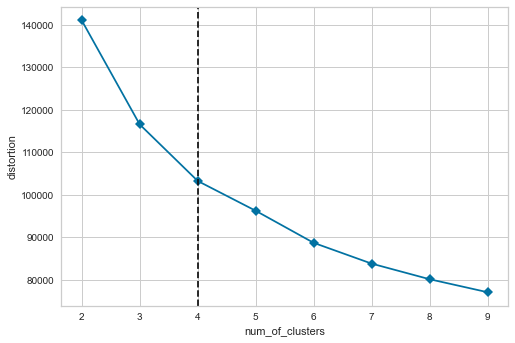

In [35]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=1)
kmeans_v = KElbowVisualizer(kmeans, k=(2,10), metric='distortion', timings=False).fit(df_t)
print('Optimal number of clusters', kmeans_v.elbow_value_)
plt.xlabel('num_of_clusters')
plt.ylabel('distortion')

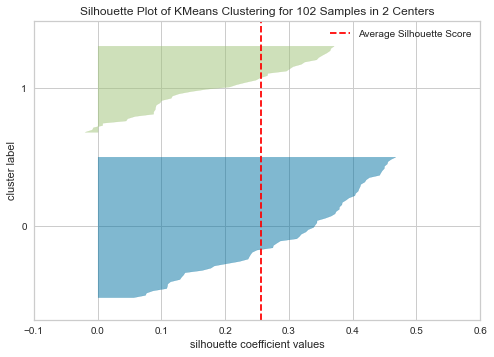

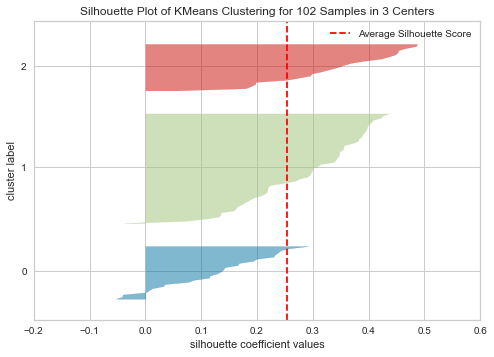

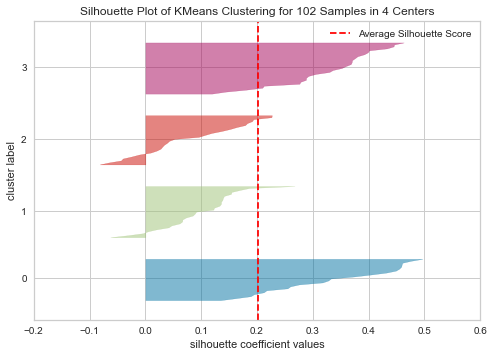

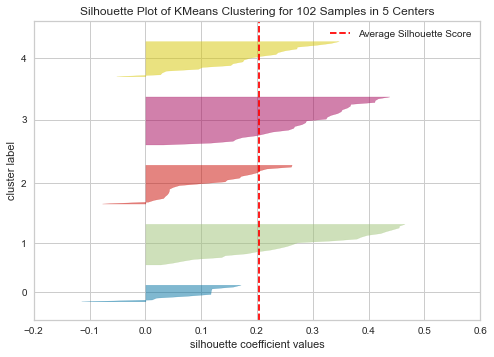

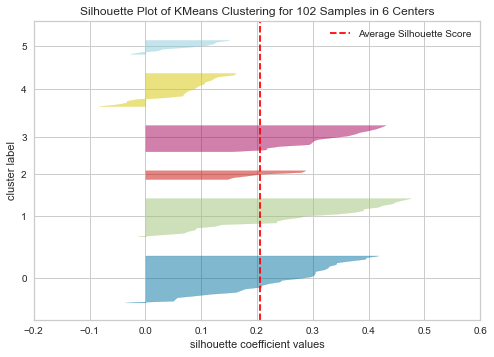

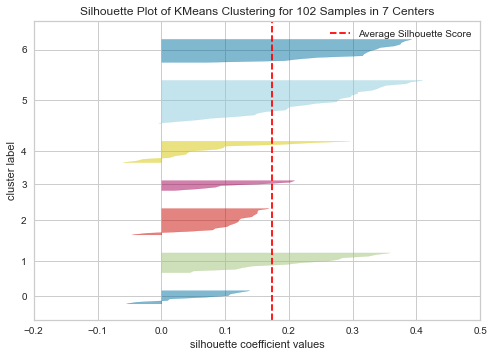

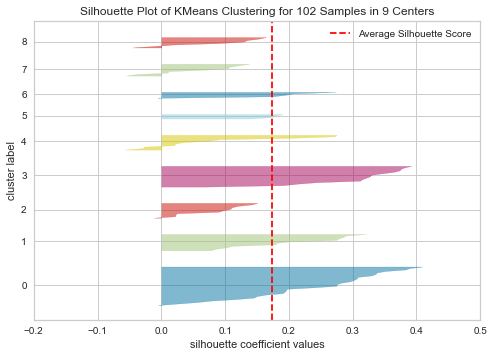

In [16]:
# Ваш код - кластеризация
from sklearn.cluster import KMeans

from yellowbrick.cluster import silhouette_visualizer

# Load a clustering dataset
for clusters in range(2, 10):
    silhouette_visualizer(KMeans(clusters, random_state=1), df_t, colors='yellowbrick')

## Используя метод локтя, алгоритм однозначно выделяет 4 кластера. Судя по методу силуэтов, можно выбрать и 4, и 7, и 8 кластеров. Несмотря на рекомендацию метода локтя, возьмем побольше кластеров. Например, 7.

In [36]:
model = KMeans(7, random_state=1)
model.fit(df_t)

KMeans(n_clusters=7, random_state=1)

In [37]:
model.labels_

array([6, 5, 5, 6, 6, 6, 4, 4, 4, 6, 5, 2, 2, 2, 2, 4, 4, 4, 6, 6, 5, 4,
       5, 5, 1, 1, 4, 4, 2, 1, 4, 4, 6, 6, 6, 6, 5, 5, 1, 1, 4, 4, 5, 5,
       6, 6, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 6, 2, 1, 1, 1, 4,
       6, 5, 5, 5, 5, 2, 2, 2, 2, 1, 3, 5, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 1, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
clusters={0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[]}
for label, index in zip(model.labels_, df_t.index):
     clusters[label].append(index)

In [39]:
for value in clusters.keys():
    print(f'Elements in {value} cluster: {len(clusters[value])}')

Elements in 0 cluster: 9
Elements in 1 cluster: 13
Elements in 2 cluster: 17
Elements in 3 cluster: 7
Elements in 4 cluster: 14
Elements in 5 cluster: 27
Elements in 6 cluster: 15


In [21]:
def show_cluster(num):
    # отображение стандартизированных рядов
    #reg_0 - список регионов из кластера 0 
    plt.figure(figsize=(16,len(clusters[num])*2))
    for (reg_num, i) in  zip(clusters[num],range(len(clusters[num]))) :
        plt.subplot(len(clusters[num]),1,i+1)
        plt.plot(df_s[str(reg_num)], color='tab:blue')
    plt.show()

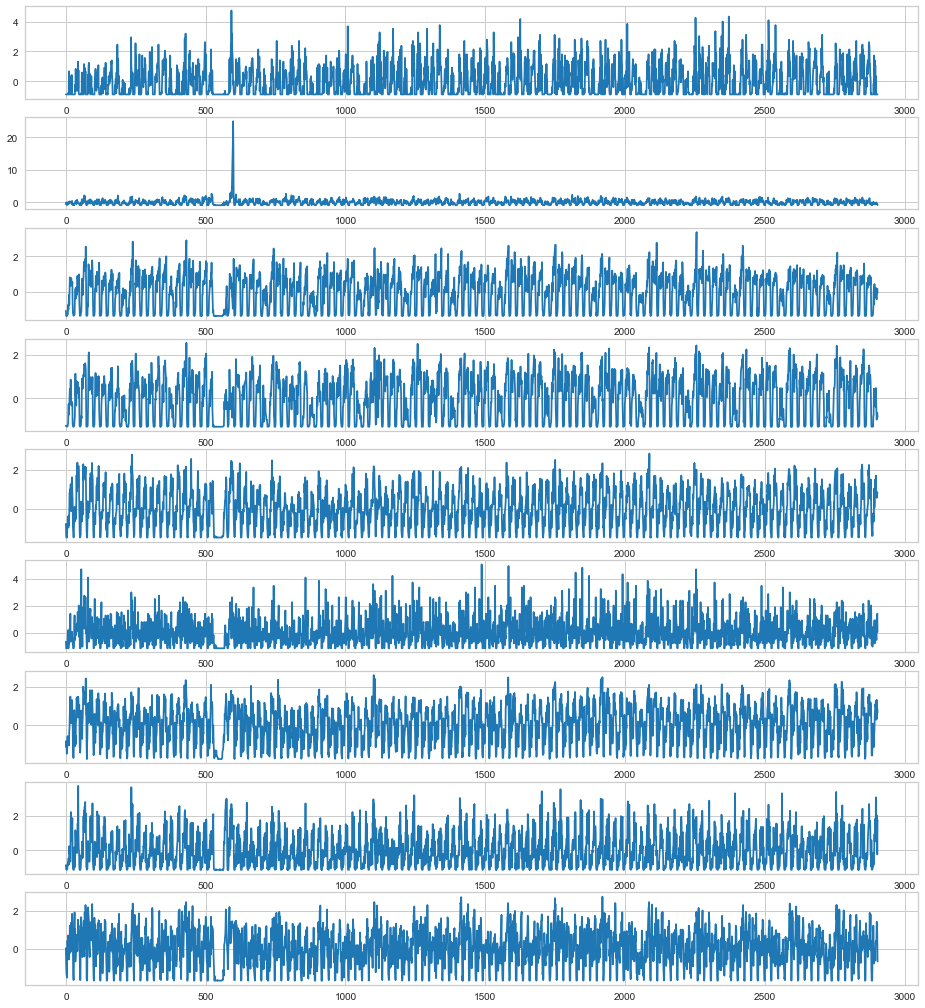

In [22]:
show_cluster(0)

###  👹Задание 4
В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).

**Рекомендации:**
- Если вы использовали kmeans, то можно выбрать ряд наиболее близкий к центру кластера,  воспользовавшись методом `sklearn.metrics.pairwise_distances_argmin_min`.


In [41]:
from sklearn.metrics import pairwise_distances_argmin_min

In [42]:
closest, _ = pairwise_distances_argmin_min(model.cluster_centers_, df_t)
closest

array([97, 63, 71, 88,  7, 55, 19], dtype=int64)

In [43]:
inds=df_t.index[closest]
inds

Index(['2068', '1377', '1387', '1530', '1129', '1333', '1180'], dtype='object')

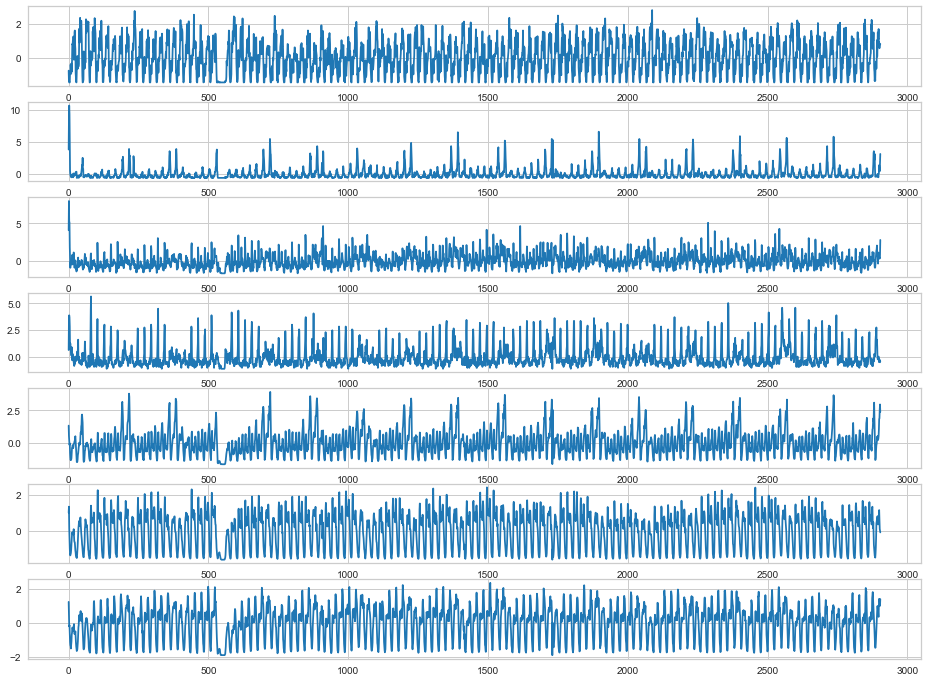

Wall time: 1.37 s


In [26]:
%%time
n_clust = 7
plt.figure(figsize=(16,12))
for i in range(n_clust) :
    plt.subplot(n_clust,1,i+1)
    plt.plot(df_s[inds[i]], color='tab:blue')
    
plt.show()

###  👹Задание 5
Для выбранных географических зон подберите на исходных рядах (из датасета `df`) начальные приближения параметров ARIMA - p,R,q,Q,D,d путем графического остатка остатков регрессий рядов на экзогенные переменные.

**Рекомендации:**
- Можете воспользоваться предложеннвми ниже функциями `prepair_for_ARIMA()` и `graph_analysis_for_ARIMA()`для создания экзогенных переменных для модели ARIMA, обучения регрессии на экзогенные переменные, визуального анализа остатком модели регрессии.


In [27]:
def prepair_for_ARIMA(clust,k=51):
    dataset=pd.DataFrame(df[inds[clust]].values,index=pd.to_datetime(df.index), columns={'count'})
    #dataset['time']=df.index
    #cluster0.head()
    w=168 # длительность недели в часах
    t=np.arange(1, dataset.shape[0]+1)
    dataset['constant']=np.ones(dataset.shape[0])
    for i in range(1,k):
        sin="s"+str(i)
        cos="c"+str(i)
        dataset[sin]=np.sin(2*i*np.pi*t/w)
        dataset[cos]=np.cos(2*i*np.pi*t/w)
    #dataset['time']=pd.to_datetime(dataset['time'])
    #for j in range(wheather.shape[0]):
    #    w='wh_'+str(j)
    #    dataset[w]=0
    #for i in range(dataset.shape[0]):
    #    for j in range(wheather.shape[0]):
    #        w='wh_'+str(j)
    #        if ((dataset['time'].iloc[i].year==wheather[j].year)&(dataset['time'].iloc[i].month==wheather[j].month)&(dataset['time'].iloc[i].day== wheather[j].day)):
    #            dataset[w].iloc[i]=1
    model0=sm.OLS(dataset['count'], dataset.drop(['count'], axis=1)).fit()
    print(f'R-squared: {model0.rsquared_adj}')
    print(f'AIC: {model0.aic}')
    
    return(dataset, model0)

def graph_analysis_for_ARIMA(model):
    resid=pd.DataFrame(model.resid, columns={'resid'}) 
    resid['resid_D24'] = resid.resid - resid.resid.shift(24)
    sm.tsa.seasonal_decompose(resid.resid[0:1000], period=24).plot( )
    sm.tsa.seasonal_decompose(resid.resid_D24[25:1000], period=24).plot( )
    plt.figure(figsize=(16,24))
    plt.title('Resid')
    ax1 = plt.subplot(411)
    sm.graphics.tsa.plot_acf(resid['resid'].values.squeeze(), lags=628, ax=ax1)
    ax2 = plt.subplot(412)
    sm.graphics.tsa.plot_acf(resid['resid'].values.squeeze(), lags=np.arange(0,100), ax=ax2)
    ax3 = plt.subplot(413)
    sm.graphics.tsa.plot_pacf(resid['resid'].values.squeeze(), lags=628, ax=ax3)
    ax4 = plt.subplot(414)
    sm.graphics.tsa.plot_pacf(resid['resid'].values.squeeze(), lags=np.arange(0,100), ax=ax4)
    #plt.show()
    plt.figure(figsize=(16,24))
    plt.title('Resid_24')
    ax1 = plt.subplot(411)
    sm.graphics.tsa.plot_acf(resid['resid_D24'][25:].values.squeeze(), lags=628, ax=ax1)
    ax2 = plt.subplot(412)
    sm.graphics.tsa.plot_acf(resid['resid_D24'][25:].values.squeeze(), lags=np.arange(0,100), ax=ax2)
    ax3 = plt.subplot(413)
    sm.graphics.tsa.plot_pacf(resid['resid_D24'][25:].values.squeeze(), lags=628, ax=ax3)
    ax4 = plt.subplot(414)
    sm.graphics.tsa.plot_pacf(resid['resid_D24'][25:].values.squeeze(), lags=np.arange(0,100), ax=ax4)
    plt.show()
    print('p-value критерия Дики-Фуллера для ряда остатков =', round(adfuller(resid['resid'])[1], 4))
    print('p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  =', round(adfuller(resid['resid_D24'][24:])[1], 4))



In [28]:
def seeking_of_parameters(cluster_number, exog_num):
    print(f'Cluster {cluster_number} analysis')
    cluster, mod = prepair_for_ARIMA(cluster_number, k=exog_num)
    graph_analysis_for_ARIMA(mod)
    print(f'Cluster {cluster_number} end of analysis')

Cluster 0 analysis
R-squared: 0.8141923773100274
AIC: 27044.79611614126


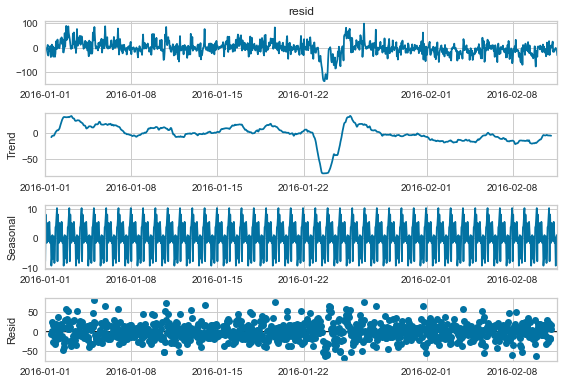

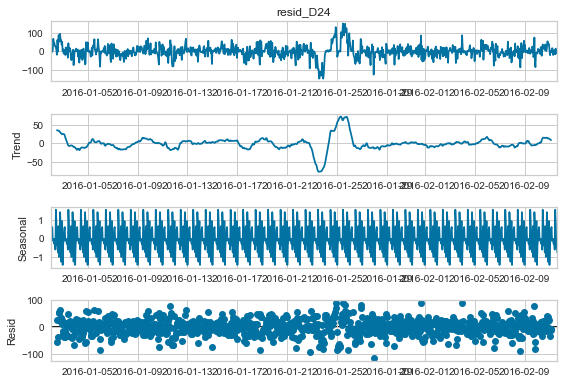

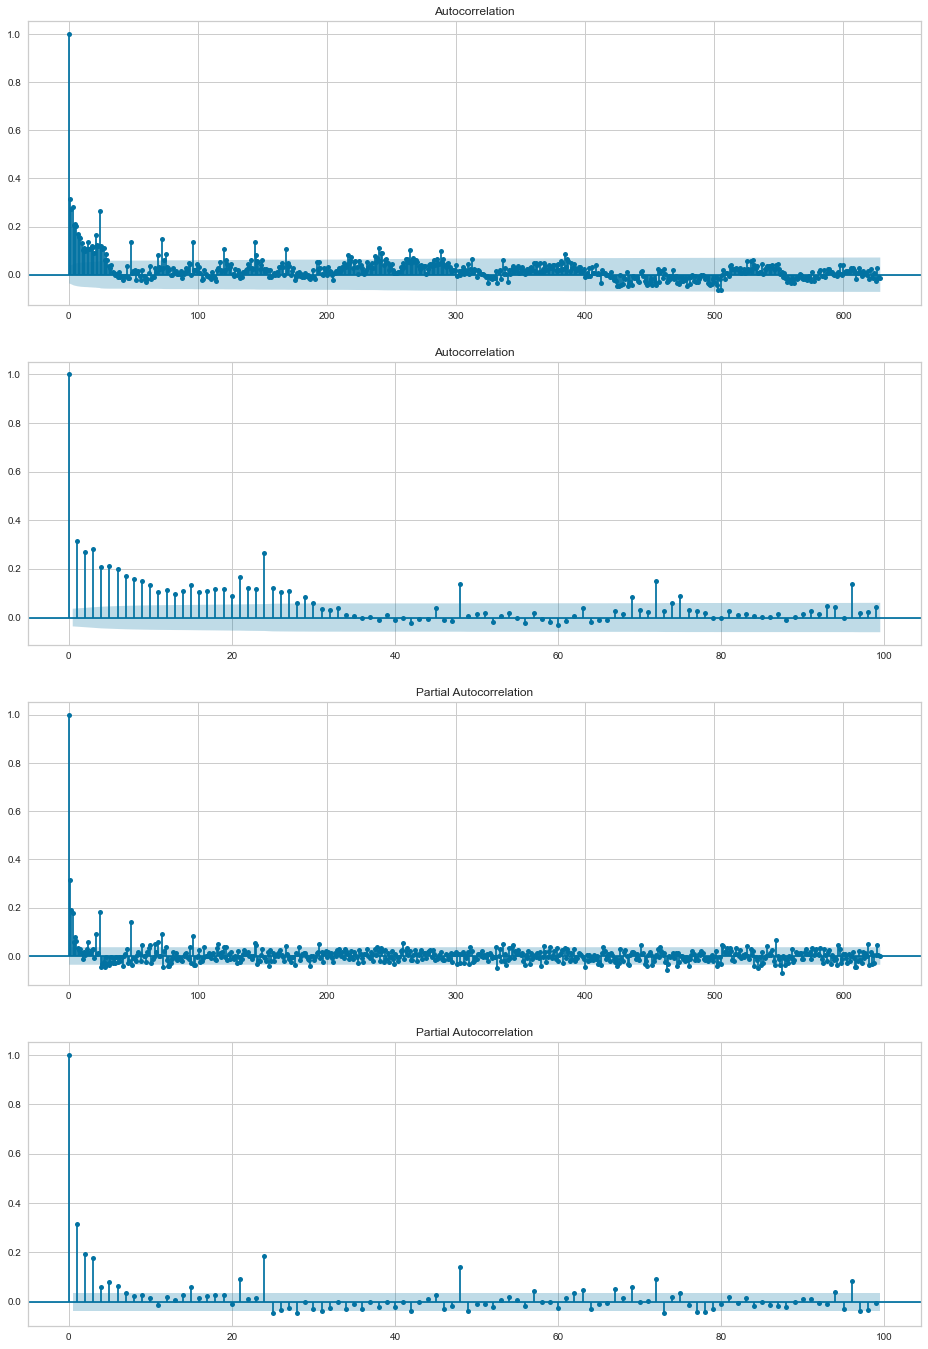

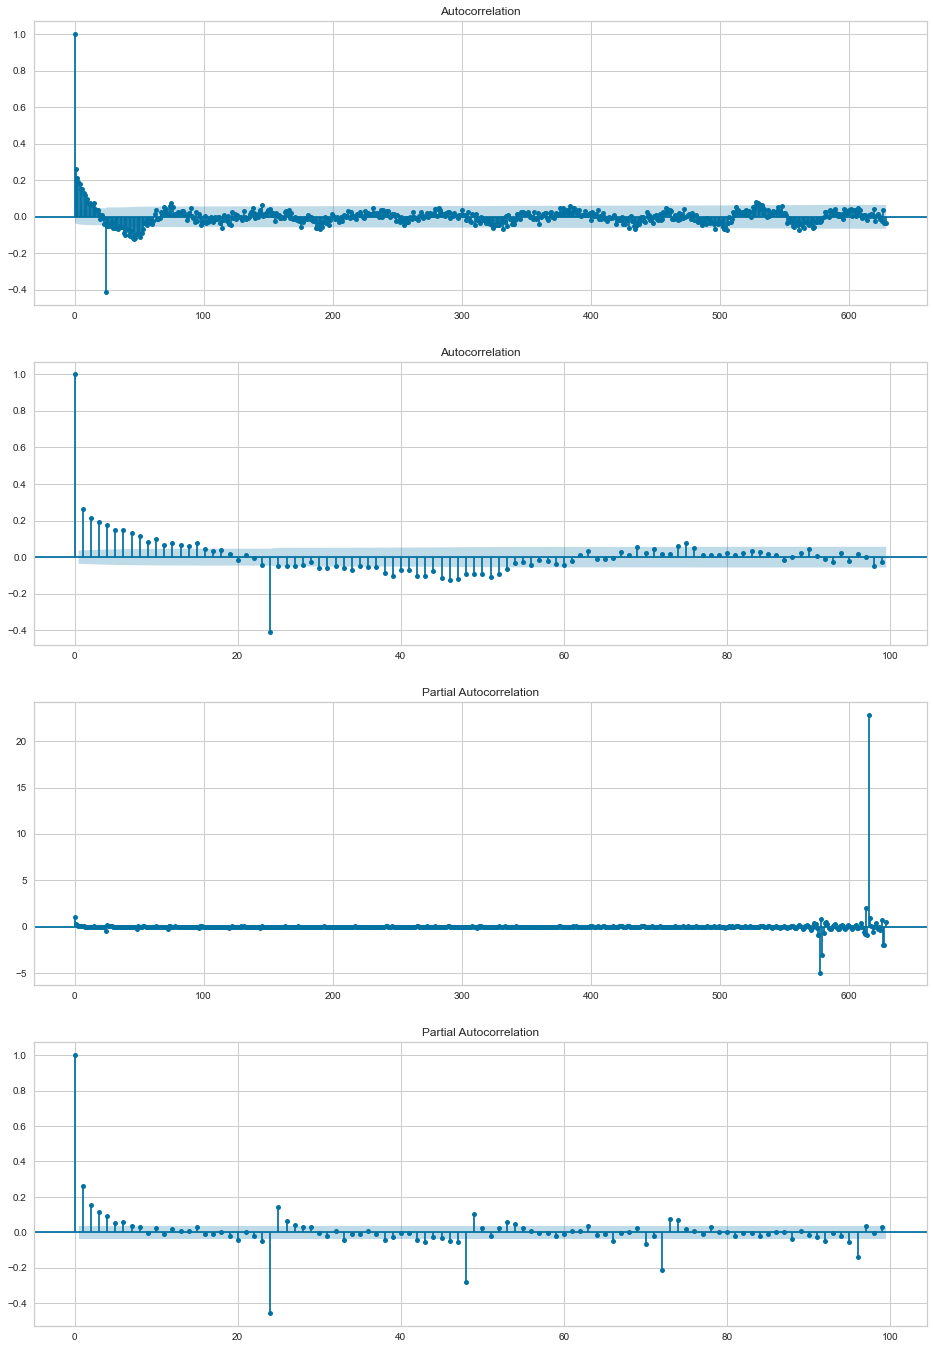

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 0 end of analysis
Cluster 1 analysis
R-squared: 0.7164164716491421
AIC: 18823.576096133223


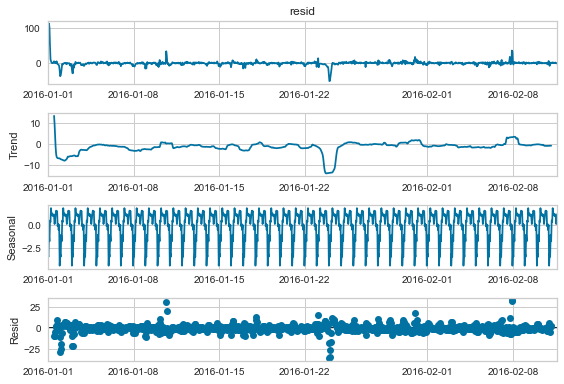

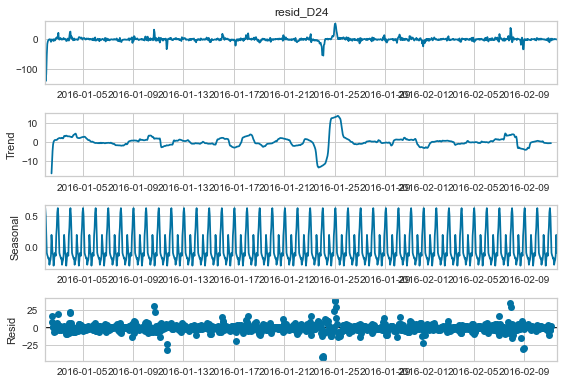

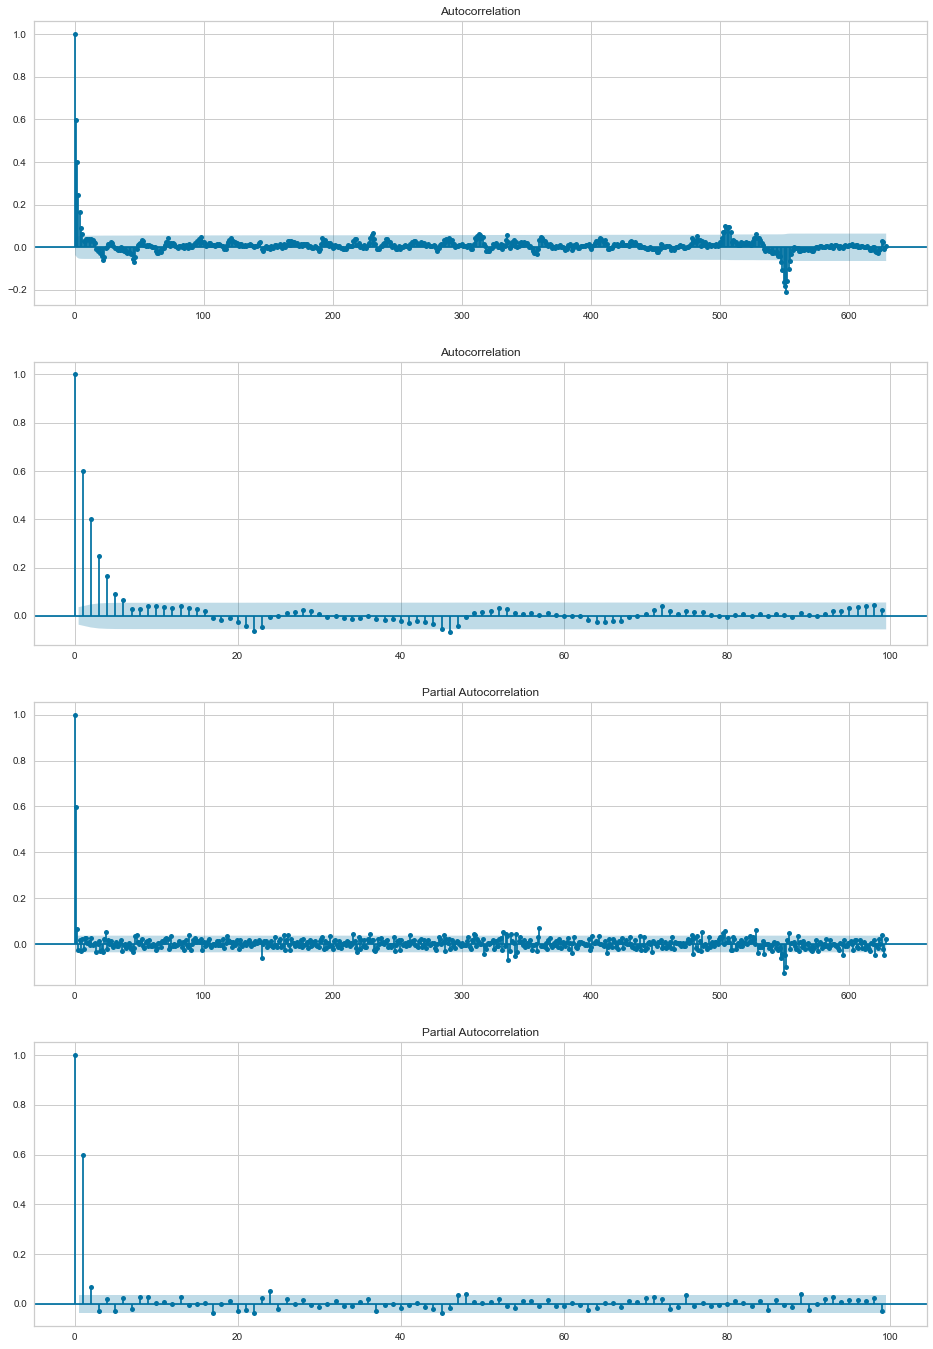

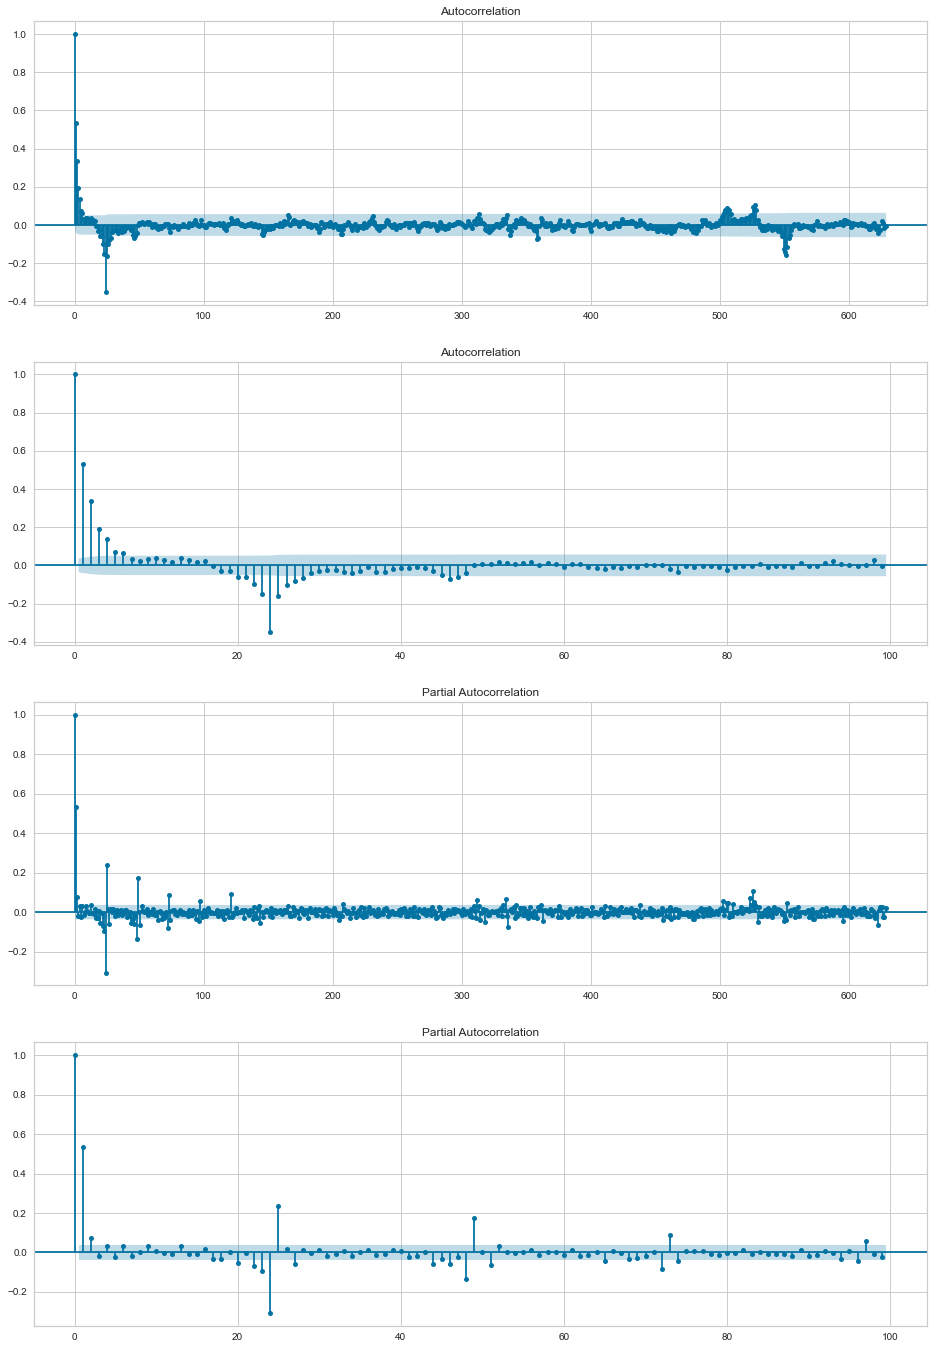

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 1 end of analysis
Cluster 2 analysis
R-squared: 0.6278100364103733
AIC: 21606.860340854357


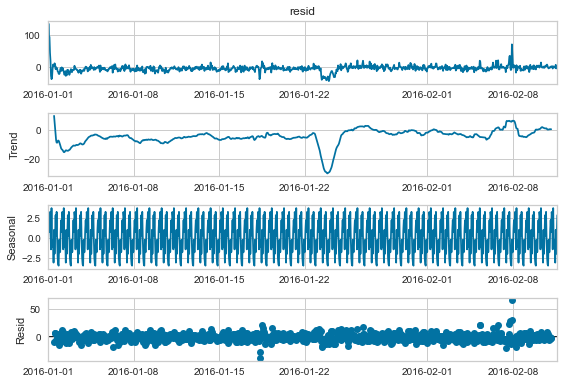

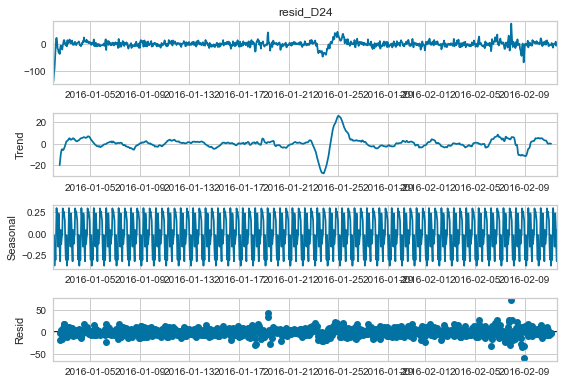

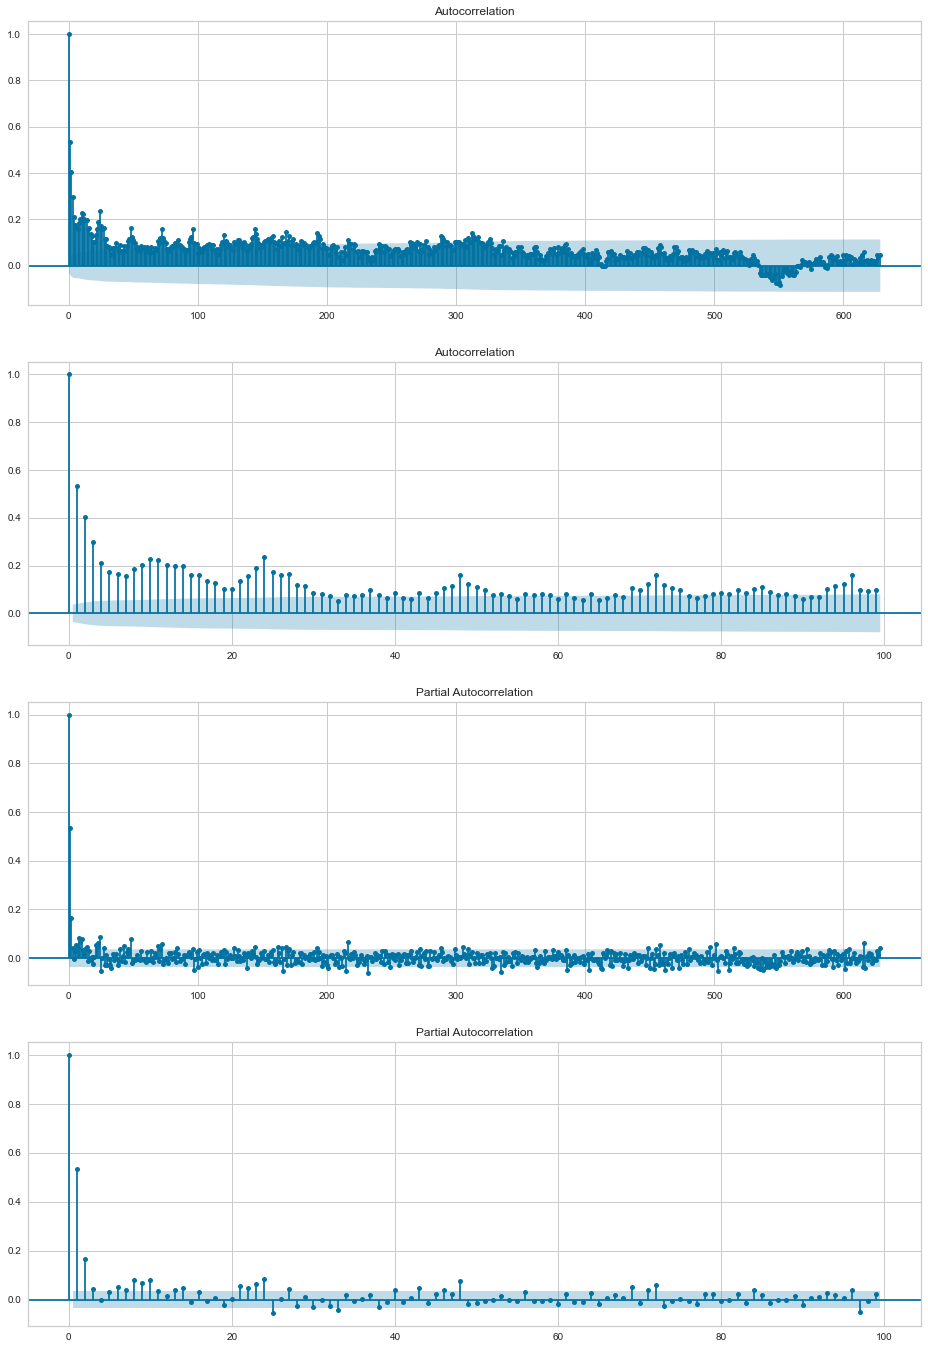

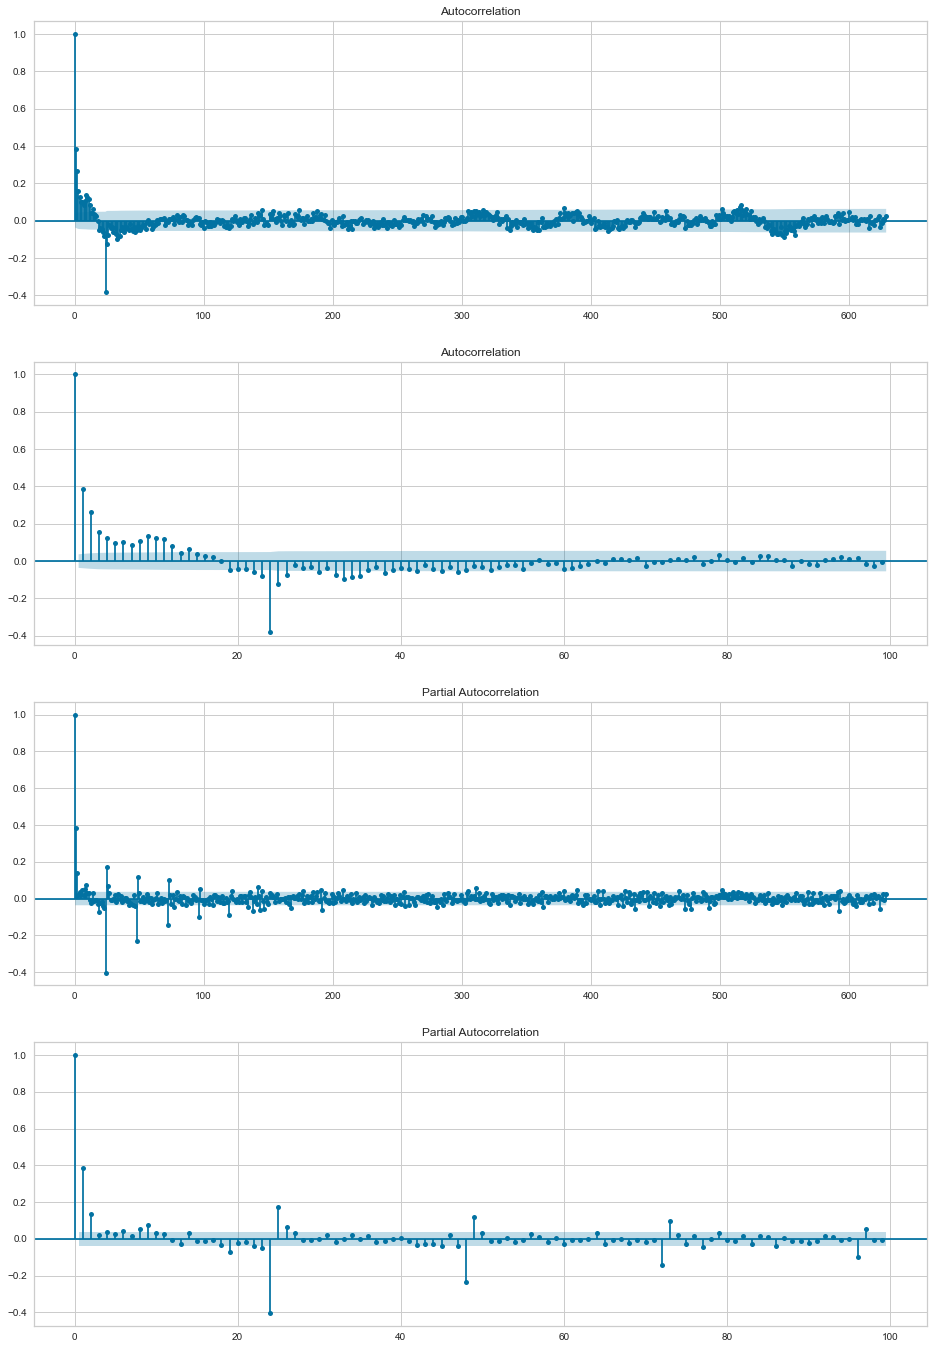

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 2 end of analysis
Cluster 3 analysis
R-squared: 0.7558778196455423
AIC: 18365.35099975672


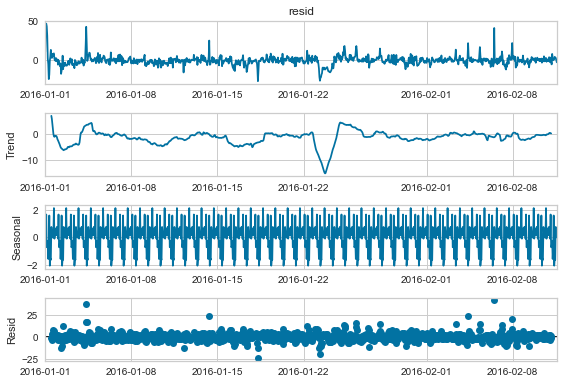

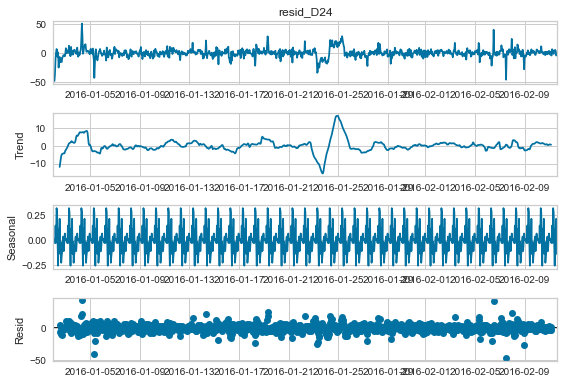

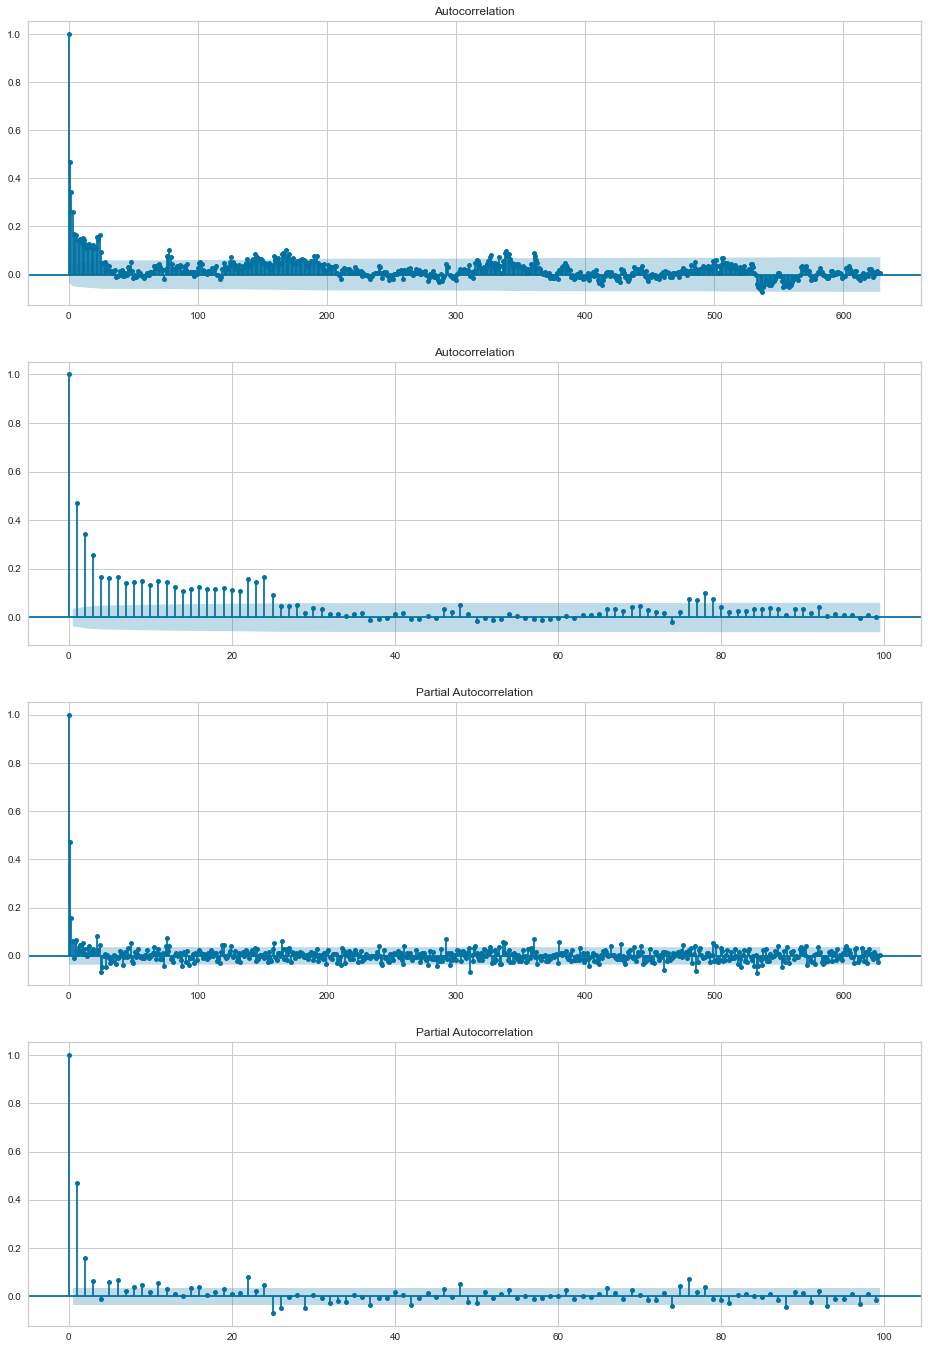

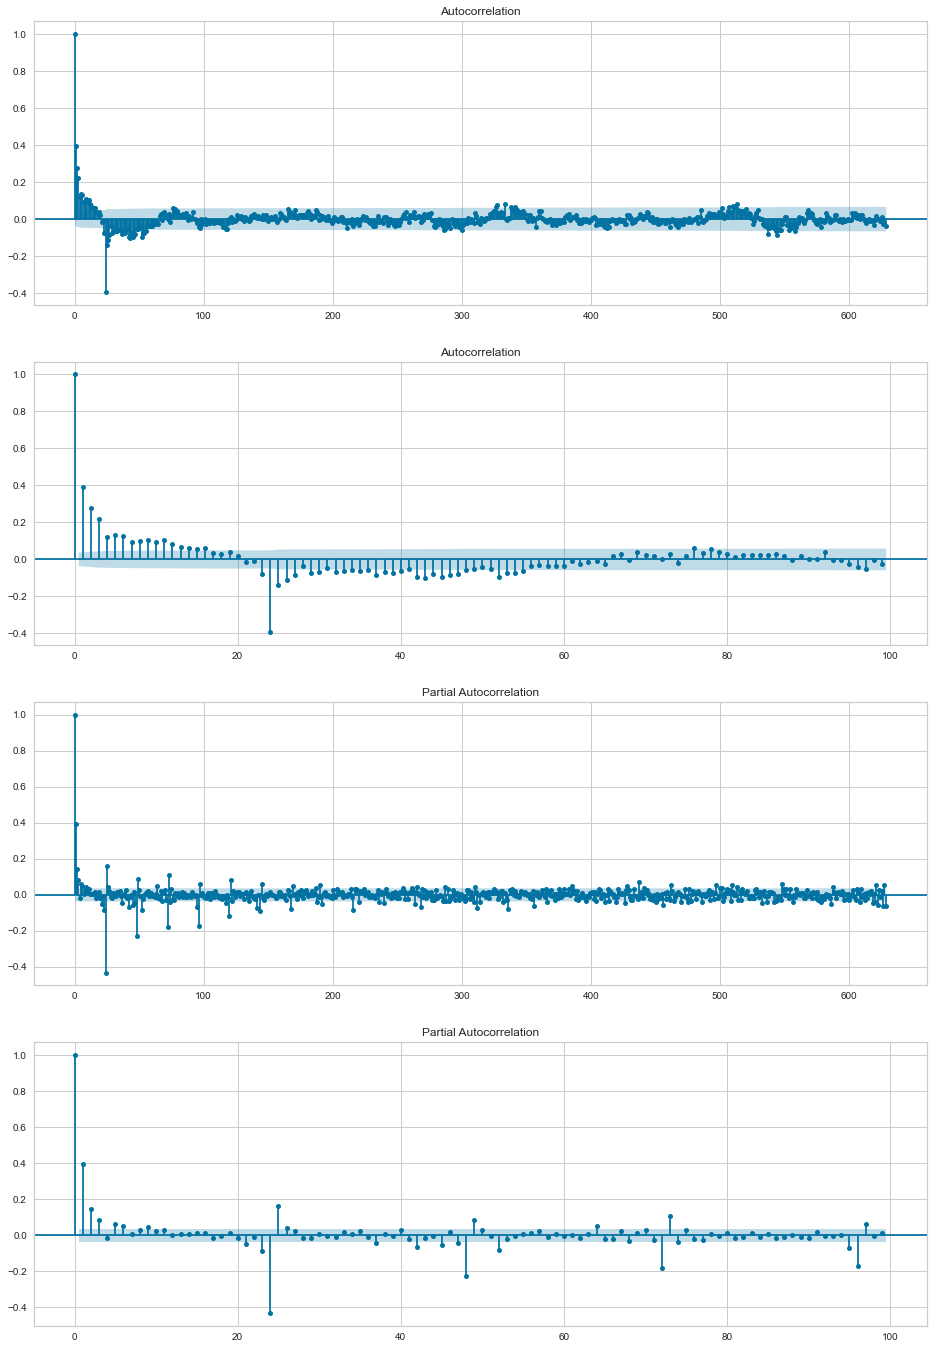

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 3 end of analysis
Cluster 4 analysis
R-squared: 0.8593679329496743
AIC: 33596.390306222136


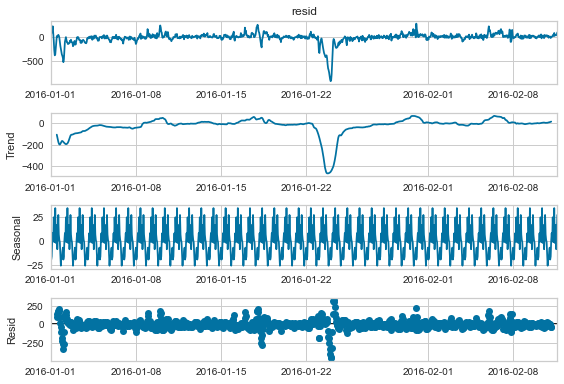

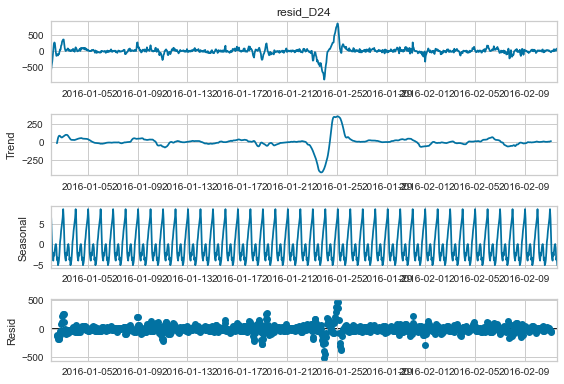

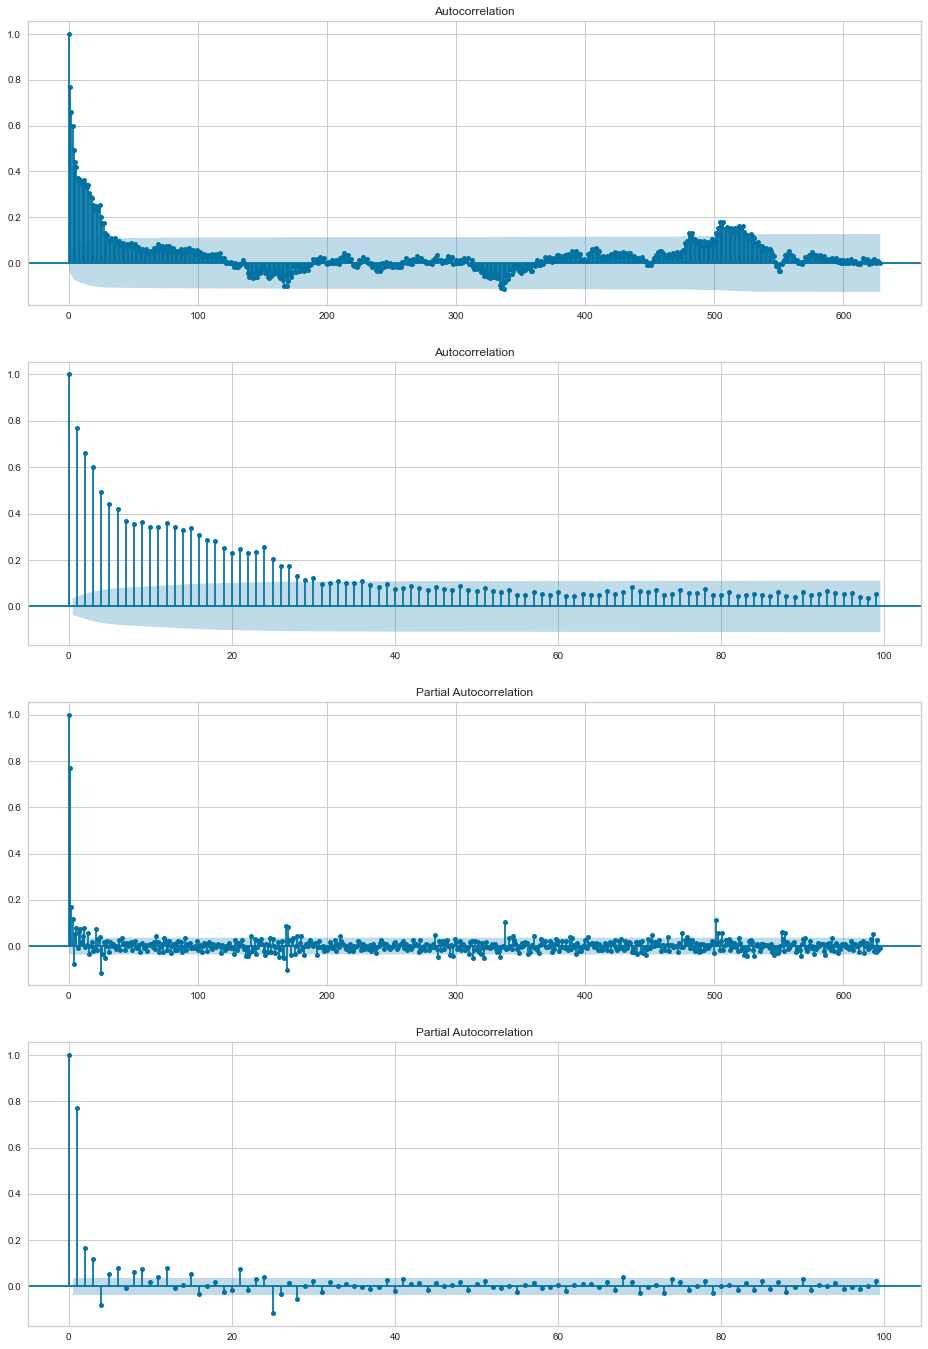

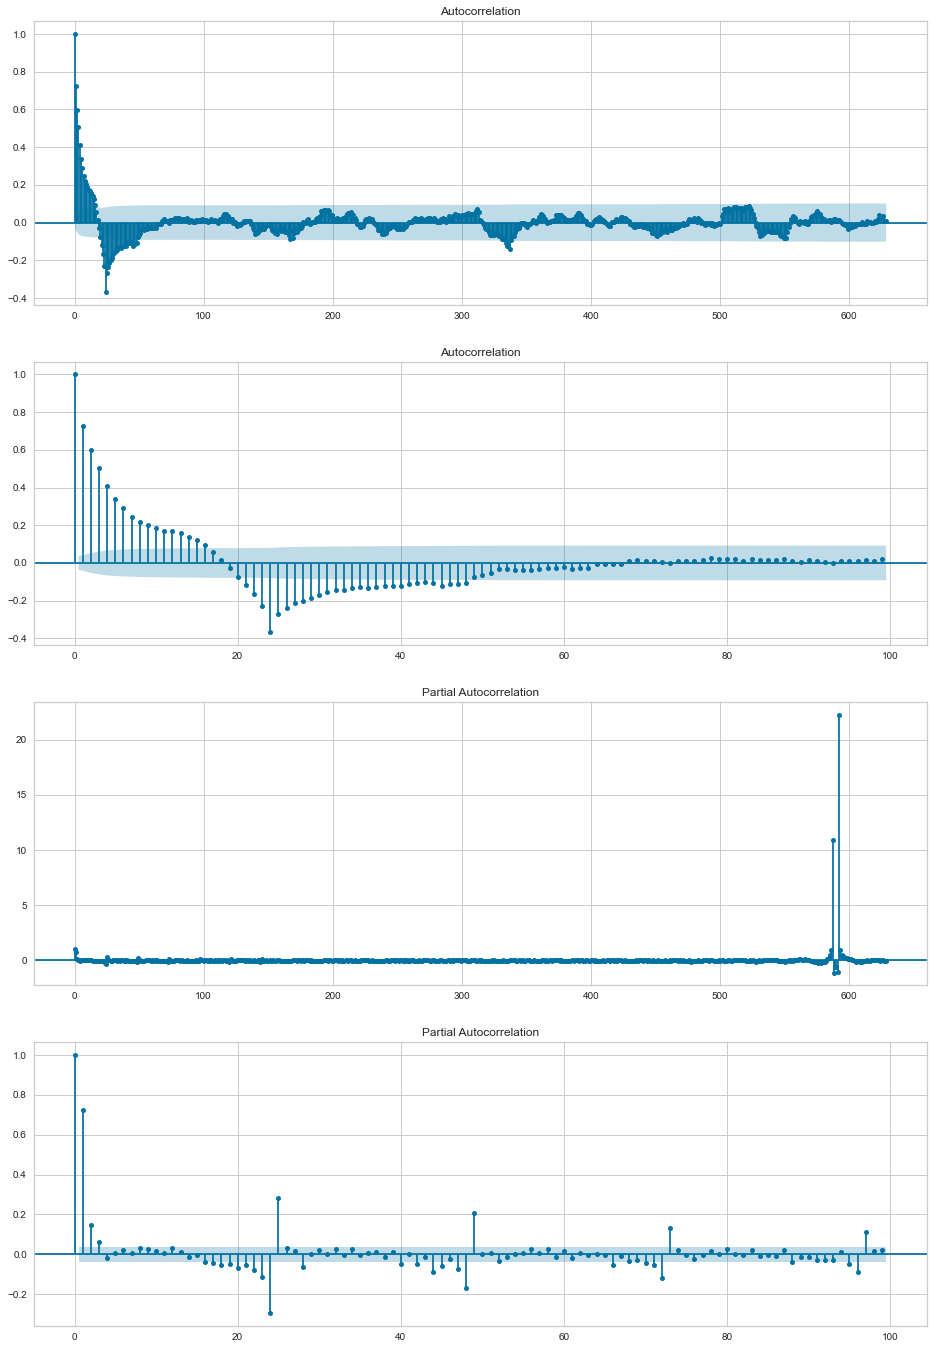

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 4 end of analysis
Cluster 5 analysis
R-squared: 0.9104703276785266
AIC: 34509.39139526296


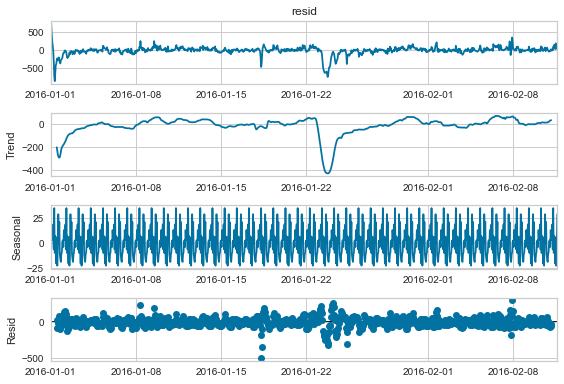

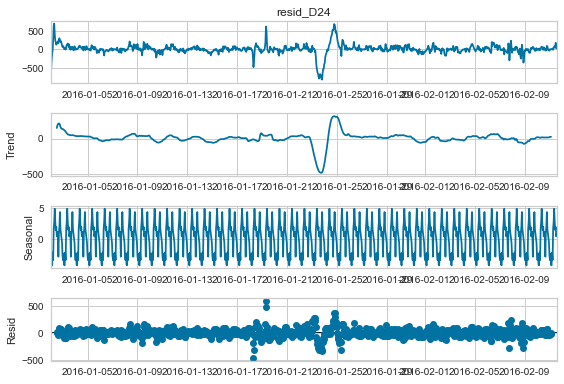

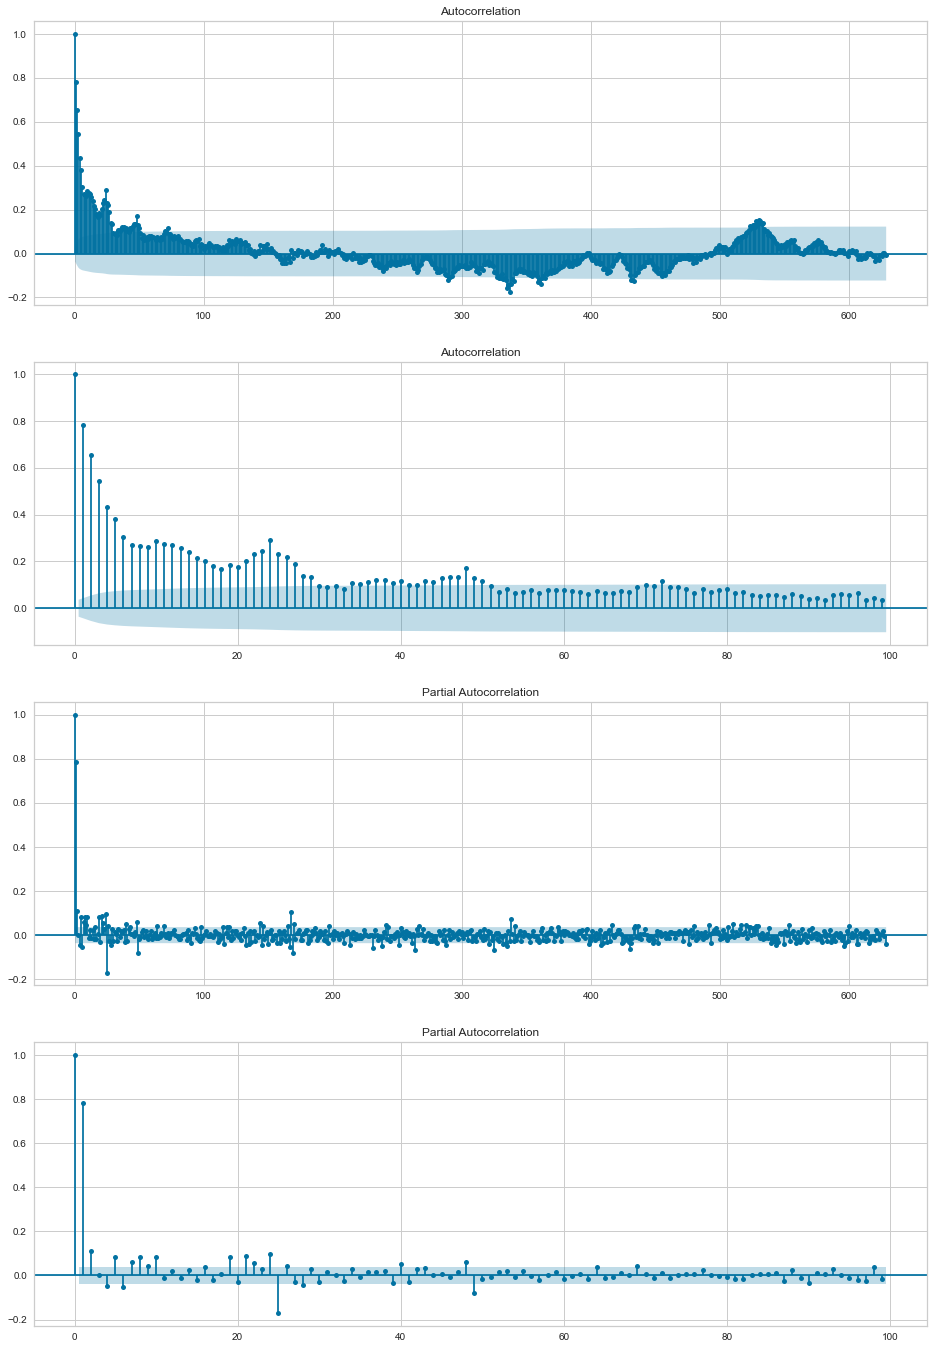

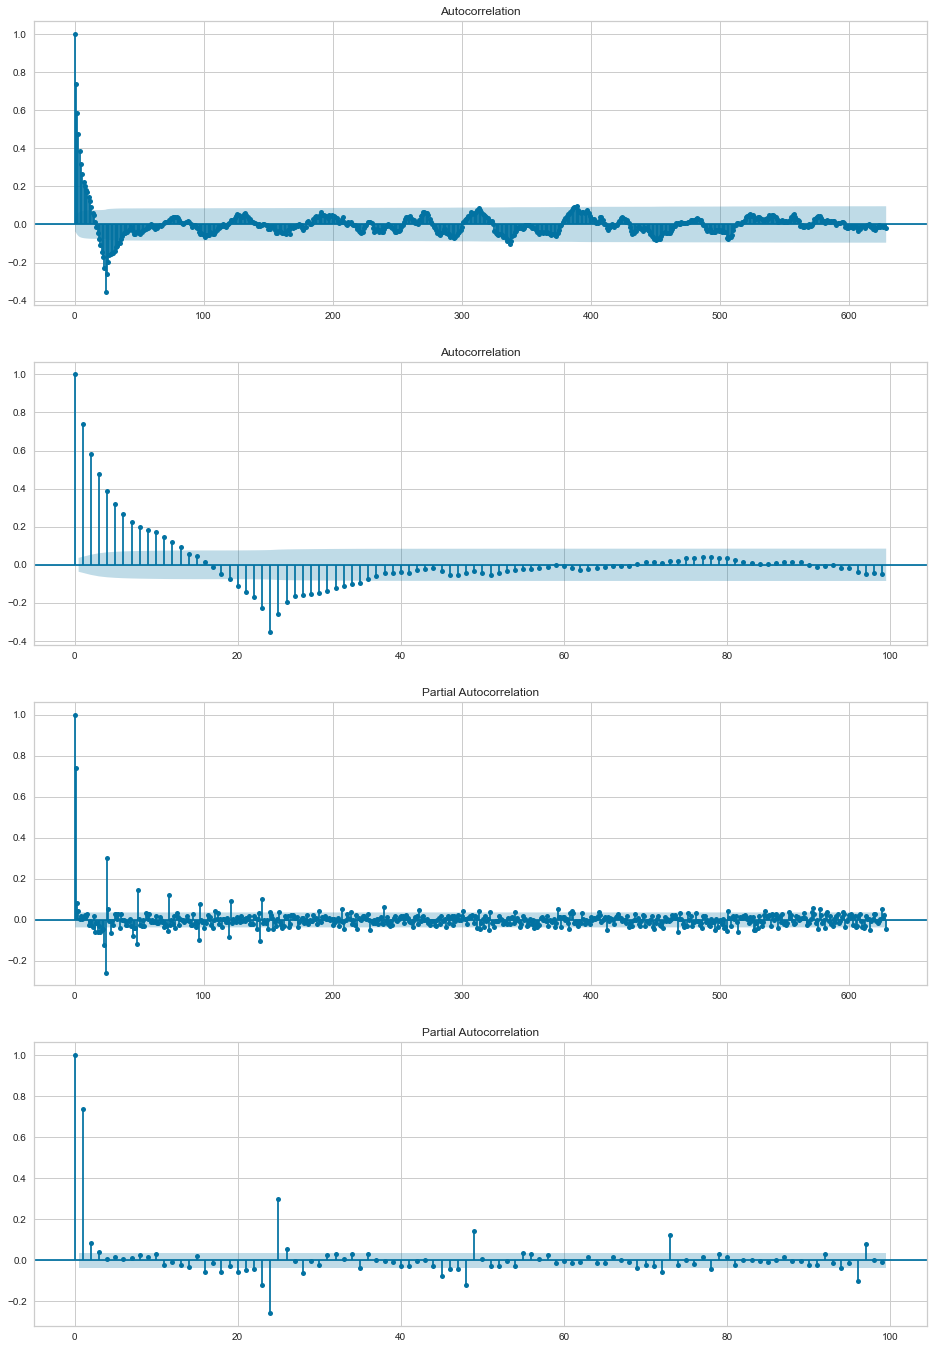

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 5 end of analysis
Cluster 6 analysis
R-squared: 0.8870690255666679
AIC: 35088.25491206316


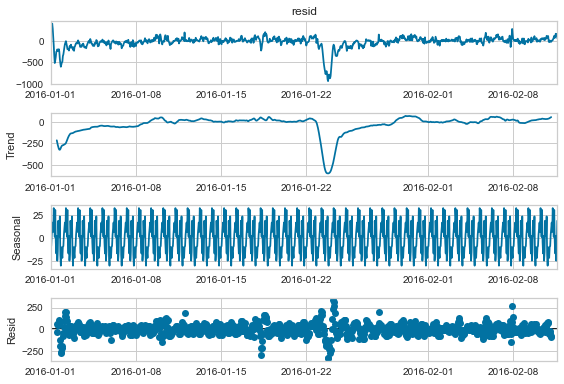

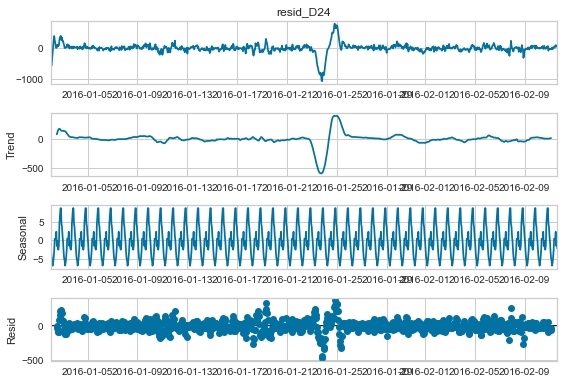

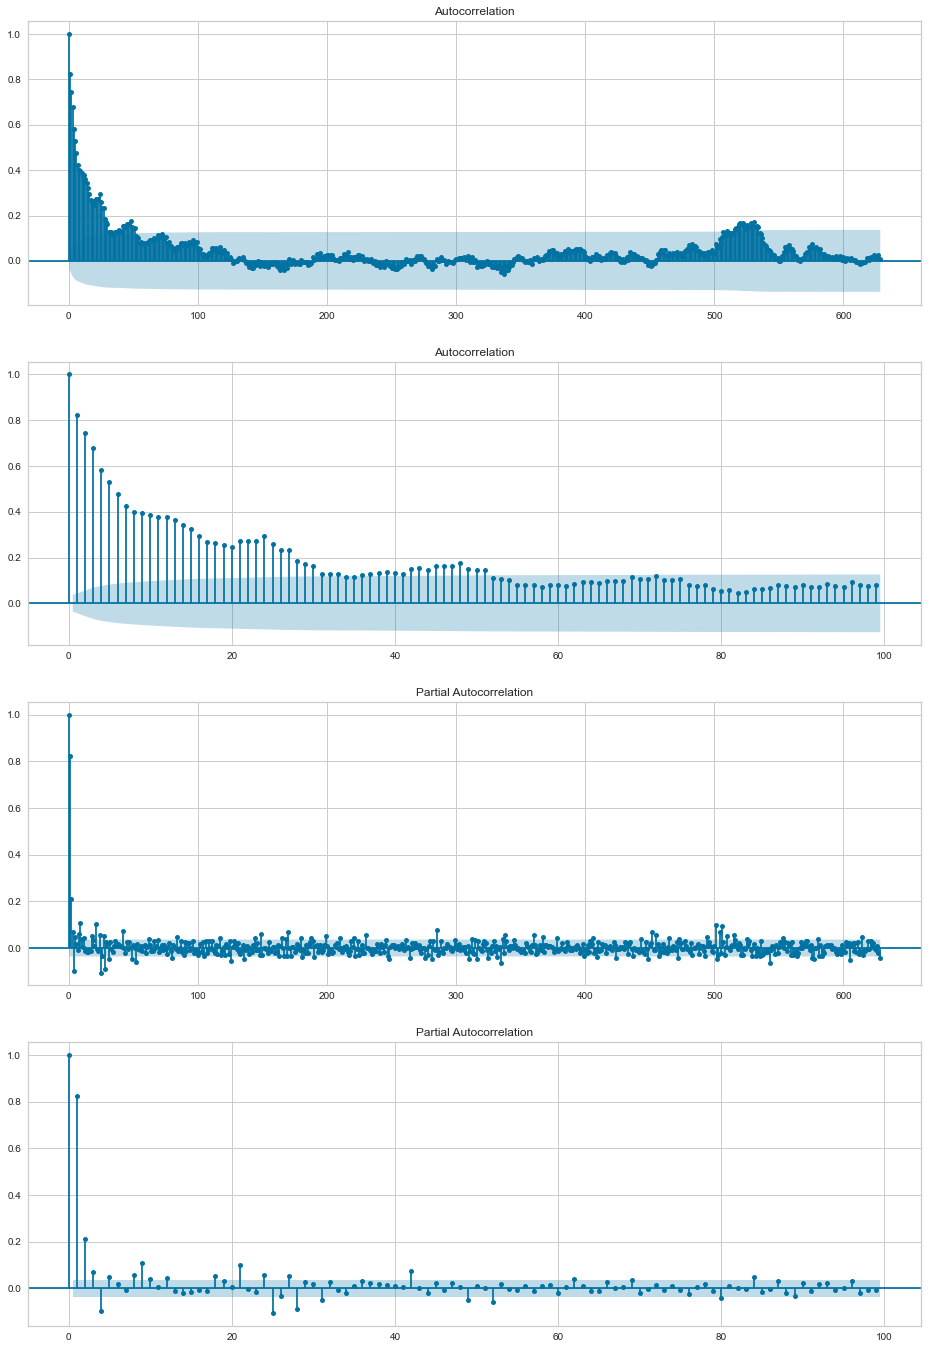

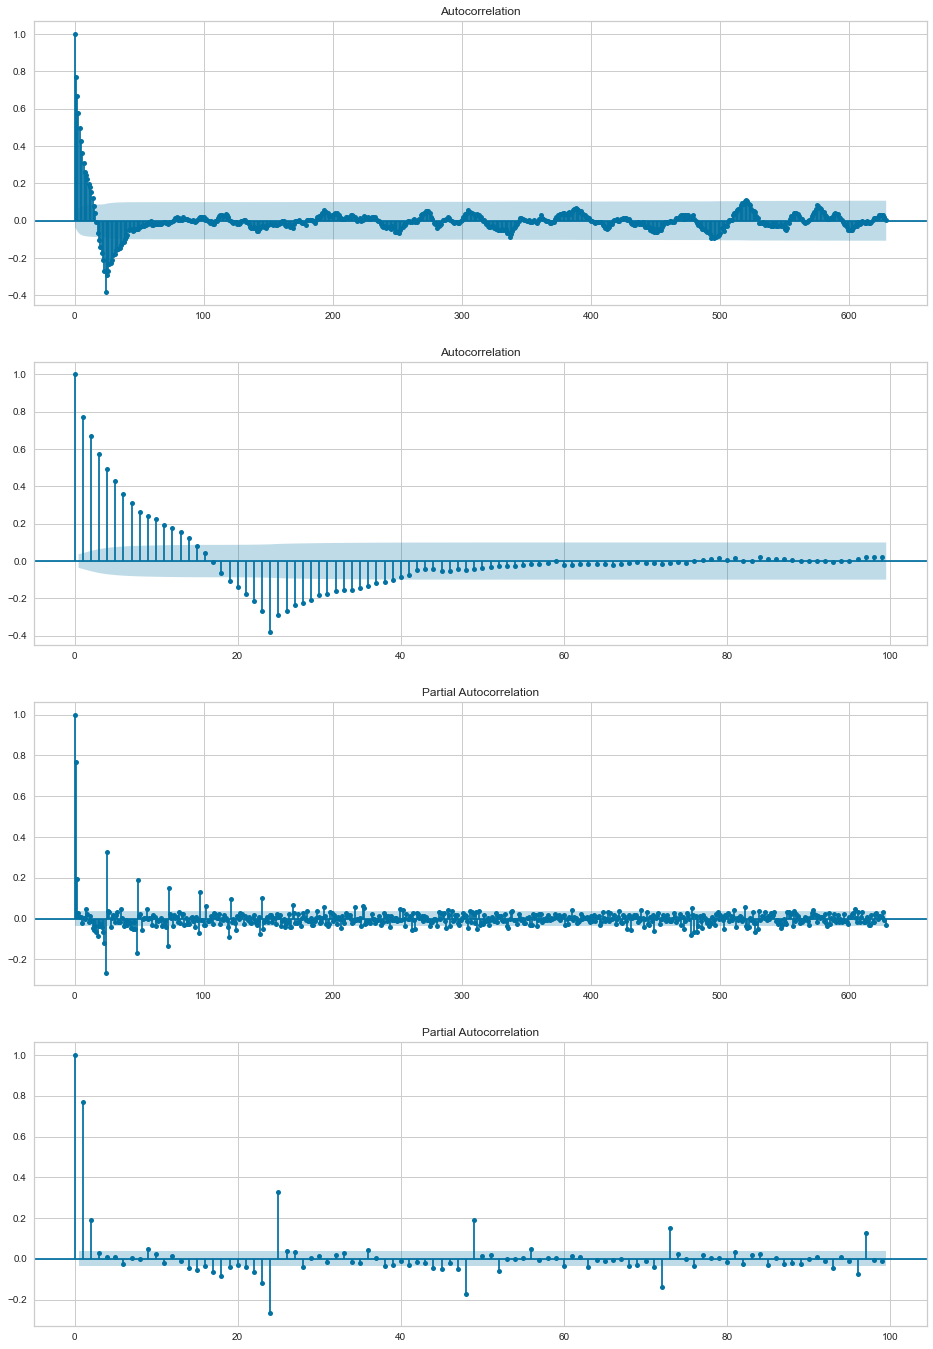

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 6 end of analysis


In [29]:
for cluster_number in range(7):
    seeking_of_parameters(cluster_number, 51)

## Как видно из проведенного анализа для кластеров с равным количеством экзогенных переменных-некоторые значения R-squared весьма посредственные. Добавим больше искусственно созданных переменных для анализа некоторых кластеров. Это кластера под индексами 1, 2, 3

Cluster 1 analysis
R-squared: 0.7129839217758618
AIC: 18819.664043954635


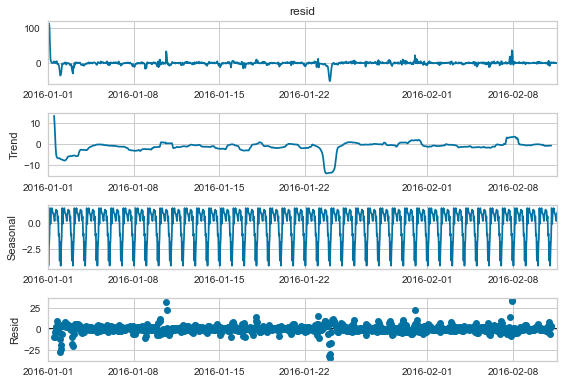

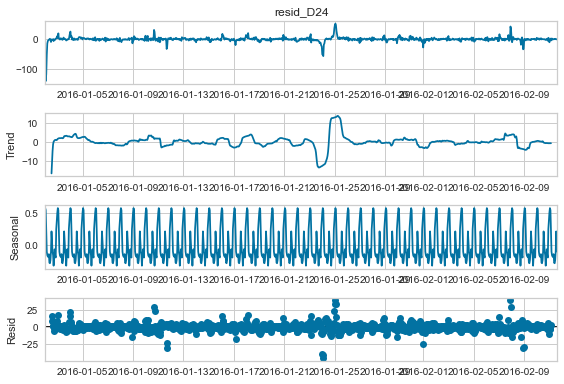

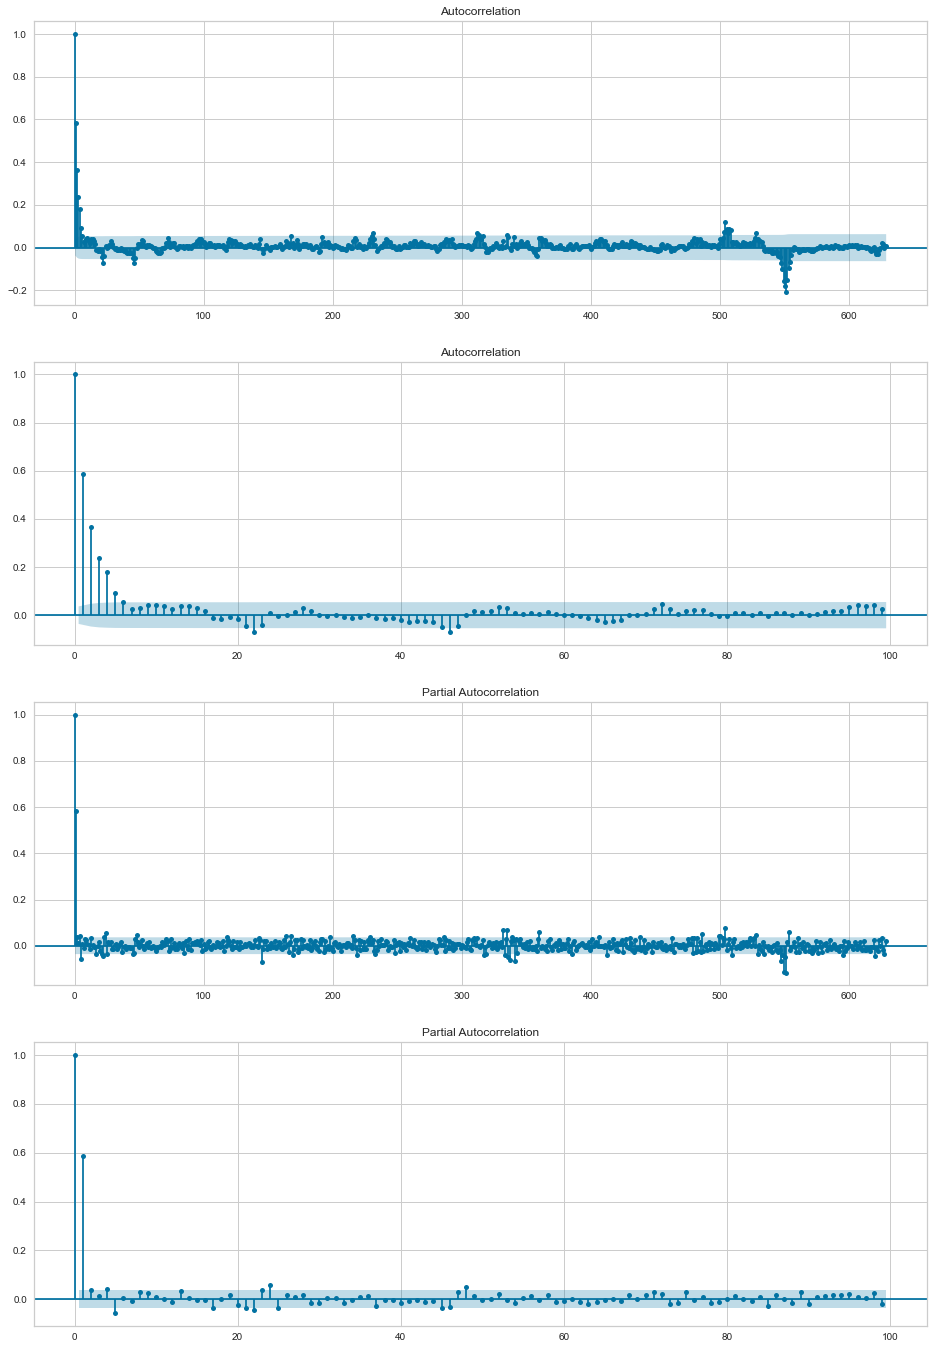

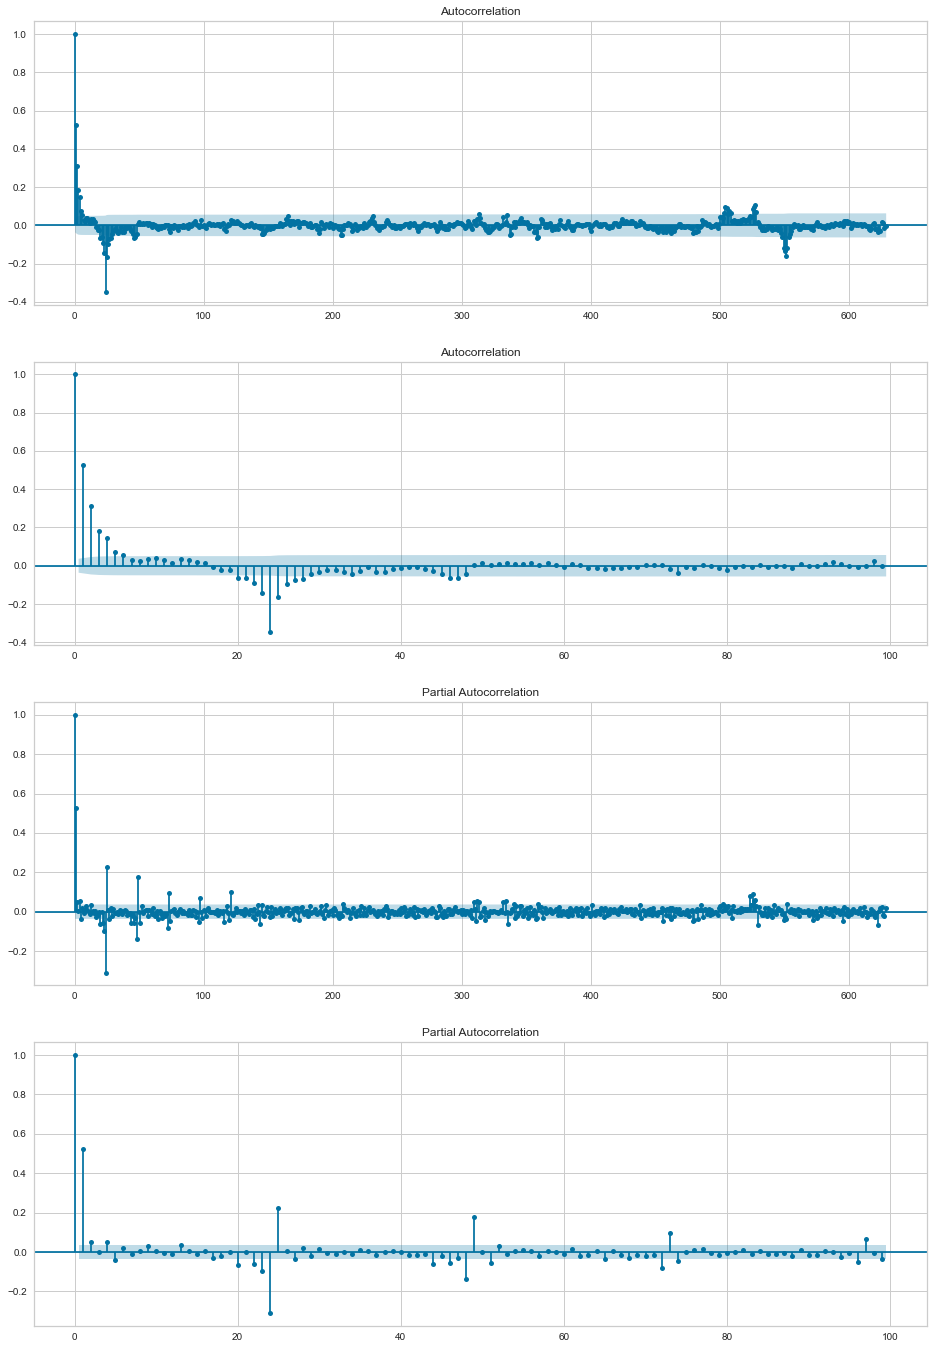

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 1 end of analysis
Cluster 2 analysis
R-squared: 0.6307757715917921
AIC: 21640.790675774057


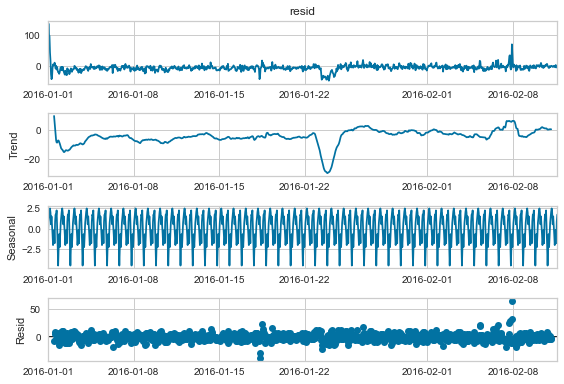

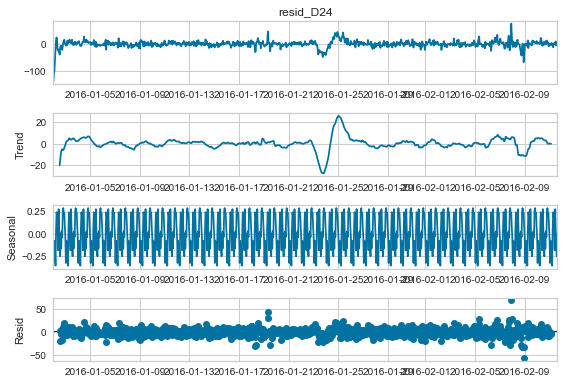

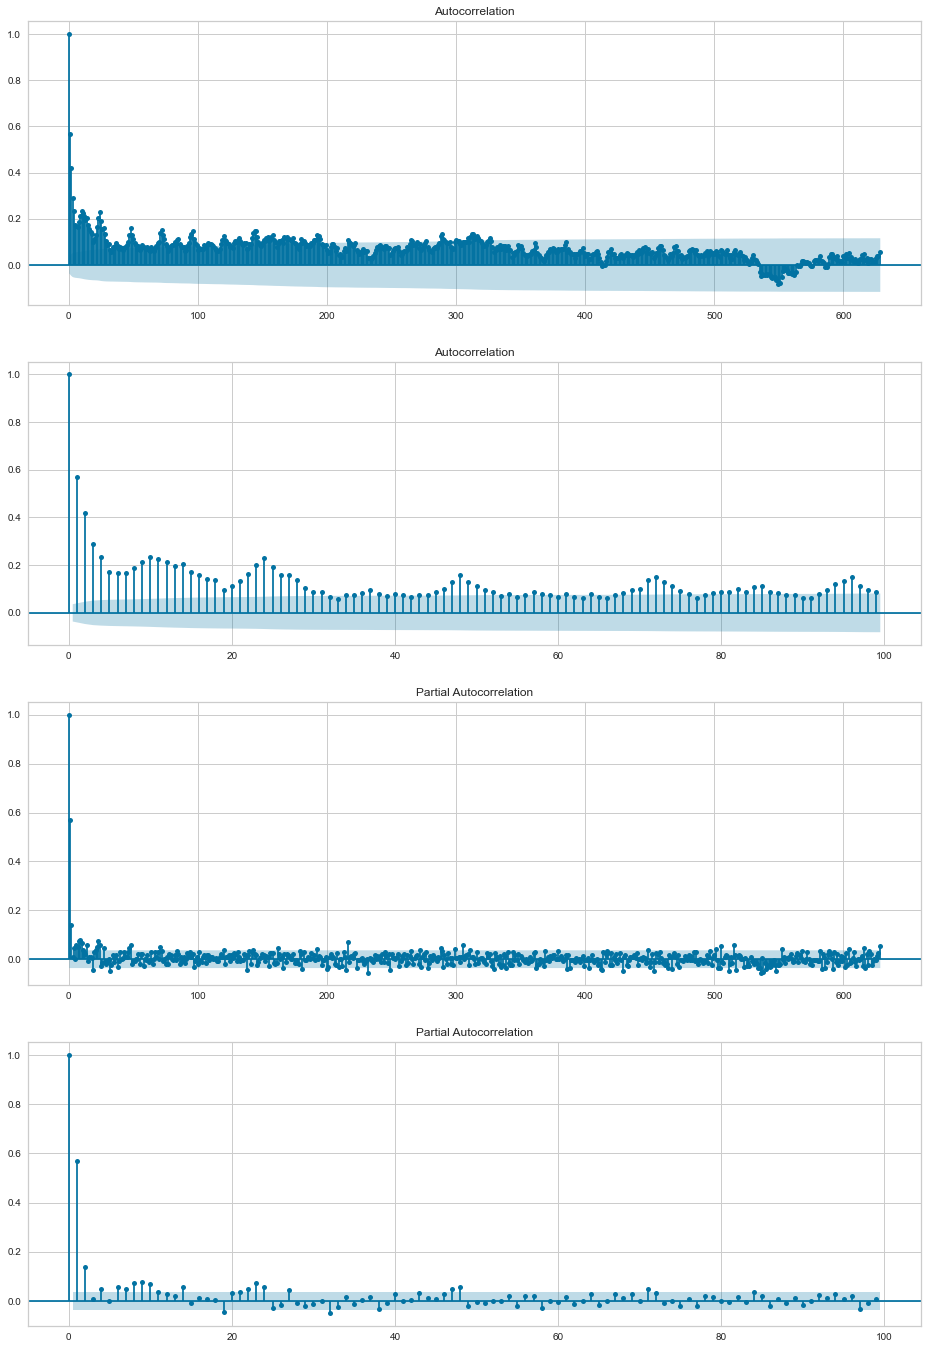

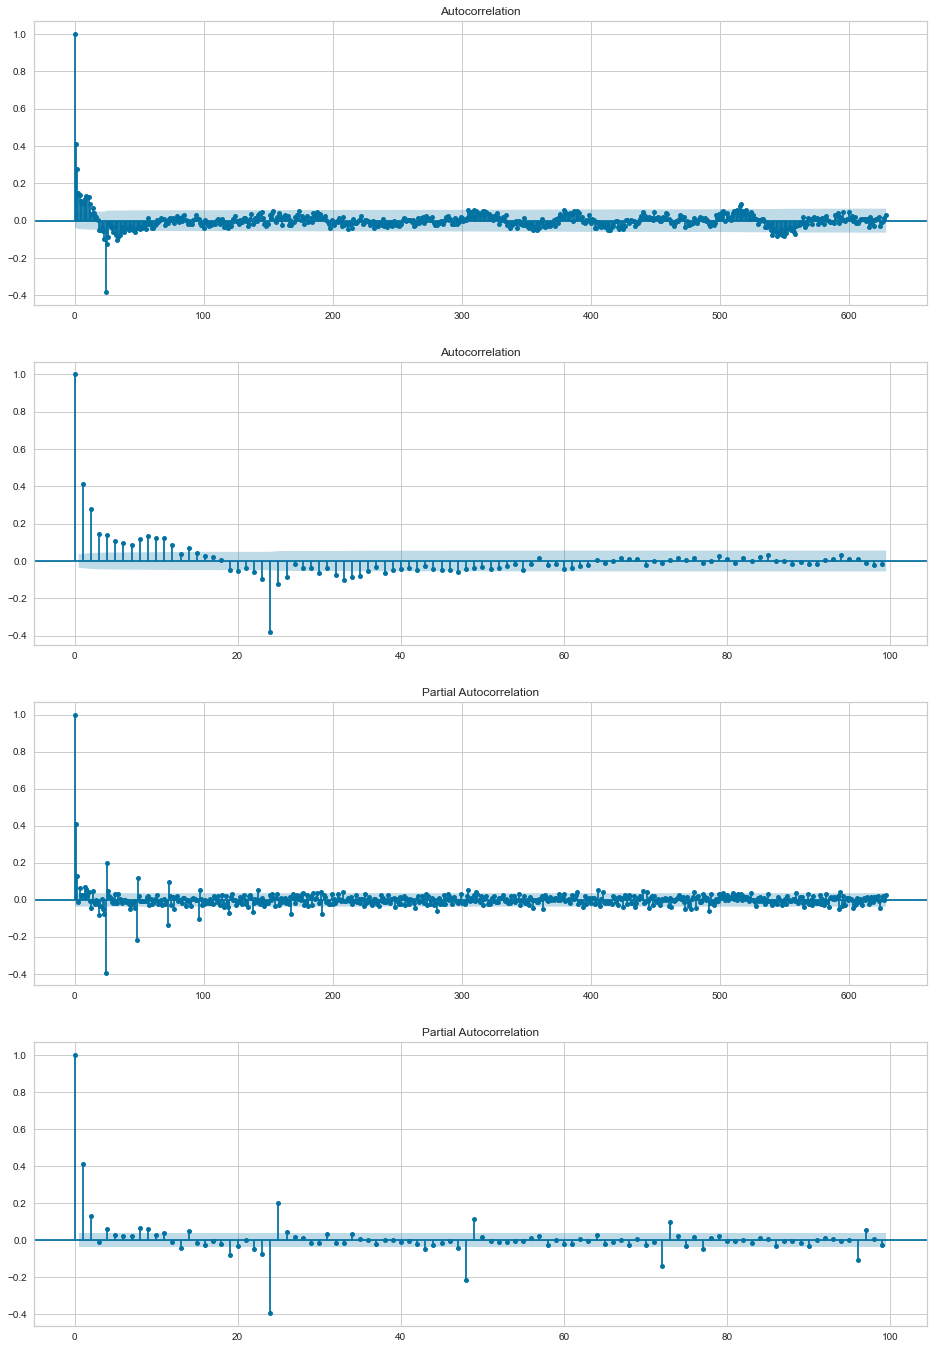

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 2 end of analysis
Cluster 3 analysis
R-squared: 0.7588859229887935
AIC: 18358.096756773375


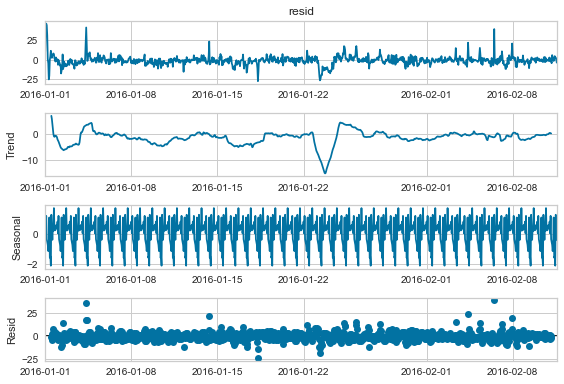

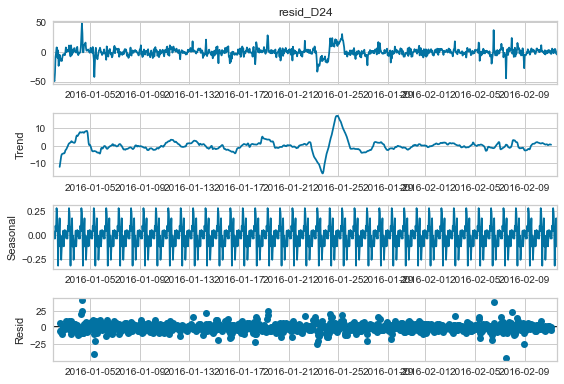

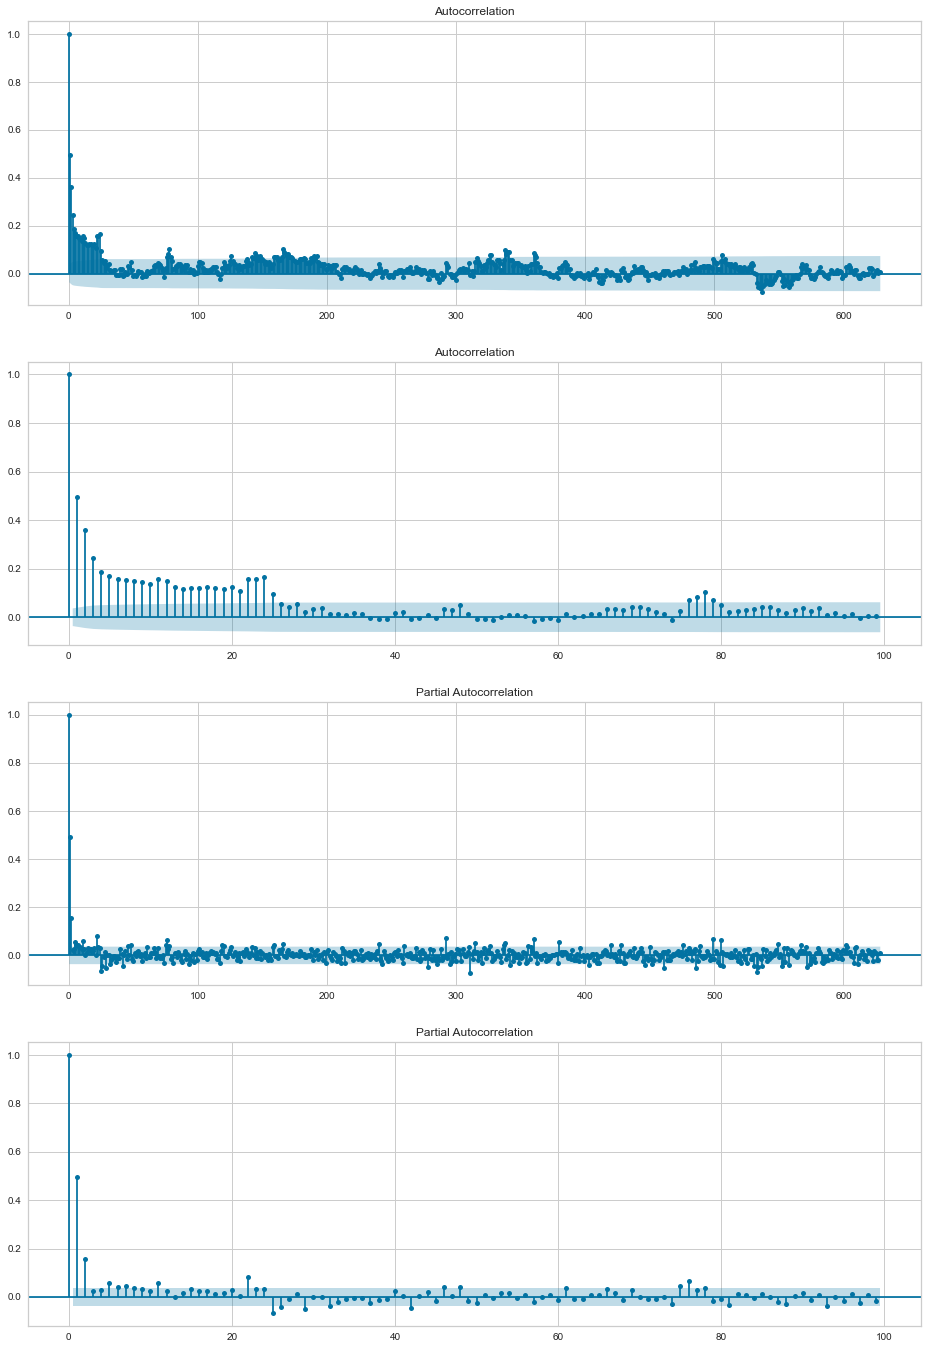

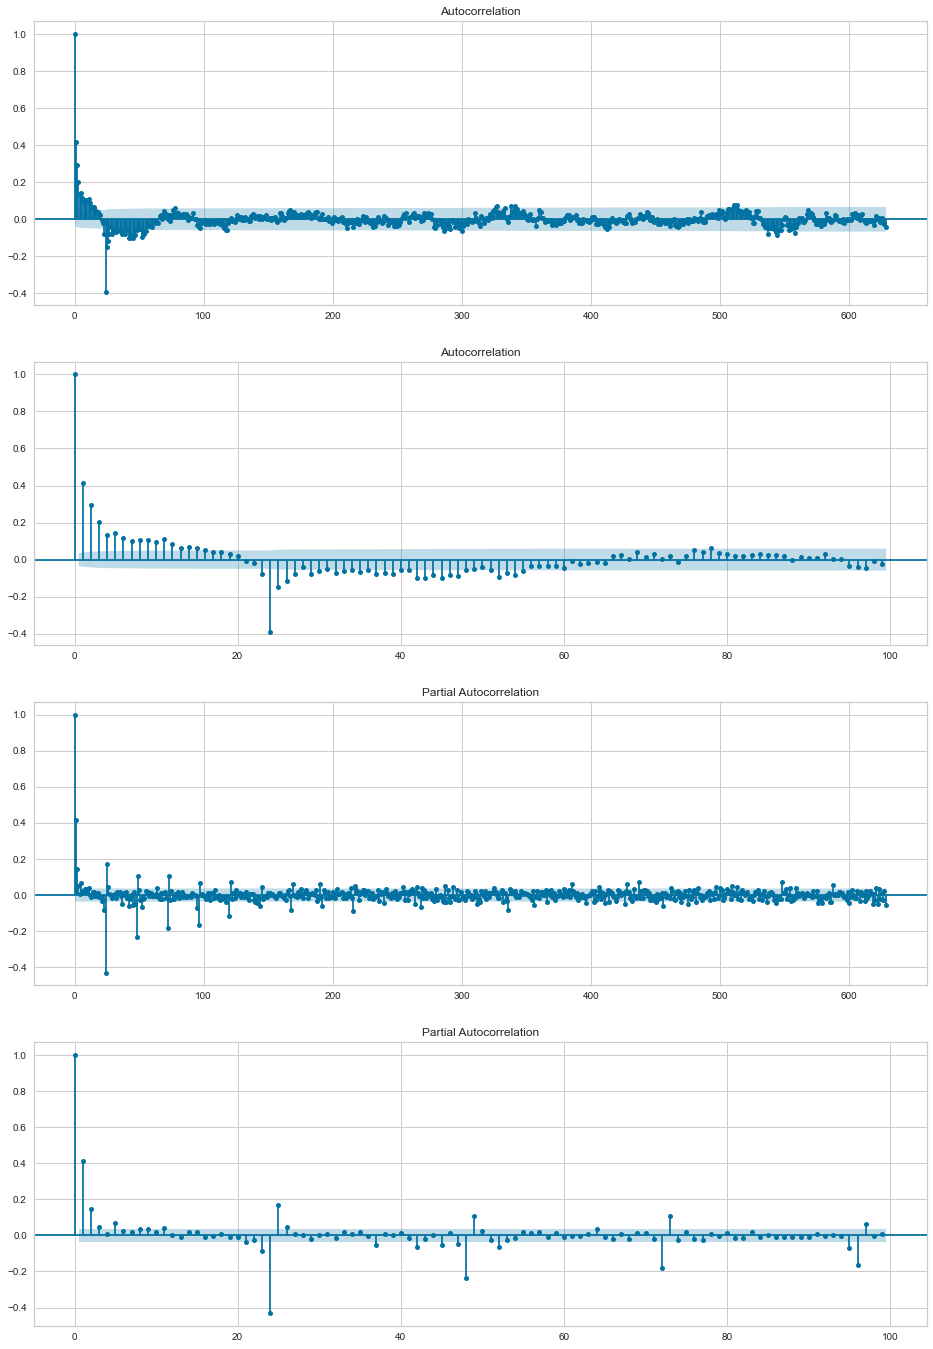

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 3 end of analysis


In [30]:
for cluster_number, n_of_exog in zip([1, 2, 3], [31, 81, 66]):
    seeking_of_parameters(cluster_number, n_of_exog)

## После эмпирического подбора n-кластеров улучшения результатов не предвиделось. Попробуем построить алгоритм, который будет минимизировать критерий информативности AIC и тем самым подбирать оптимальное количество экзогенных переменных

In [31]:
def prepair_for_ARIMA_clusters(clust,k=51):
    dataset=pd.DataFrame(df[inds[clust]].values,index=pd.to_datetime(df.index), columns={'count'})
    #dataset['time']=df.index
    #cluster0.head()
    w=168 # длительность недели в часах
    t=np.arange(1, dataset.shape[0]+1)
    dataset['constant']=np.ones(dataset.shape[0])
    for i in range(1,k):
        sin="s"+str(i)
        cos="c"+str(i)
        dataset[sin]=np.sin(2*i*np.pi*t/w)
        dataset[cos]=np.cos(2*i*np.pi*t/w)
    #dataset['time']=pd.to_datetime(dataset['time'])
    #for j in range(wheather.shape[0]):
    #    w='wh_'+str(j)
    #    dataset[w]=0
    #for i in range(dataset.shape[0]):
    #    for j in range(wheather.shape[0]):
    #        w='wh_'+str(j)
    #        if ((dataset['time'].iloc[i].year==wheather[j].year)&(dataset['time'].iloc[i].month==wheather[j].month)&(dataset['time'].iloc[i].day== wheather[j].day)):
    #            dataset[w].iloc[i]=1
    model0=sm.OLS(dataset['count'], dataset.drop(['count'], axis=1)).fit()
    return model0.rsquared_adj, model0.aic
    #print(f'R-squared: {model0.rsquared_adj}')
    #print(f'AIC: {model0.aic}')

In [32]:
for cluster in range(7):
    aic = 1e+20
    r = 0
    ex = 0
    for exog_num in range(11, 112, 5):
        r_, aic_ = prepair_for_ARIMA_clusters(cluster, k=exog_num)
        if aic_ < aic:
            aic = aic_
            r = r_
            ex = exog_num
    print(f"Best number of exog variables for cluster {cluster} with R-squared: {r_}, AIC: {aic} is: {ex}")

Best number of exog variables for cluster 0 with R-squared: 0.8190072372917213, AIC: 26999.415825852888 is: 71
Best number of exog variables for cluster 1 with R-squared: 0.7094877494862589, AIC: 18819.664043954635 is: 31
Best number of exog variables for cluster 2 with R-squared: 0.6281074262680215, AIC: 21604.452158866286 is: 66
Best number of exog variables for cluster 3 with R-squared: 0.7588794136073121, AIC: 18358.096756773375 is: 66
Best number of exog variables for cluster 4 with R-squared: 0.8575994824544491, AIC: 33580.571897840906 is: 36
Best number of exog variables for cluster 5 with R-squared: 0.9100262850810265, AIC: 34509.39139526296 is: 51
Best number of exog variables for cluster 6 with R-squared: 0.8850593731369474, AIC: 35079.448403598886 is: 46


## Теперь проведем те же исследования, но теперь со скорректированными значениями количества экзогенных переменных.

Cluster 0 analysis
R-squared: 0.8194676390026743
AIC: 26999.415825852888


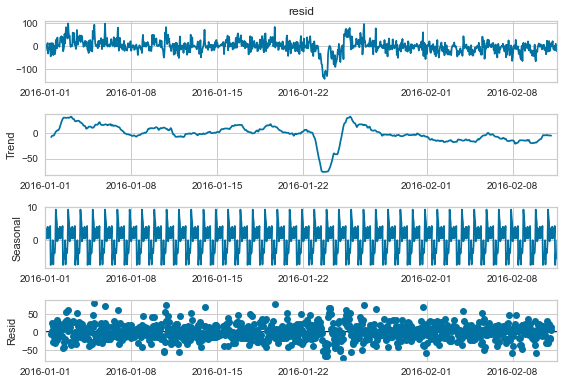

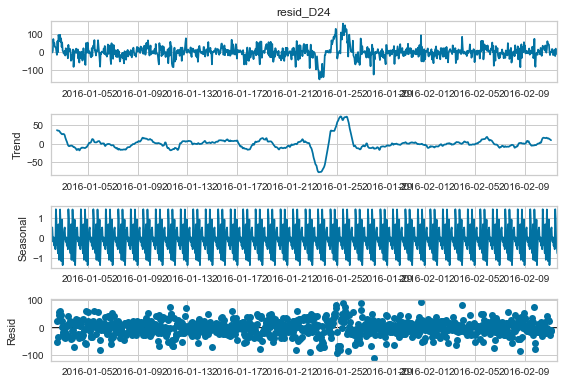

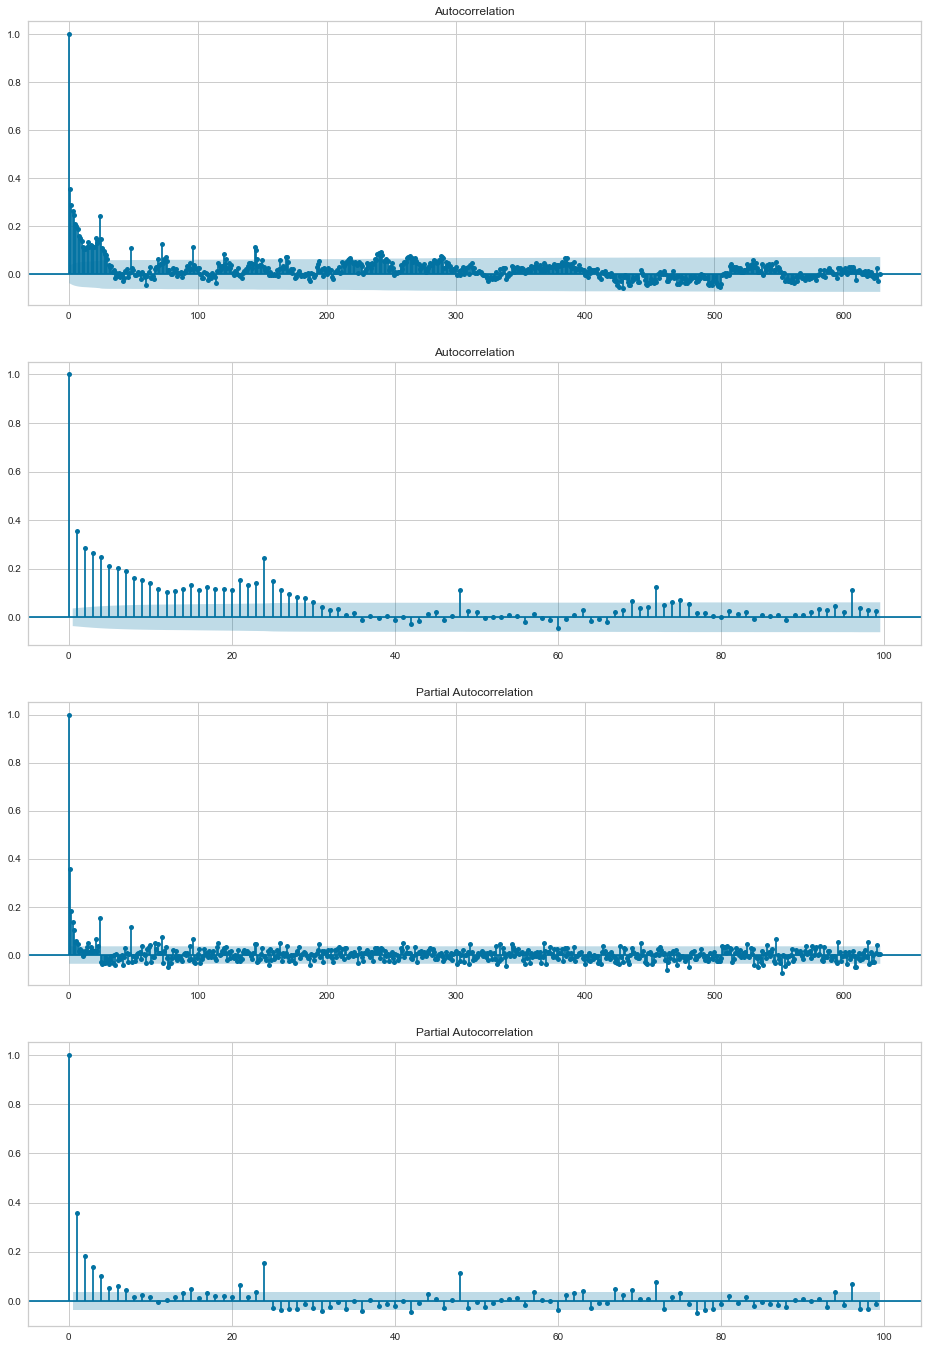

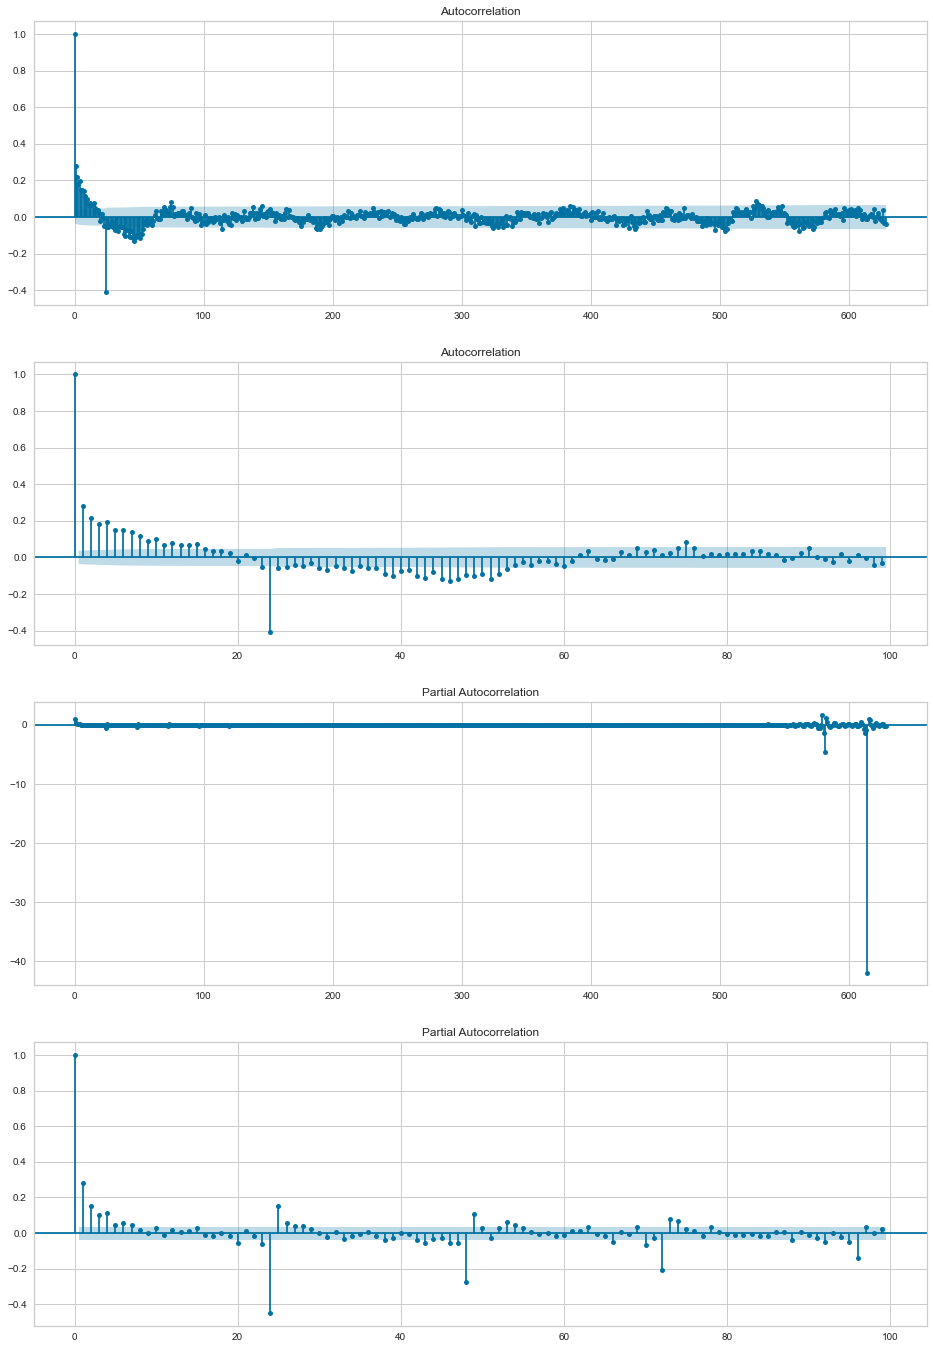

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 0 end of analysis
Cluster 1 analysis
R-squared: 0.7129839217758618
AIC: 18819.664043954635


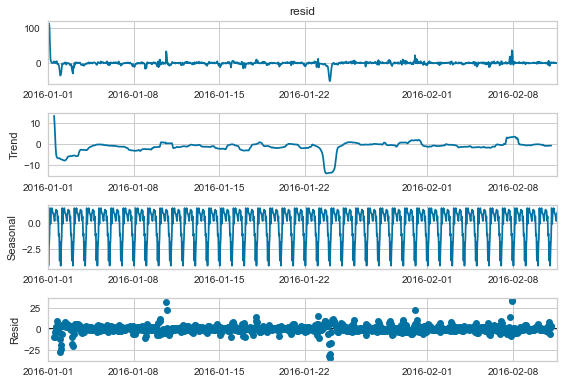

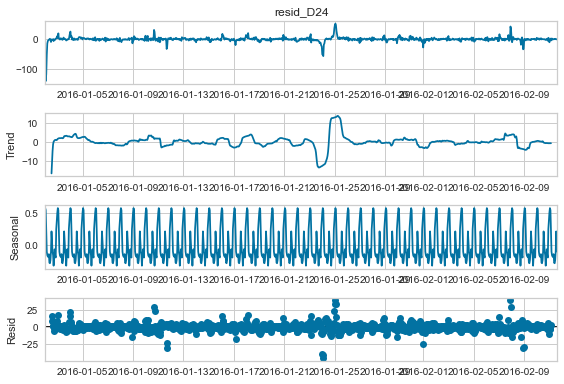

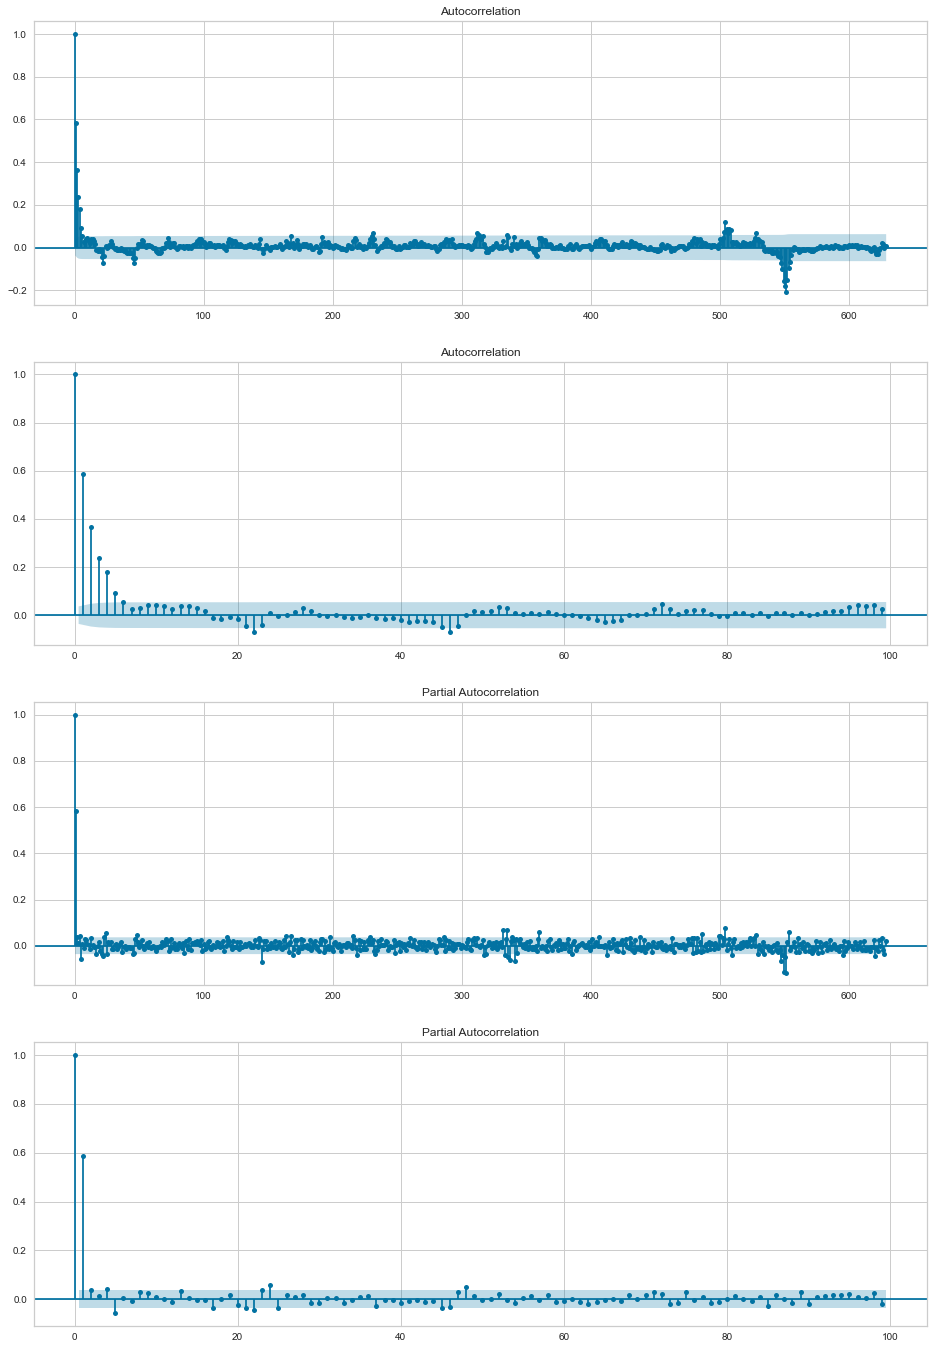

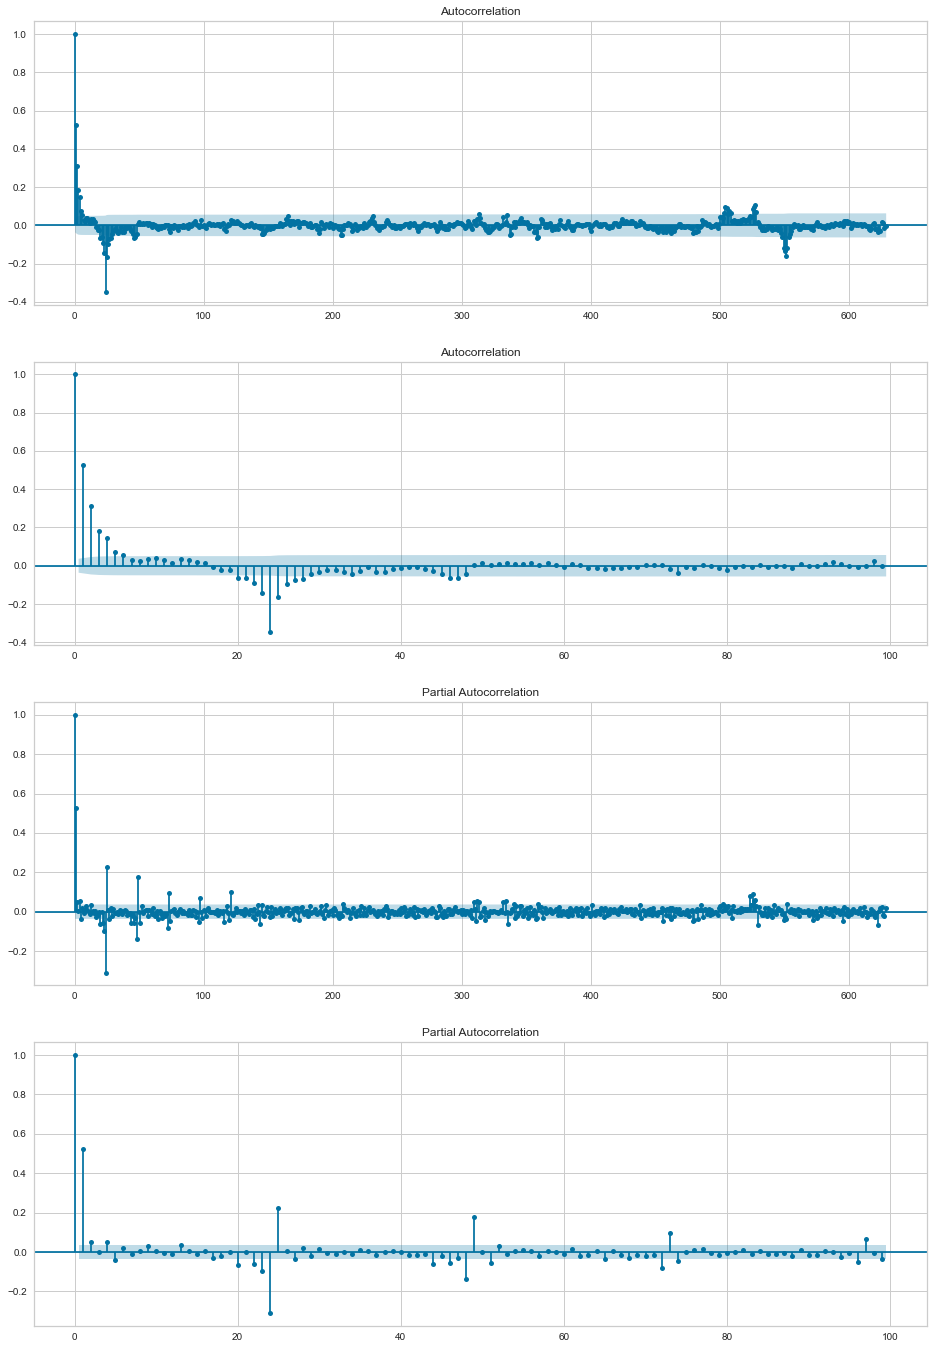

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 1 end of analysis
Cluster 2 analysis
R-squared: 0.6317822542840534
AIC: 21604.452158866286


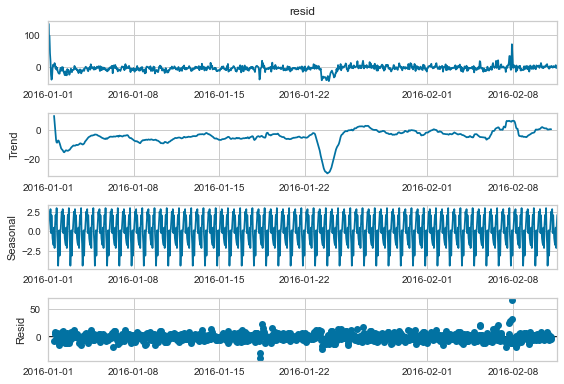

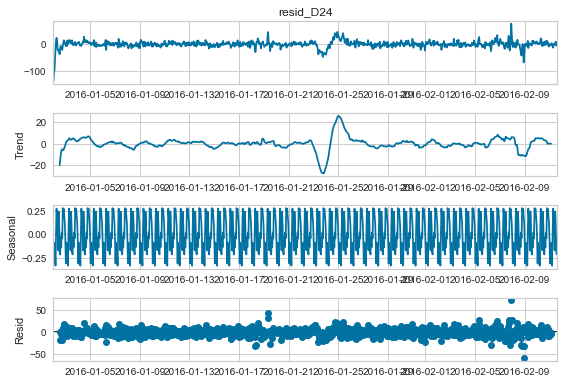

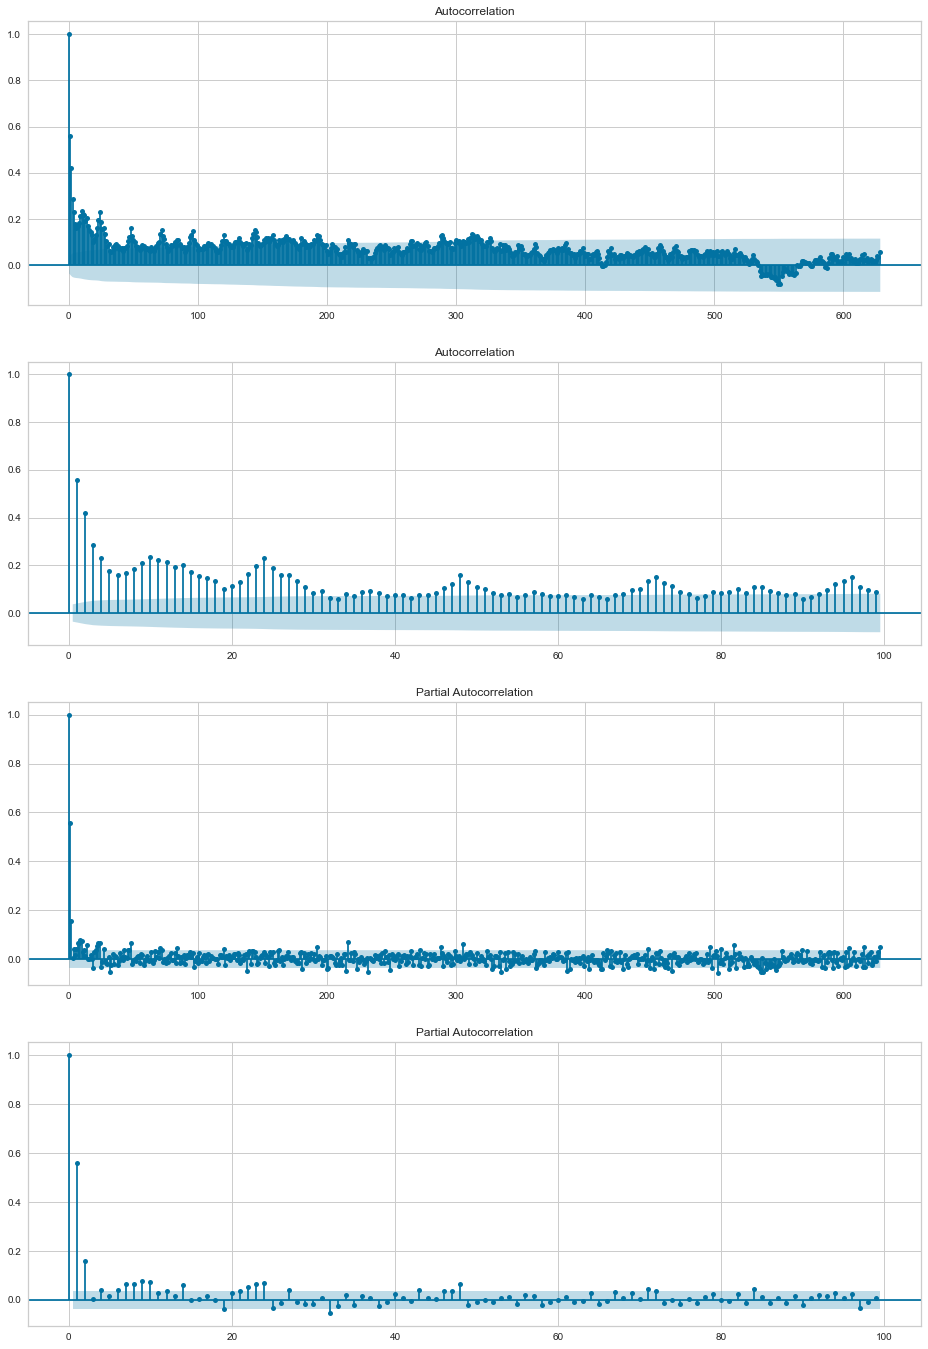

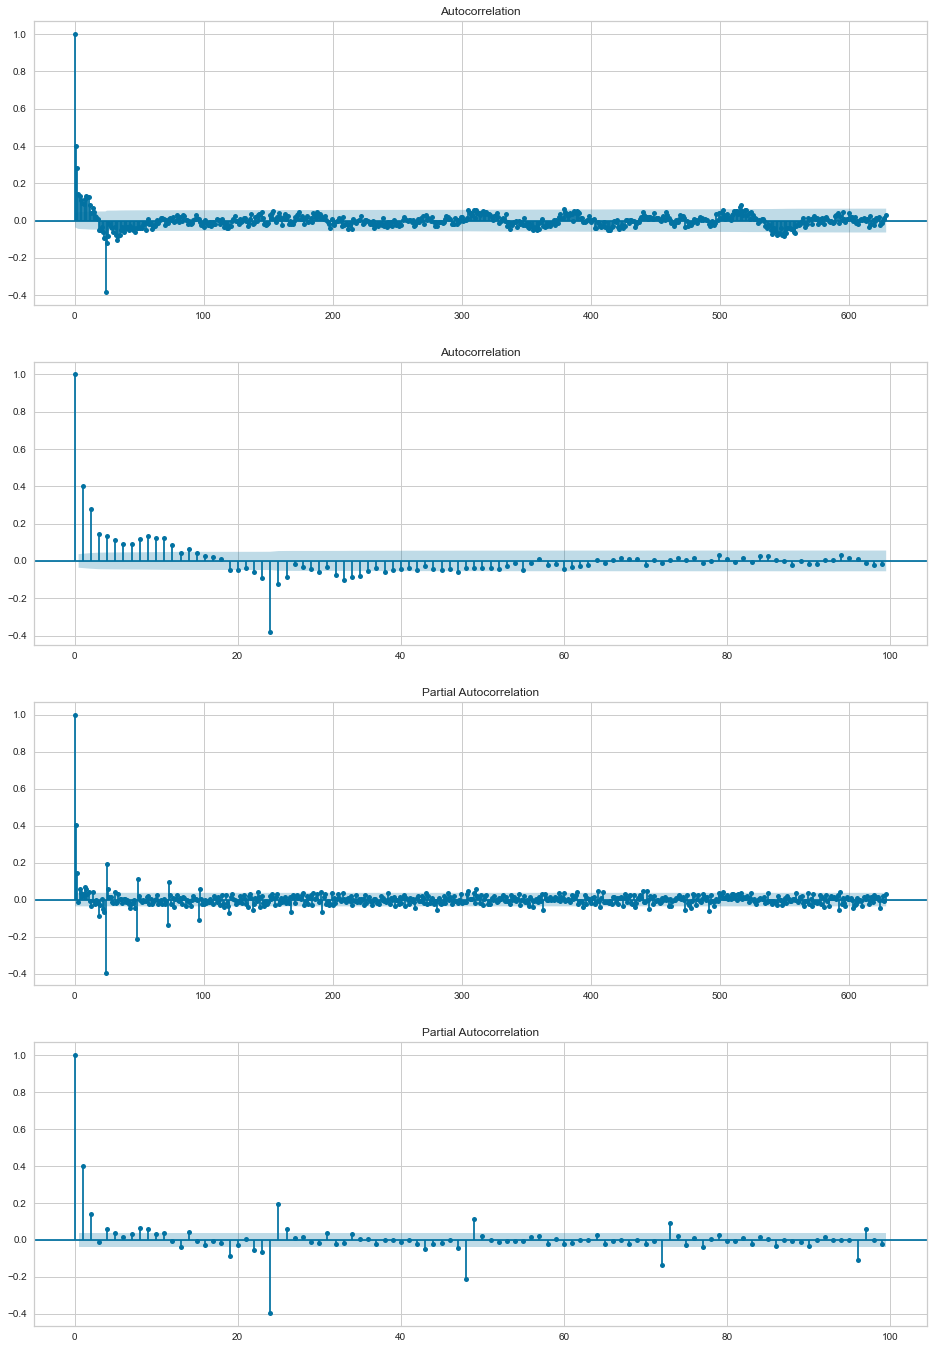

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 2 end of analysis
Cluster 3 analysis
R-squared: 0.7588859229887935
AIC: 18358.096756773375


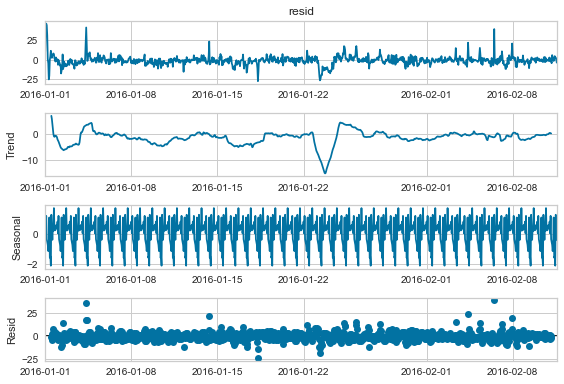

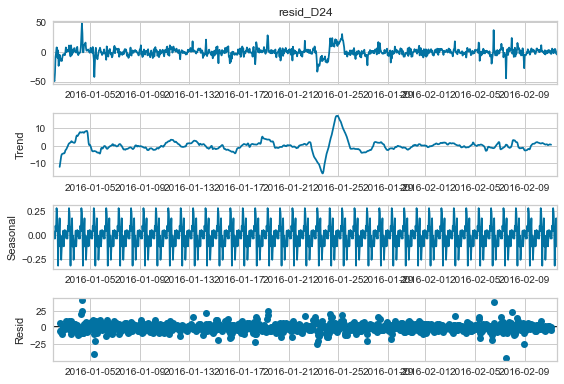

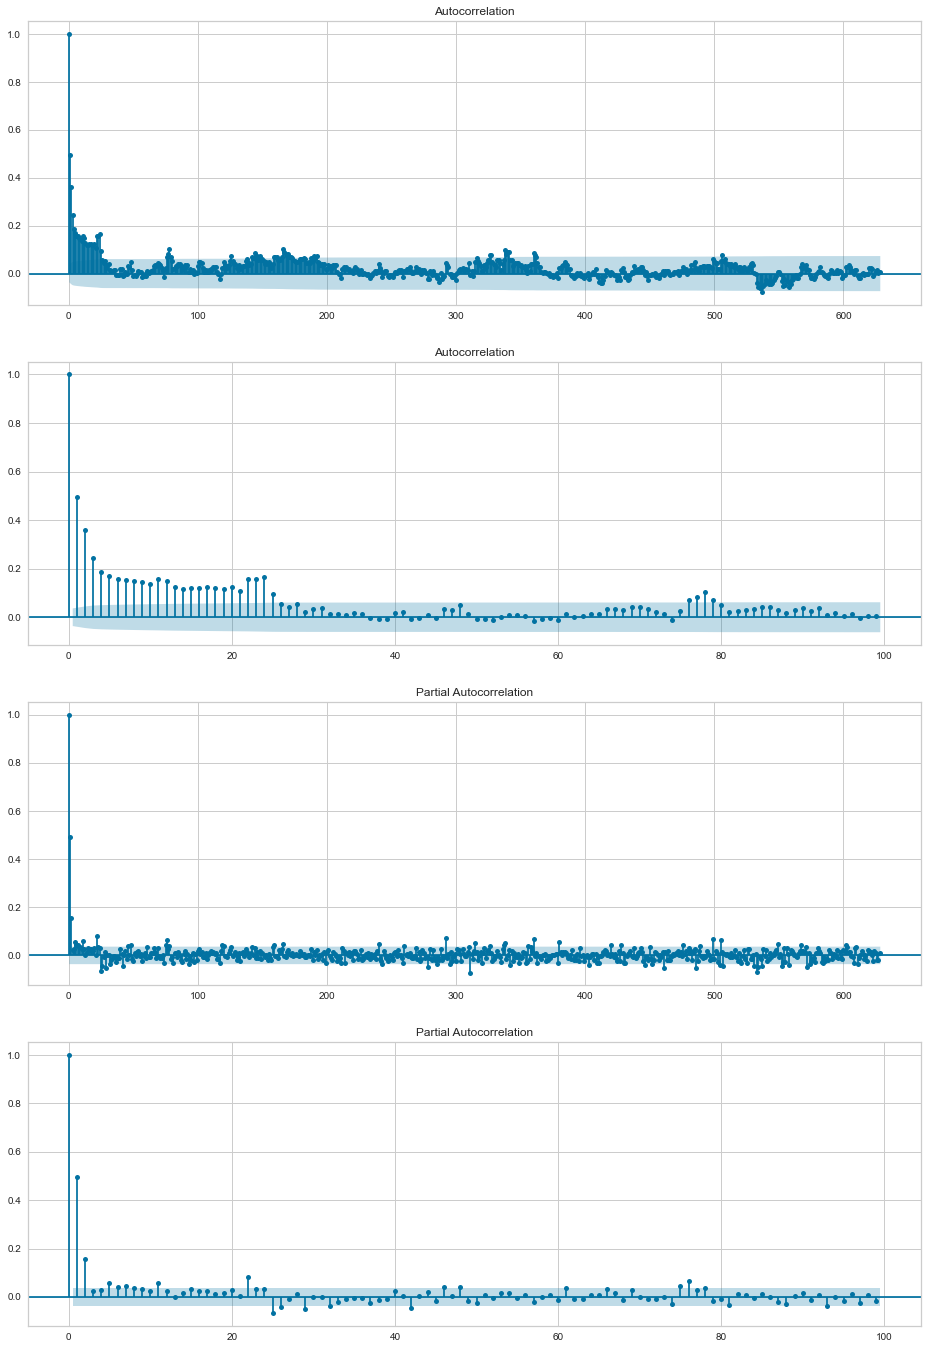

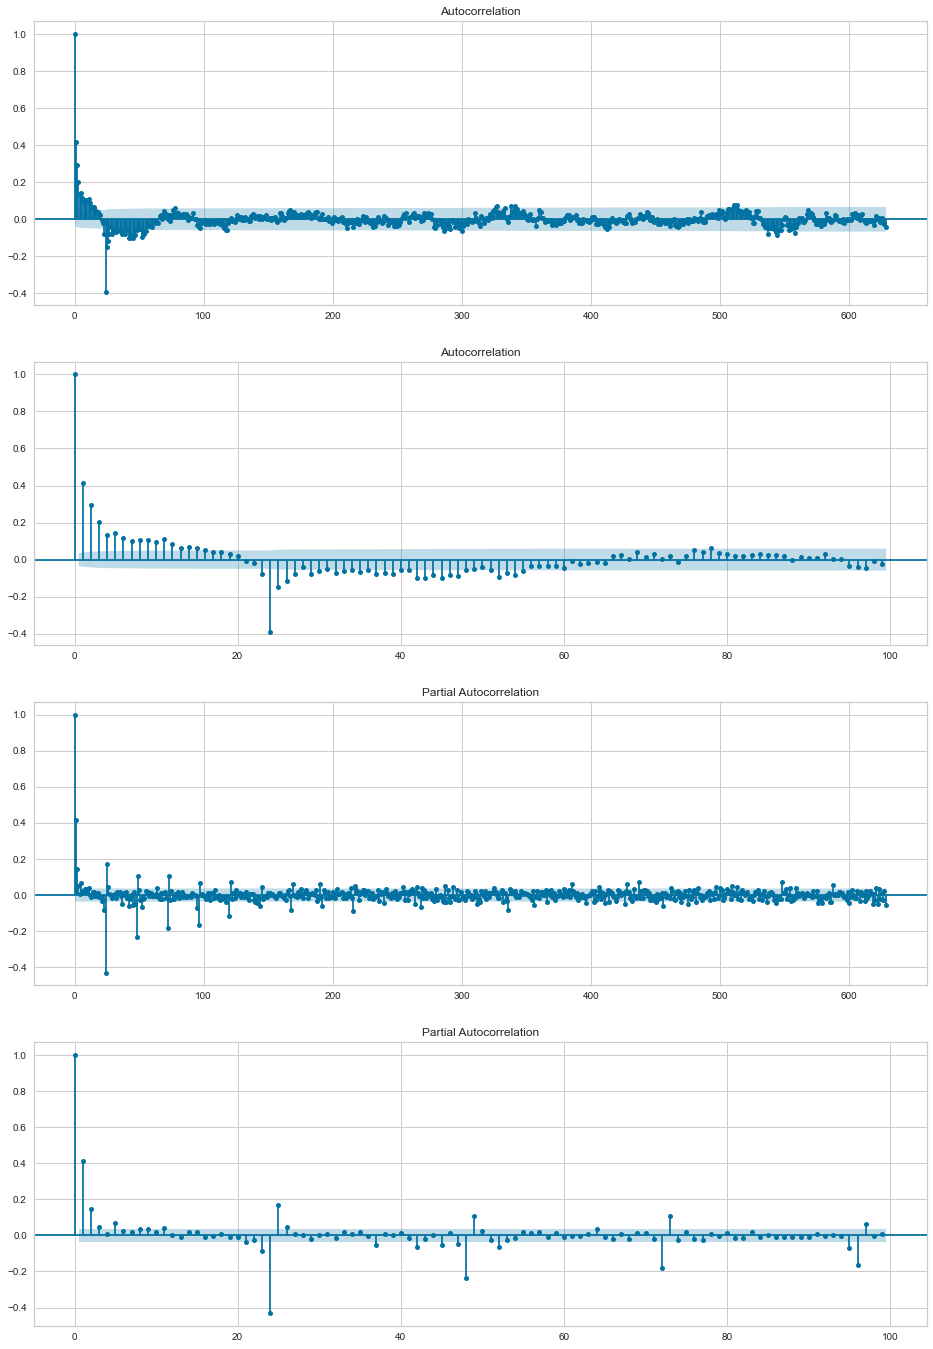

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 3 end of analysis
Cluster 4 analysis
R-squared: 0.8587240423224758
AIC: 33580.571897840906


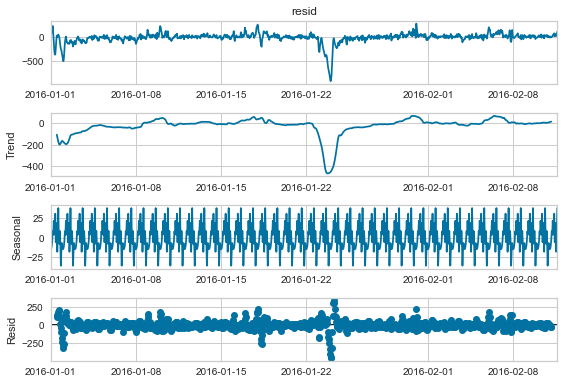

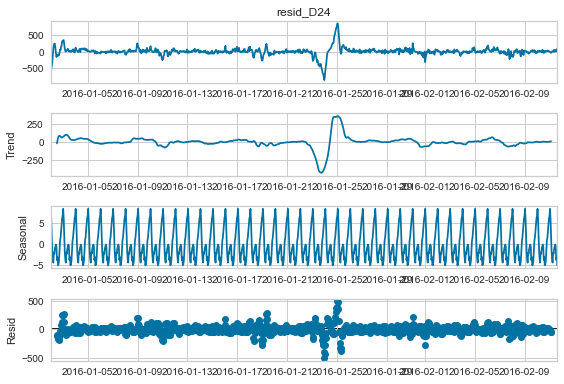

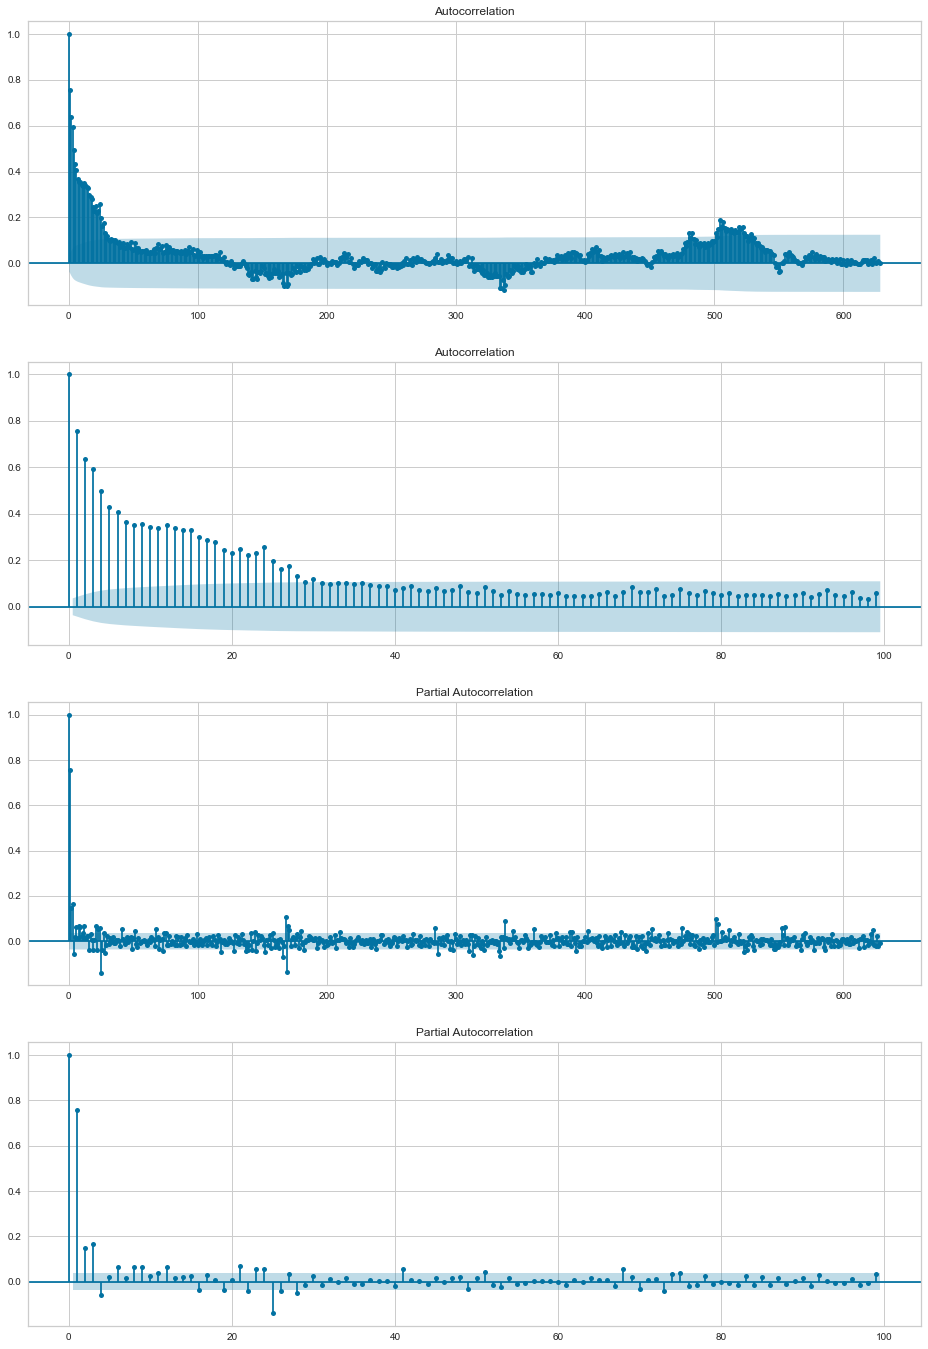

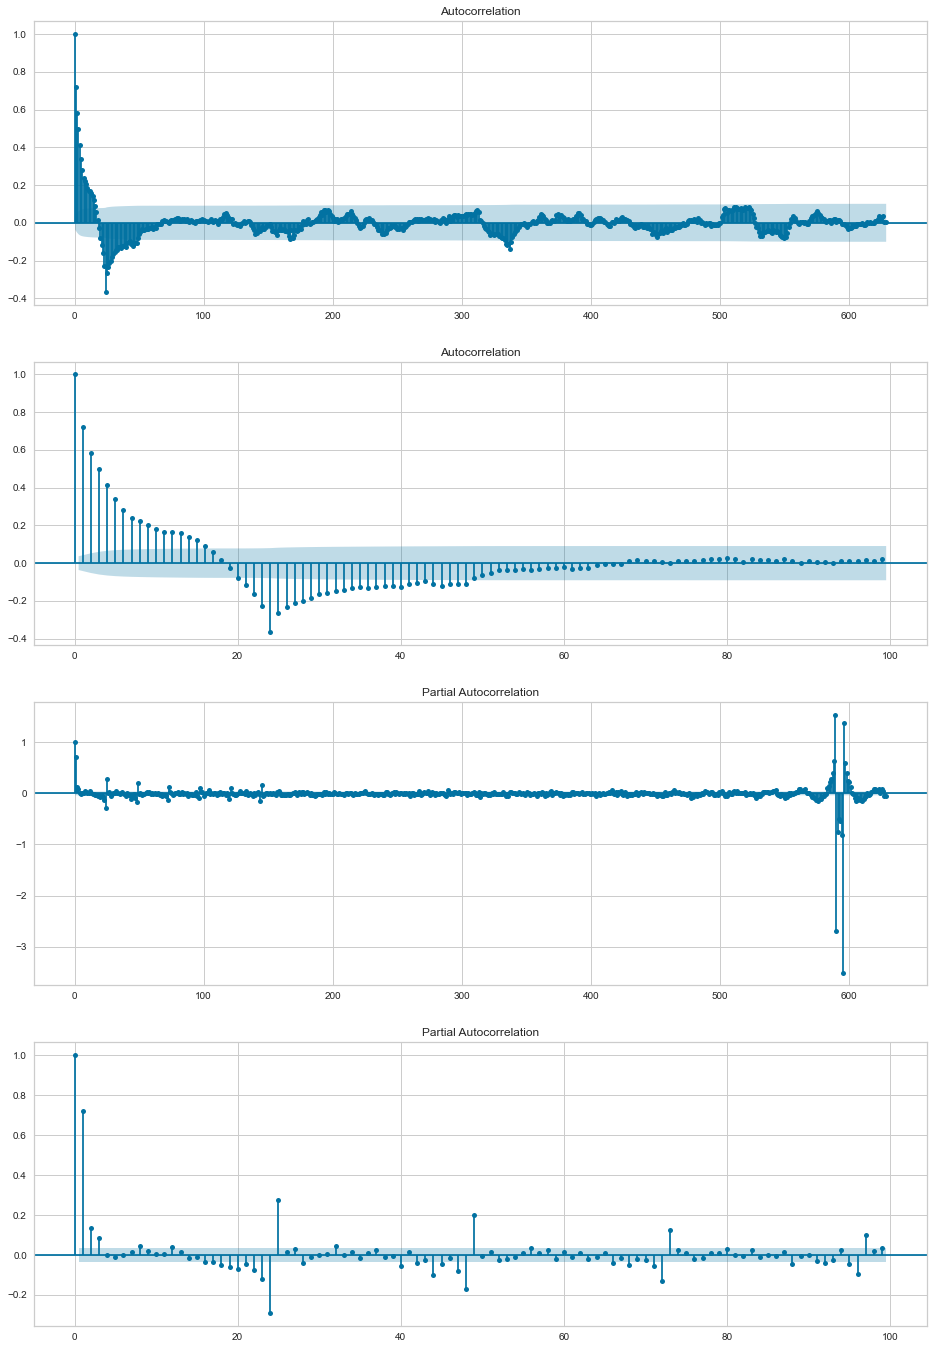

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 4 end of analysis
Cluster 5 analysis
R-squared: 0.9104703276785266
AIC: 34509.39139526296


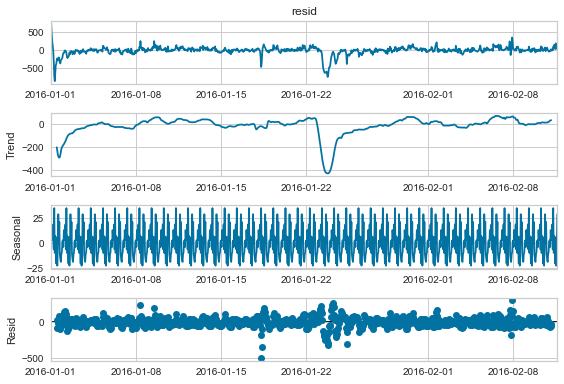

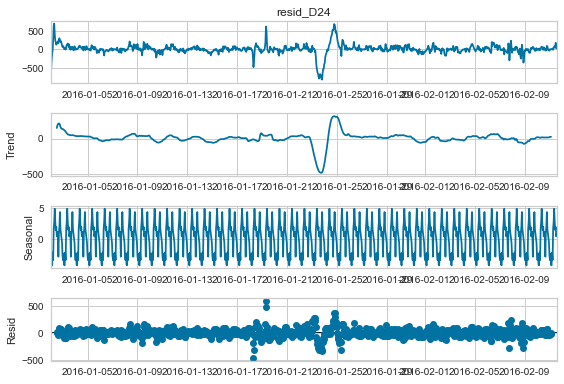

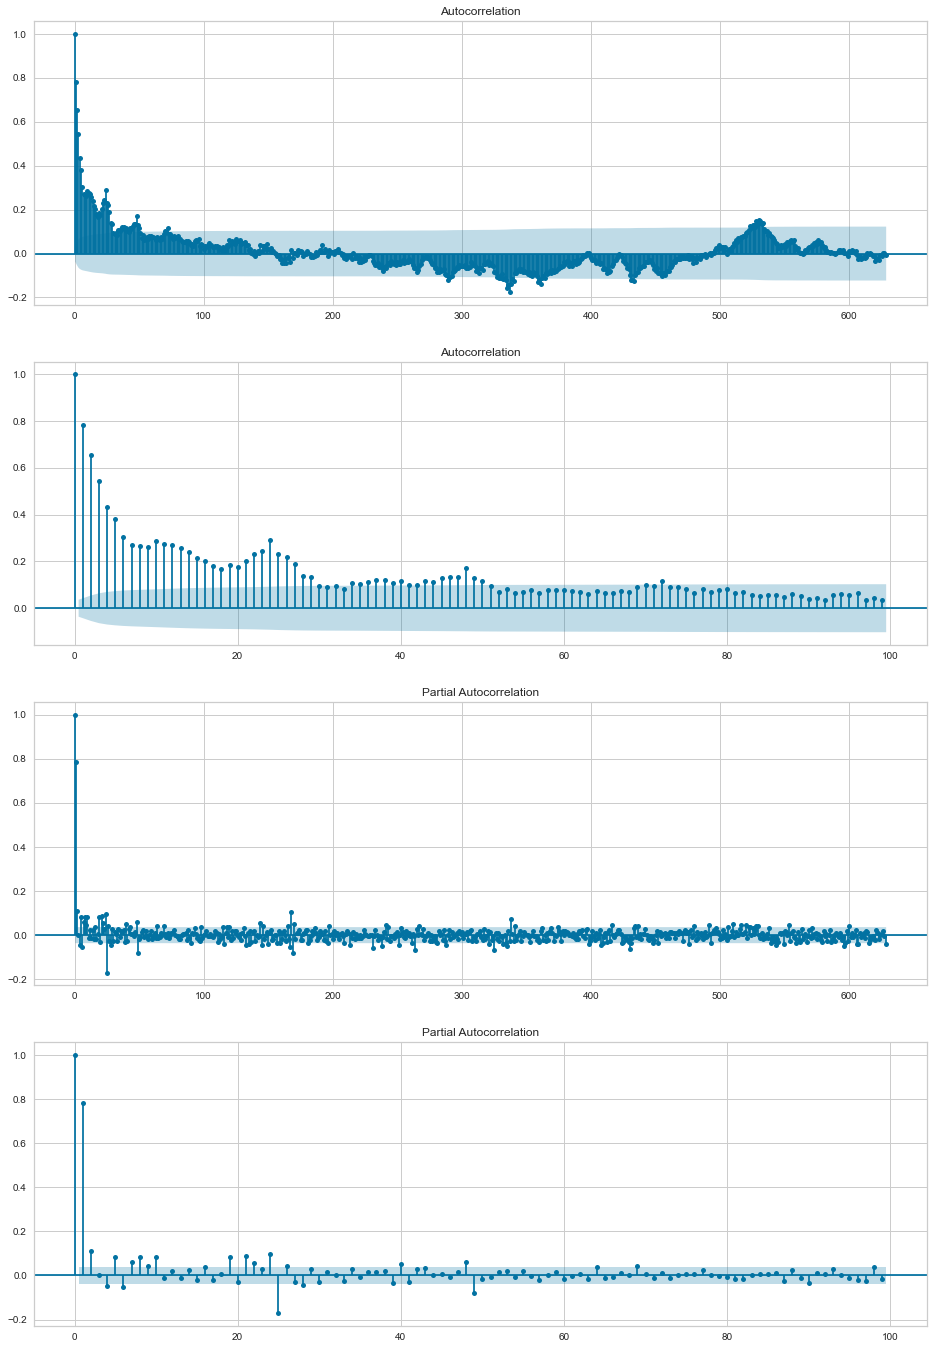

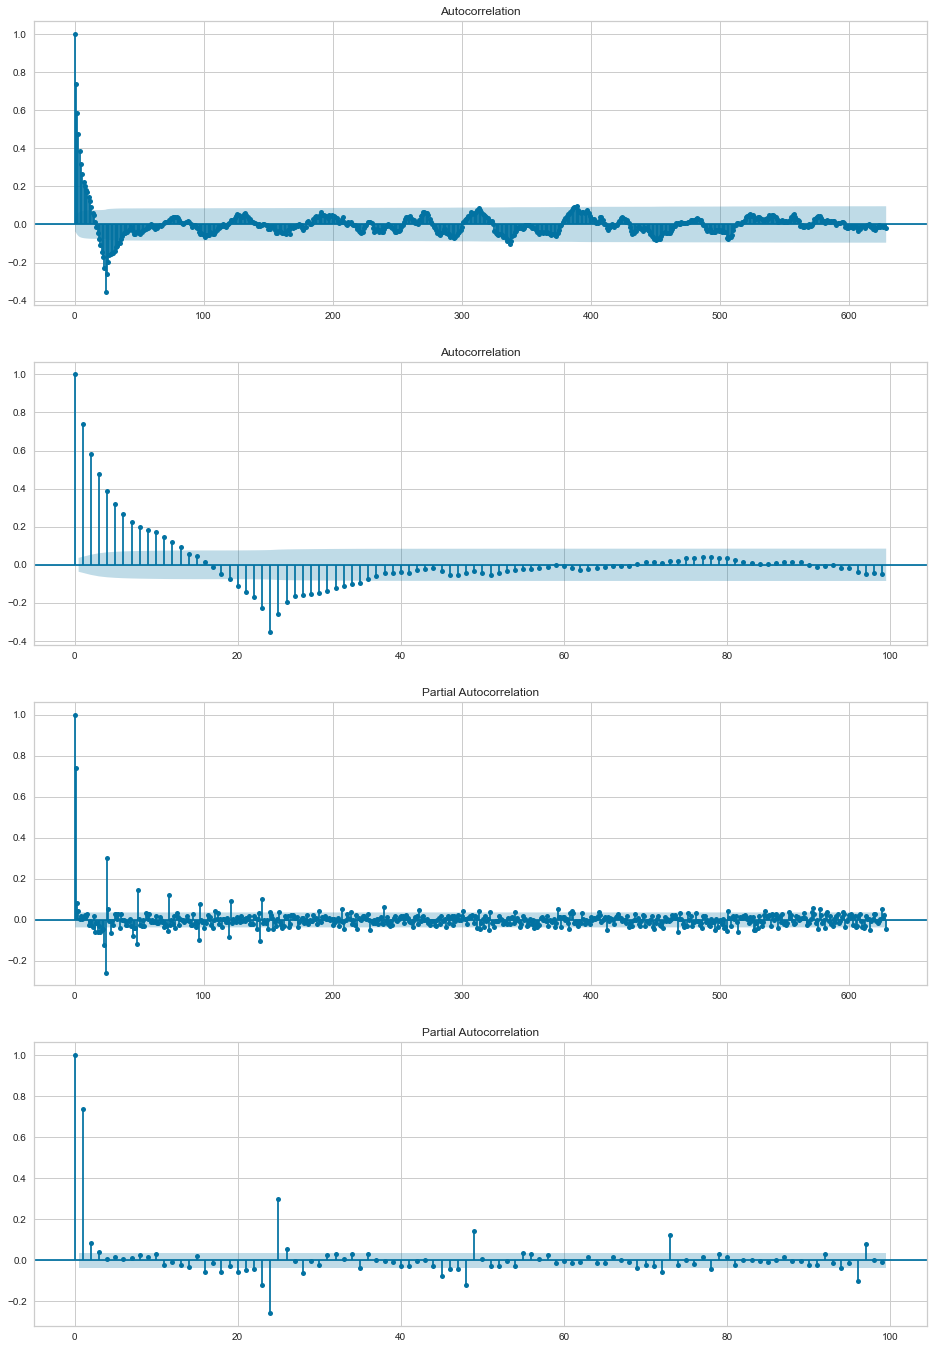

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 5 end of analysis
Cluster 6 analysis
R-squared: 0.8870359036141013
AIC: 35079.448403598886


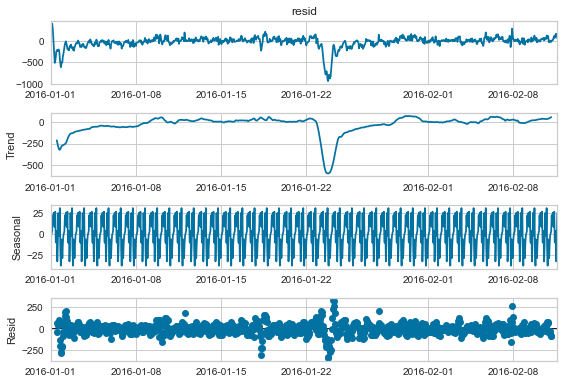

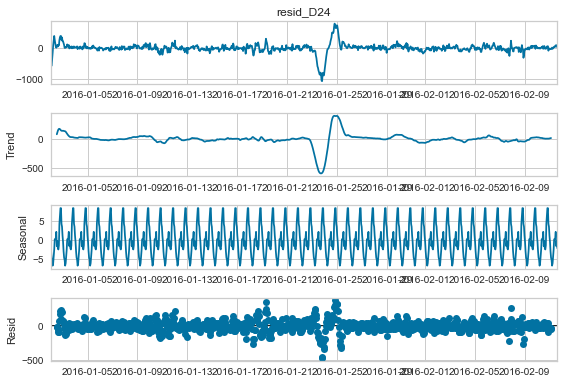

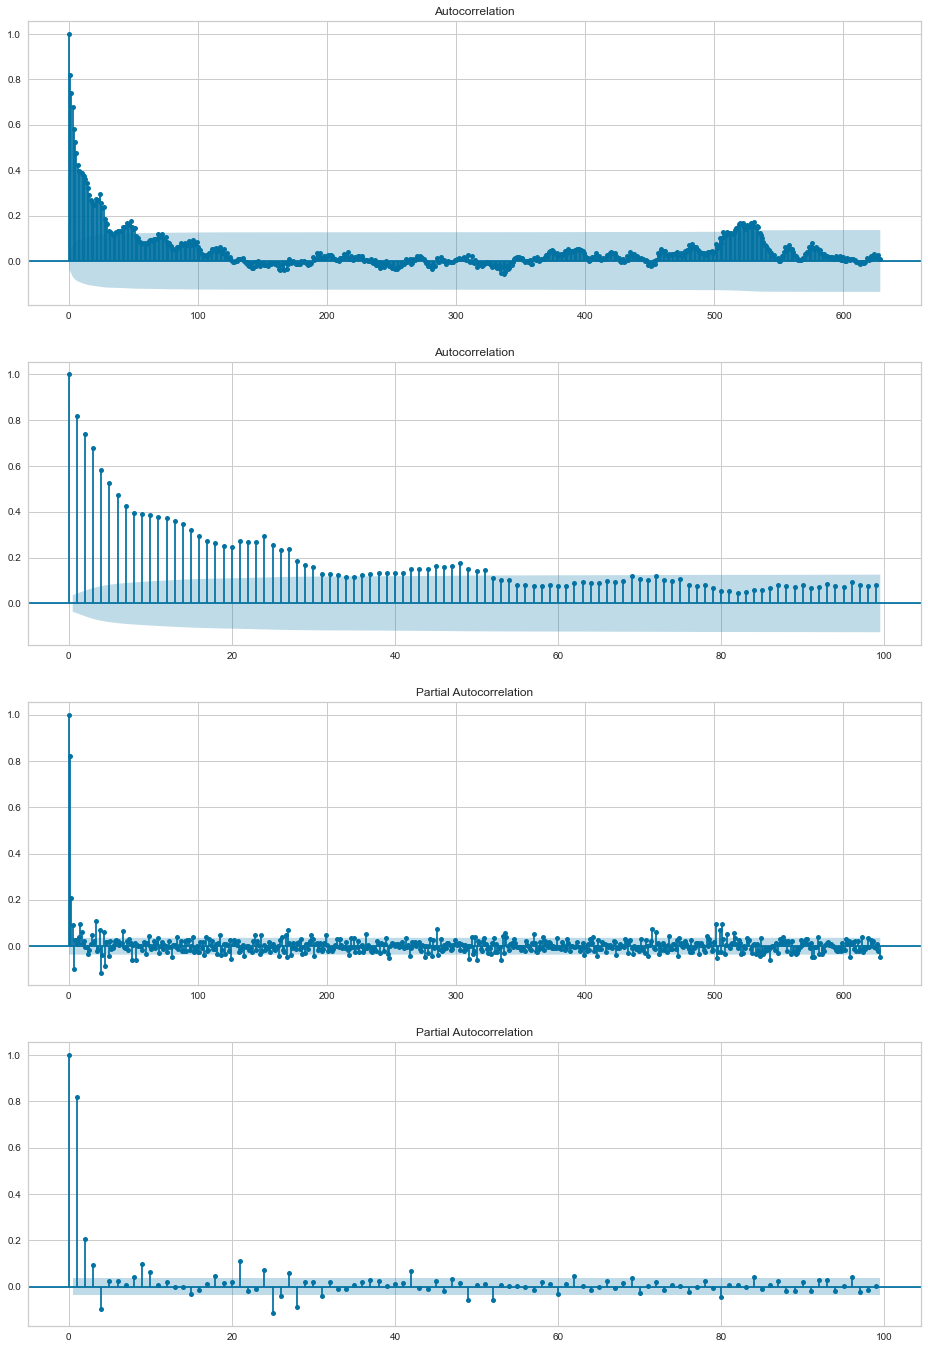

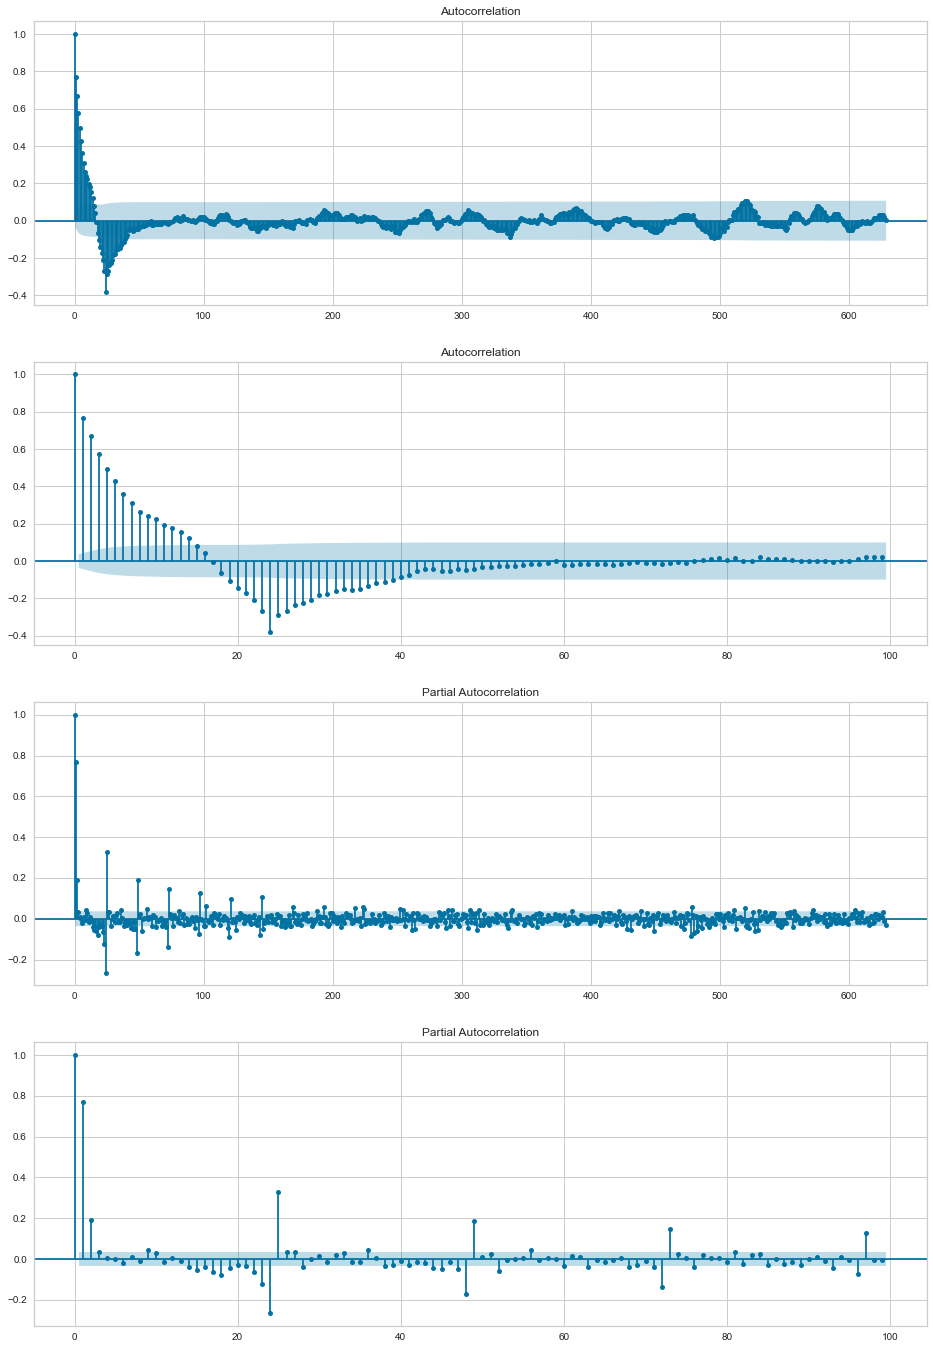

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0
Cluster 6 end of analysis


In [33]:
for cluster_number, num_of_exog in zip(range(7), [71, 31, 66, 66, 36, 51, 46]):
    seeking_of_parameters(cluster_number, num_of_exog)

## После покомпонентного разложения остатков на составляющие, визуально они и без сезонного дифференцирования кажутся стационарными (что также подтверждается очень маленькими значениями p-value критерия Дики-Фуллера). Таким образом, для сохранения ресурсов машины, будем подбирать парметры именно для ряда без дифференцирования.

### Таким образом имеем:
#### Для кластера 0, параметры: p=6, P=1, q=10, Q=1, D=0, d=0
#### Для кластера 1, параметры: p=5, P=1, q=6, Q=0, D=0, d=0
#### Для кластера 2, параметры: p=10, P=1, q=3, Q=1, D=0, d=0
#### Для кластера 3, параметры: p=11, P=0, q=11, Q=1, D=0, d=0
#### Для кластера 4, параметры: p=12, P=1, q=6, Q=4, D=0, d=0
#### Для кластера 5, параметры: p=10, P=1, q=6, Q=4, D=0, d=0
#### Для кластера 6, параметры: p=9, P=1, q=7, Q=4, D=0, d=0

###  👹Задание 6
Реализуйте подбор p,P,q,Q  для выбранных моделей SARMA или  SARIMA (если вы выбрали модель с дифференцированием) путем перебора по сетке с оптимизацией по AIC. Аналогичное задание вы делали на предыдущей неделе.


In [44]:
def sarimax_gridsearch(ts, exog, par, d=0, D=0, s=24, maxiter=50, freq='H'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    ans = []
    for (comb,j) in zip(par,range(len(par))):
        print(j)
        try:
            #print("ahahah")
            model = sm.tsa.statespace.SARIMAX(ts, exog,
                                                order=(comb[0],d,comb[1]),
                                                seasonal_order=(comb[2],D, comb[3],s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)
            #print("ohoho")
            output = model.fit(maxiter=maxiter, method='nm', disp=-1)#, low_memory=True) 
            #print("sg")
            ans.append([comb,output.aic])
            print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pqPQ', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:10]
    
    return ans_df

In [45]:
def prepare_dataset(clust,k=51):
    dataset=pd.DataFrame(df[inds[clust]].values,index=pd.to_datetime(df.index), columns={'count'})
    #dataset['time']=df.index
    #cluster0.head()
    w=168 # длительность недели в часах
    t=np.arange(1, dataset.shape[0]+1)
    dataset['constant']=np.ones(dataset.shape[0])
    for i in range(1,k):
        sin="s"+str(i)
        cos="c"+str(i)
        dataset[sin]=np.sin(2*i*np.pi*t/w)
        dataset[cos]=np.cos(2*i*np.pi*t/w)
    return dataset

In [46]:
# подготовим датасеты для каждого из кластеров
dataset0 = prepare_dataset(0, 71)
dataset1 = prepare_dataset(1, 31)
dataset2 = prepare_dataset(2, 66)
dataset3 = prepare_dataset(3, 66)
dataset4 = prepare_dataset(4, 36)
dataset5 = prepare_dataset(5, 51)
dataset6 = prepare_dataset(6, 46)

In [47]:
list_of_dfs = [dataset0, dataset1, dataset2, dataset3, dataset4, dataset5, dataset6]
list_of_dfs_params = [[6, 1, 10, 1],[5, 1, 6, 0],[10, 1, 3, 1],[11, 0, 11, 1],[12, 1, 6, 4],[10, 1, 6, 4],[9, 1, 7, 4]]

In [48]:
def make_dfs_dict(list_of_dfs, list_of_dfs_params):
    dict_ = {}
    for i, df, params in zip(range(7), list_of_dfs, list_of_dfs_params):
        dict_[f'dataset{i}'] = {'ts':df['count'], 'exog':df.drop('count', axis=1), 
                                'p':params[0], 'P':params[1], 'q':params[2], 'Q':params[3]}
    return dict_

In [49]:
mega_df = make_dfs_dict(list_of_dfs, list_of_dfs_params)

In [ ]:
%%time
df_params={}
for df in list(mega_df.keys()):
    print(f'////////////////////Parameters seeking for {df}////////////////////////////////')
    parameters = list(product(range(mega_df[df]['p']+1), range(mega_df[df]['q']+1), 
                              range(mega_df[df]['P']+1), range(mega_df[df]['Q']+1)))
    print(f'Parameters length is: {len(parameters)}')
    df_params[df] = sarimax_gridsearch(mega_df[df]['ts'],mega_df[df]['exog'], parameters, D=0, d=0,freq='H')
    dataframe = pd.DataFrame(df_params[df])
    dataframe.to_csv(f'{df}.csv')
    print(f'//////////////////End of parameters seeking for {df}///////////////////////////')

## После ТРЕХДНЕВНОГО!!! подбора, мы наконец получили лучшие параметры для каждой модели, которая будет строиться на кластерах.

In [41]:
for i in range(7):
    print(pd.read_csv(f"dataset{i}.csv"))

   Unnamed: 0           pqPQ           aic
0         171   (3, 9, 1, 1)  25983.283245
1         123   (2, 8, 1, 1)  25983.545982
2         215   (4, 9, 1, 1)  25984.802552
3          79   (1, 8, 1, 1)  25984.924797
4         167   (3, 8, 1, 1)  25985.122945
5          43  (0, 10, 1, 1)  25985.715778
6         211   (4, 8, 1, 1)  25986.508591
7         259   (5, 9, 1, 1)  25986.631481
8         255   (5, 8, 1, 1)  25987.448928
9          75   (1, 7, 1, 1)  25988.029082
   Unnamed: 0          pqPQ           aic
0          79  (5, 4, 1, 0)  16733.298014
1          63  (4, 3, 1, 0)  16733.660129
2          65  (4, 4, 1, 0)  16734.413265
3          83  (5, 6, 1, 0)  16736.265334
4          77  (5, 3, 1, 0)  16737.448954
5          75  (5, 2, 1, 0)  16738.872878
6          69  (4, 6, 1, 0)  16739.129161
7          71  (5, 0, 1, 0)  16739.386215
8          51  (3, 4, 1, 0)  16740.671726
9          73  (5, 1, 1, 0)  16741.032433
   Unnamed: 0           pqPQ           aic
0         163  (10, 0,

In [50]:
mega_df['dataset0']['p']=3
mega_df['dataset0']['P']=1
mega_df['dataset0']['q']=9
mega_df['dataset0']['Q']=1

mega_df['dataset1']['p']=5
mega_df['dataset1']['P']=1
mega_df['dataset1']['q']=4
mega_df['dataset1']['Q']=0

mega_df['dataset2']['p']=10
mega_df['dataset2']['P']=1
mega_df['dataset2']['q']=0
mega_df['dataset2']['Q']=1

mega_df['dataset3']['p']=1
mega_df['dataset3']['P']=0
mega_df['dataset3']['q']=11
mega_df['dataset3']['Q']=1

mega_df['dataset4']['p']=1
mega_df['dataset4']['P']=1
mega_df['dataset4']['q']=6
mega_df['dataset4']['Q']=4

mega_df['dataset5']['p']=5
mega_df['dataset5']['P']=1
mega_df['dataset5']['q']=6
mega_df['dataset5']['Q']=4

mega_df['dataset6']['p']=2
mega_df['dataset6']['P']=1
mega_df['dataset6']['q']=7
mega_df['dataset6']['Q']=4

In [51]:
#Для ускорения обучения и завершения в обозримые сроки, изменим значения Q на 1. (ниже Вы встретите пояснение)
mega_df['dataset4']['p']=1
mega_df['dataset4']['P']=1
mega_df['dataset4']['q']=6
mega_df['dataset4']['Q']=1

mega_df['dataset5']['p']=5
mega_df['dataset5']['P']=1
mega_df['dataset5']['q']=6
mega_df['dataset5']['Q']=1

mega_df['dataset6']['p']=2
mega_df['dataset6']['P']=1
mega_df['dataset6']['q']=7
mega_df['dataset6']['Q']=1

###  👹Задание 7
В задании 6 вы определили гиперпараметры модели ARIMA для каждого из кластеров. Внутри каждого кластера значения гиперпараметров модели p,P,q,Q,d,D будут одинаковых. Остальные же параметры должны настраиваться для каждого региона по отдельности.
1. Добавьте в датасет `df` данные за май и июнь месяцы.
2. Обучите 102 модели(отдельно для каждого региона) ARIMA с экзогенными переменными **по данным за январь-май**
**Замечания:** 
- модели удобно организовать в словарь(или словари - если по каждому кластеру отдельно)
- имеет смысл сохранять обученные модели, т.к. обучаюся они долго и не всегда это можно успеть сделатьза 1 подход. Имейте в виду, что каждая модель будет весить около 350 Мб.

In [53]:
df_5=pd.read_csv("taxi_2016_05.csv")
df_6=pd.read_csv("taxi_2016_06.csv")
df_5.rename(columns={'Unnamed: 0':'time'}, inplace=True)
df_6.rename(columns={'Unnamed: 0':'time'}, inplace=True)
df_5.index=df_5.time
df_6.index=df_6.time
df_5=df_5.iloc[:,nonzero_reg]
df_6=df_6.iloc[:,nonzero_reg]
df_large=pd.concat([ df,df_5,df_6], axis=0)
df_large.index = pd.to_datetime(df_large.index)

df_large.head()

1075   1076  1077   1125   1126   1127   1128   1129  \
time                                                                        
2016-01-01 00:00:00  80.0  144.0  50.0   77.0  319.0  402.0  531.0  617.0   
2016-01-01 01:00:00  91.0  211.0  49.0  134.0  404.0  420.0  370.0  453.0   
2016-01-01 02:00:00  90.0  146.0  23.0  110.0  393.0  425.0  313.0  366.0   
2016-01-01 03:00:00  32.0   87.0  16.0   62.0  252.0  399.0  324.0  309.0   
2016-01-01 04:00:00  24.0   43.0  10.0   53.0  145.0  254.0  264.0  333.0   

                      1130   1131  ...  1630  1684  1733  1734  1783  2068  \
time                               ...                                       
2016-01-01 00:00:00  846.0  267.0  ...  12.0   0.0   2.0  44.0   5.0  41.0   
2016-01-01 01:00:00  594.0  224.0  ...  29.0   0.0   5.0   2.0   2.0   4.0   
2016-01-01 02:00:00  377.0  138.0  ...  47.0   0.0   3.0   0.0   4.0   0.0   
2016-01-01 03:00:00  327.0  166.0  ...  46.0   0.0   2.0   4.0   5.0   1.0   
2016-01-01 04:00:00  318.0  145.0  ...  43.0   0.0   0.0   1.0   1.0   0.0   

                     2069  2118  2119  2168  
time                                         
2016-01-01 00:00:00   4.0  70.0   7.0  66.0  
2016-01-01 01:00:00   0.0  47.0   1.0  29.0  
2016-01-01 02:00:00   0.0  69.0   1.0  14.0  
2016-01-01 03:00:00   0.0  21.0   0.0   9.0  
2016-01-01 04:00:00   0.0  26.0   1.0   6.0  

[5 rows x 102 columns]

In [54]:
clusters

{0: ['1684', '1733', '1734', '1783', '2068', '2069', '2118', '2119', '2168'],
 1: ['1221',
  '1222',
  '1227',
  '1272',
  '1273',
  '1326',
  '1327',
  '1376',
  '1377',
  '1378',
  '1426',
  '1532',
  '1533'],
 2: ['1172',
  '1173',
  '1174',
  '1175',
  '1225',
  '1339',
  '1387',
  '1388',
  '1389',
  '1390',
  '1435',
  '1436',
  '1437',
  '1438',
  '1439',
  '1441',
  '1442'],
 3: ['1431', '1480', '1482', '1483', '1530', '1580', '1630'],
 4: ['1128',
  '1129',
  '1130',
  '1176',
  '1177',
  '1178',
  '1182',
  '1223',
  '1224',
  '1228',
  '1229',
  '1274',
  '1278',
  '1380'],
 5: ['1076',
  '1077',
  '1132',
  '1181',
  '1183',
  '1184',
  '1234',
  '1235',
  '1279',
  '1280',
  '1283',
  '1284',
  '1285',
  '1286',
  '1287',
  '1331',
  '1332',
  '1333',
  '1334',
  '1335',
  '1336',
  '1337',
  '1383',
  '1384',
  '1385',
  '1386',
  '1434'],
 6: ['1075',
  '1125',
  '1126',
  '1127',
  '1131',
  '1179',
  '1180',
  '1230',
  '1231',
  '1232',
  '1233',
  '1281',
  '1282',
 

In [55]:
# дальнейшая подготовка данных
mega_cluster_df={}

for index in range(7):
    mega_cluster_df[f'cluster_{index}'] = {}
    mega_cluster_df[f'cluster_{index}']['exog'] = mega_df[f'dataset{index}']['exog'].copy()
    mega_cluster_df[f'cluster_{index}']['p'] = mega_df[f'dataset{index}']['p']
    mega_cluster_df[f'cluster_{index}']['q'] = mega_df[f'dataset{index}']['q']
    mega_cluster_df[f'cluster_{index}']['P'] = mega_df[f'dataset{index}']['P']
    mega_cluster_df[f'cluster_{index}']['Q'] = mega_df[f'dataset{index}']['Q']
    for region in clusters[index]:
        mega_cluster_df[f'cluster_{index}'][region] = df_large[region]

In [56]:
mega_cluster_df

{'cluster_0': {'exog':                      constant        s1        c1        s2        c2  \
  time                                                                    
  2016-01-01 00:00:00       1.0  0.037391  0.999301  0.074730  0.997204   
  2016-01-01 01:00:00       1.0  0.074730  0.997204  0.149042  0.988831   
  2016-01-01 02:00:00       1.0  0.111964  0.993712  0.222521  0.974928   
  2016-01-01 03:00:00       1.0  0.149042  0.988831  0.294755  0.955573   
  2016-01-01 04:00:00       1.0  0.185912  0.982566  0.365341  0.930874   
  ...                       ...       ...       ...       ...       ...   
  2016-04-30 19:00:00       1.0  0.997204 -0.074730 -0.149042 -0.988831   
  2016-04-30 20:00:00       1.0  0.993712 -0.111964 -0.222521 -0.974928   
  2016-04-30 21:00:00       1.0  0.988831 -0.149042 -0.294755 -0.955573   
  2016-04-30 22:00:00       1.0  0.982566 -0.185912 -0.365341 -0.930874   
  2016-04-30 23:00:00       1.0  0.974928 -0.222521 -0.433884 -0.900969   
  
 

In [154]:
### Функция вычисления ошибки
def count_sum_error_for_model(model, dataframe, exog, start_date):
    t = start_date + pd.Timedelta(1, 'H')
    all_time_error_value = 0
    while t + pd.Timedelta(5, 'H') <= pd.to_datetime('2016-05-31 17:00'):
        six_hour_prediction = model.get_prediction(t, t + pd.Timedelta(5, 'H'), 
                                                                  exog = exog[start_date + pd.Timedelta(1, 'H'):t + pd.Timedelta(5, 'H')], dynamic=True)
        all_time_error_value += abs(np.array(six_hour_prediction.predicted_mean.values) - np.array(dataframe[t:t + pd.Timedelta(5, 'H')].values)).sum()
        t = t + pd.Timedelta(1, 'H')
    return all_time_error_value

In [80]:
def build_exogs(ts, k):
    dataset=pd.DataFrame(ts,index=pd.to_datetime(ts.index), columns={'count'})
    #dataset['time']=df.index
    #cluster0.head()
    w=168 # длительность недели в часах
    t=np.arange(1, dataset.shape[0]+1)
    dataset['constant']=np.ones(dataset.shape[0])
    for i in range(1,k):
        sin="s"+str(i)
        cos="c"+str(i)
        dataset[sin]=np.sin(2*i*np.pi*t/w)
        dataset[cos]=np.cos(2*i*np.pi*t/w)
    return dataset.drop('count', axis=1)

In [147]:
%%time
from datetime import datetime
error = 0
for cluster_index, exog_num in zip(range(7),[71, 31, 66, 66, 36, 51, 46]) :
    print(f'///////////////////////////Start models for cluster {cluster_index}////////////////////////////////////////')
    p = mega_cluster_df[f'cluster_{cluster_index}']['p']
    q = mega_cluster_df[f'cluster_{cluster_index}']['q']
    P = mega_cluster_df[f'cluster_{cluster_index}']['P']
    Q = mega_cluster_df[f'cluster_{cluster_index}']['Q']
    d = 0
    D = 0
    s = 24
    
    exog = build_exogs(mega_cluster_df[f'cluster_{cluster_index}'][clusters[cluster_index][0]], exog_num)
    
    cluster_error = 0
    for region in clusters[cluster_index]:
        region_error = 0
        print(f'//////////////////Cluster {cluster_index}, region {region}//////////////////////')
        ts = mega_cluster_df[f'cluster_{cluster_index}'][region][:pd.to_datetime('2016-04-30 23:00')]
        exog_ = exog[:pd.to_datetime('2016-04-30 23:00')]
        print("Start of training")
        start = datetime.now()
        model = sm.tsa.statespace.SARIMAX(ts, exog=exog_, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)
        end = datetime.now()
        print(f'End of training: {end-start}')
        region_error = count_sum_error_for_model(model, df_large[region], exog, pd.to_datetime('2016-04-30 23:00'))
        cluster_error += region_error
        error += region_error
    print(f'Error for cluster {cluster_index} is: {cluster_error/(len(clusters[cluster_index]) * 739 * 6)}')
    print(f'///////////////////////////End models for cluster {cluster_index}////////////////////////////////////////')
print()
print(f'All models error: {error/(102*739*6)}')
    

///////////////////////////Start models for cluster 0////////////////////////////////////////
//////////////////Cluster 0, region 1684//////////////////////
Start of training
End of training: 0:06:28.395108
//////////////////Cluster 0, region 1733//////////////////////
Start of training
End of training: 0:05:58.442832
//////////////////Cluster 0, region 1734//////////////////////
Start of training
End of training: 0:06:10.254650
//////////////////Cluster 0, region 1783//////////////////////
Start of training
End of training: 0:06:36.318431
//////////////////Cluster 0, region 2068//////////////////////
Start of training
End of training: 0:06:01.065081
//////////////////Cluster 0, region 2069//////////////////////
Start of training
End of training: 0:06:31.336554
//////////////////Cluster 0, region 2118//////////////////////
Start of training
End of training: 0:07:04.302740
//////////////////Cluster 0, region 2119//////////////////////
Start of training
End of training: 0:06:35.629885
//

KeyboardInterrupt: 

## Ввиду очередного очень долгого обучения, для последних двух кластеров изменим значение парметра Q на 1. Как видно, обучение для кластера 4 проходило более 12 часов. Так как в следующих кластерах больше регионов и, более того, гиперпараметры модели имеют бОльшие значения, такой "трюк с переворотом" остается единственным выходом, чтобы модели досчитались

## Оставим медленно обучаться на ночь и будем надеяться на успешное завершение

In [156]:
%%time
from datetime import datetime
error = 0
for cluster_index, exog_num in zip(range(7),[71, 31, 66, 66, 36, 51, 46]) :
    print(f'///////////////////////////Start models for cluster {cluster_index}////////////////////////////////////////')
    p = mega_cluster_df[f'cluster_{cluster_index}']['p']
    q = mega_cluster_df[f'cluster_{cluster_index}']['q']
    P = mega_cluster_df[f'cluster_{cluster_index}']['P']
    Q = mega_cluster_df[f'cluster_{cluster_index}']['Q']
    d = 0
    D = 0
    s = 24
    
    exog = build_exogs(mega_cluster_df[f'cluster_{cluster_index}'][clusters[cluster_index][0]], exog_num)
    
    cluster_error = 0
    for region in clusters[cluster_index]:
        region_error = 0
        print(f'//////////////////Cluster {cluster_index}, region {region}//////////////////////')
        ts = mega_cluster_df[f'cluster_{cluster_index}'][region][:pd.to_datetime('2016-04-30 23:00')]
        exog_ = exog[:pd.to_datetime('2016-04-30 23:00')]
        print("Start of training")
        start = datetime.now()
        model = sm.tsa.statespace.SARIMAX(ts, exog=exog_, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)
        end = datetime.now()
        print(f'End of training: {end-start}')
        region_error = count_sum_error_for_model(model, df_large[region], exog, pd.to_datetime('2016-04-30 23:00'))
        cluster_error += region_error
        error += region_error
    print(f'Error for cluster {cluster_index} is: {cluster_error/(len(clusters[cluster_index]) * 739 * 6)}')
    print(f'///////////////////////////End models for cluster {cluster_index}////////////////////////////////////////')
print()
print(f'All models error: {error/(102*739*6)}')

///////////////////////////Start models for cluster 0////////////////////////////////////////
//////////////////Cluster 0, region 1684//////////////////////
Start of training
End of training: 0:06:27.904863
//////////////////Cluster 0, region 1733//////////////////////
Start of training
End of training: 0:05:58.741387
//////////////////Cluster 0, region 1734//////////////////////
Start of training
End of training: 0:06:15.860365
//////////////////Cluster 0, region 1783//////////////////////
Start of training
End of training: 0:06:32.555492
//////////////////Cluster 0, region 2068//////////////////////
Start of training
End of training: 0:05:58.388507
//////////////////Cluster 0, region 2069//////////////////////
Start of training
End of training: 0:06:27.361067
//////////////////Cluster 0, region 2118//////////////////////
Start of training
End of training: 0:07:02.686330
//////////////////Cluster 0, region 2119//////////////////////
Start of training
End of training: 0:06:32.695788
//

End of training: 0:03:53.054875
//////////////////Cluster 5, region 1132//////////////////////
Start of training
End of training: 0:04:36.678461
//////////////////Cluster 5, region 1181//////////////////////
Start of training
End of training: 0:05:41.552344
//////////////////Cluster 5, region 1183//////////////////////
Start of training
End of training: 0:04:11.793852
//////////////////Cluster 5, region 1184//////////////////////
Start of training
End of training: 0:04:02.649502
//////////////////Cluster 5, region 1234//////////////////////
Start of training
End of training: 0:04:10.179643
//////////////////Cluster 5, region 1235//////////////////////
Start of training
End of training: 0:04:21.437474
//////////////////Cluster 5, region 1279//////////////////////
Start of training
End of training: 0:03:45.319841
//////////////////Cluster 5, region 1280//////////////////////
Start of training
End of training: 0:05:08.751435
//////////////////Cluster 5, region 1283//////////////////////
S

## Обучение майских моделей

In [112]:
### Функция вычисления ошибки и записи ответов в фрейм
def count_sum_error_for_model(model, dataframe, exog, start_date, region):
    t = start_date + pd.Timedelta(1, 'H')
    all_time_error_value = 0
    df = pd.DataFrame(columns=['id', 'y'])
    while t + pd.Timedelta(5, 'H') <= pd.to_datetime('2016-06-30 17:00'):
        six_hour_prediction = model.get_prediction(t, t + pd.Timedelta(5, 'H'), 
                                                                  exog = exog[start_date + pd.Timedelta(1, 'H'):t + pd.Timedelta(5, 'H')], dynamic=True)
        ans_array = six_hour_prediction.predicted_mean.values
        id_array = [f"{region}_{t.year}-{t.month}-{t.day}_{t.hour}_{i+1}" for i in range(6)]
        df = pd.concat([df, pd.DataFrame({'id': id_array, 'y': ans_array})], ignore_index=True, axis=0)
        all_time_error_value += abs(np.array(six_hour_prediction.predicted_mean.values) - np.array(dataframe[t:t + pd.Timedelta(5, 'H')].values)).sum()
        t = t + pd.Timedelta(1, 'H')
    return all_time_error_value, df

In [113]:
%%time
from datetime import datetime
import pickle
error = 0
df = pd.DataFrame(columns=['id', 'y'])
for cluster_index, exog_num in zip(range(7),[71, 31, 66, 66, 36, 51, 46]) :
    print(f'///////////////////////////Start models for cluster {cluster_index}////////////////////////////////////////')
    p = mega_cluster_df[f'cluster_{cluster_index}']['p']
    q = mega_cluster_df[f'cluster_{cluster_index}']['q']
    P = mega_cluster_df[f'cluster_{cluster_index}']['P']
    Q = mega_cluster_df[f'cluster_{cluster_index}']['Q']
    d = 0
    D = 0
    s = 24
    
    exog = build_exogs(mega_cluster_df[f'cluster_{cluster_index}'][clusters[cluster_index][0]], exog_num)
    
    cluster_error = 0
    for region in clusters[cluster_index]:
        region_error = 0
        print(f'//////////////////Cluster {cluster_index}, region {region}//////////////////////')
        ts = mega_cluster_df[f'cluster_{cluster_index}'][region][:pd.to_datetime('2016-05-31 23:00')]
        exog_ = exog[:pd.to_datetime('2016-05-31 23:00')]
        print("Start of training")
        start = datetime.now()
        model = sm.tsa.statespace.SARIMAX(ts, exog=exog_, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)
        end = datetime.now()
        print(f'End of training: {end-start}')
        model.save(f"./models_may/model_{cluster_index}_{region}.pkl")
        region_error, to_append = count_sum_error_for_model(model, df_large[region], exog, pd.to_datetime('2016-05-31 23:00'), region)
        df = pd.concat([df, to_append], ignore_index=True, axis=0)
        cluster_error += region_error
        error += region_error
    print(f'Error for cluster {cluster_index} is: {cluster_error/(len(clusters[cluster_index]) * 739 * 6)}')
    print(f'///////////////////////////End models for cluster {cluster_index}////////////////////////////////////////')
print()
print(f'All models error: {error/(102*739*6)}')
df.to_csv('submission.csv', index=False)

///////////////////////////Start models for cluster 0////////////////////////////////////////
//////////////////Cluster 0, region 1684//////////////////////
Start of training
End of training: 0:08:43.882399
//////////////////Cluster 0, region 1733//////////////////////
Start of training
End of training: 0:07:49.305374
//////////////////Cluster 0, region 1734//////////////////////
Start of training
End of training: 0:07:51.212144
//////////////////Cluster 0, region 1783//////////////////////
Start of training
End of training: 0:08:45.383058
//////////////////Cluster 0, region 2068//////////////////////
Start of training
End of training: 0:07:33.536710
//////////////////Cluster 0, region 2069//////////////////////
Start of training
End of training: 0:07:17.218771
//////////////////Cluster 0, region 2118//////////////////////
Start of training
End of training: 0:10:31.370315
//////////////////Cluster 0, region 2119//////////////////////
Start of training
End of training: 0:10:27.471274
//

End of training: 0:05:06.722285
//////////////////Cluster 5, region 1132//////////////////////
Start of training
End of training: 0:05:31.840258
//////////////////Cluster 5, region 1181//////////////////////
Start of training
End of training: 0:05:28.093667
//////////////////Cluster 5, region 1183//////////////////////
Start of training
End of training: 0:05:01.233913
//////////////////Cluster 5, region 1184//////////////////////
Start of training
End of training: 0:04:47.976757
//////////////////Cluster 5, region 1234//////////////////////
Start of training
End of training: 0:05:06.194428
//////////////////Cluster 5, region 1235//////////////////////
Start of training
End of training: 0:05:18.314012
//////////////////Cluster 5, region 1279//////////////////////
Start of training
End of training: 0:05:07.101102
//////////////////Cluster 5, region 1280//////////////////////
Start of training
End of training: 0:05:13.618652
//////////////////Cluster 5, region 1283//////////////////////
S

In [ ]:
# сохранение моделей 

for reg in list(map(str, reg_0)):
    model_0[reg].save("./models_may/model_0_" + str(reg) + ".pkl")

In [114]:
df

id          y
0         1684_2016-6-1_0_1  -0.385092
1         1684_2016-6-1_0_2   2.373831
2         1684_2016-6-1_0_3  -0.262771
3         1684_2016-6-1_0_4   1.511255
4         1684_2016-6-1_0_5  -0.570474
...                     ...        ...
433903  1382_2016-6-30_12_2  44.560110
433904  1382_2016-6-30_12_3  40.477065
433905  1382_2016-6-30_12_4  27.991242
433906  1382_2016-6-30_12_5  17.882110
433907  1382_2016-6-30_12_6  24.746096

[433908 rows x 2 columns]

## 👹Задание 8
В каждом регионе для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу
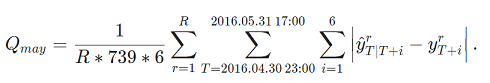
**Рекомендации:**
- можно воспользоваться `SARIMAXResults.predict()` или `SARIMAXResults.get_prediction()`. В качестве агрумента `start` берите концы истории, а `end` - концы истории плюс 6 часов, установите параметр `dymanic=True`

## 👹Задание 9
Для каждой из R географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.